# Large Language Models can better predict optimal medication change in Parkinson's Disease through Medical notes

## Introduction

TODO

### Importing packages

In [1]:
import numpy as np
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

## Data Pre-processing

### Exploring the data

In [2]:
path = "data/HEHE.csv" 
available_memory = 423464092  # Memory in bytes
memory_per_row = 100  # Example memory usage per row in bytes
target_memory_usage = 0.75 * available_memory
chunk_size = int(target_memory_usage / memory_per_row)
chunk_size

3175980

Original df that contains notes info

In [3]:
# Actual way to read large CSV files
chunk = pd.read_csv(path, chunksize=chunk_size, dtype={'dose_unit_source_value': str}) #Raises a DtypeWarning: Columns (11) have mixed types when it is not specified
df = pd.concat(chunk)

DataFrame with drug_exposure info

In [4]:
drug_exposure = pd.read_csv('data/TRY.csv')

Loading demographic info

In [5]:
demographics = pd.read_csv('data/DEMOGRAPHICS.csv') # Demographic information for PD patients only
demographics_all = pd.read_csv('data/DEMOGRAPHICS_ALL.csv') # Demographics info for all the patients

In [6]:
df.sample(5)

person_id                                  drug_source_value  \
2168346     194868  {"med_display_name": "senna (SENOKOT) syrup 15...   
131653      256936  {"med_display_name": "ceFEPIme (MAXIPIME) 1 g ...   
1828362     213526  {"med_display_name": "cloNIDine (CATAPRES-TTS)...   
1332401     226132  {"med_display_name": "norepinephrine (LEVOPHED...   
776390      255046  {"med_display_name": "fentaNYL (SUBLIMAZE) inj...   

         quantity              sig route_source_value  dose_source_value  \
2168346   15.0000      NIGHTLY PRN         PER G TUBE              15.00   
131653   100.0000   EVERY 24 HOURS        INTRAVENOUS               1.00   
1828362    1.0000           WEEKLY        TRANSDERMAL               1.00   
1332401   25.5665       CONTINUOUS        INTRAVENOUS               0.02   
776390     0.1000  BOLUS PRN IN OR                NaN             100.00   

        dose_unit_source_value  \
2168346                     mL   
131653                       g   
1828362                   each   
1332401             mcg/kg/min   
776390                     mcg   

                                                 note_text  
2168346  [**NAME**], MD     [**DATE**]  5:08 PM Infecti...  
131653   "[**NAME**], MD     [**DATE**] 10:13 PM Infect...  
1828362  "[**NAME**], RD     [**DATE**]  9:52 AM INPATI...  
1332401  "[**NAME**], MD     [**DATE**]  8:40 PM Depart...  
776390   [**NAME**], RN     [**DATE**]  1:35 PM Consult...

Calculating patient age

In [7]:
# Converting the "birth_datetime" column to a datetime format 
demographics["birth_datetime"] = pd.to_datetime(demographics["birth_datetime"], format='%Y-%m-%d')
demographics_all["birth_datetime"] = pd.to_datetime(demographics_all["birth_datetime"], format='%Y-%m-%d')

# Calculating the age by substracting the current date with the date in the dataframe
demographics["age"] = (pd.Timestamp('now') - demographics["birth_datetime"]).astype('timedelta64[Y]')
demographics_all["age"] = (pd.Timestamp('now') - demographics_all["birth_datetime"]).astype('timedelta64[Y]')

# Converting age to integer
demographics["age"]  = pd.to_numeric(demographics["age"], downcast='integer')
demographics_all["age"]  = pd.to_numeric(demographics_all["age"], downcast='integer')

# Dropping the birth_datetime (it's useless at this point) 
demographics = demographics.drop("birth_datetime", axis=1)
demographics_all = demographics_all.drop("birth_datetime", axis=1)

# Re-arranging the order of the columns
demographics = demographics[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value']]
demographics_all = demographics_all[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value']]

demographics

person_id  age gender_source_value race_source_value  \
0       261006   74                MALE             WHITE   
1       260996   76              FEMALE             WHITE   
2       260956   88              FEMALE             WHITE   
3       260918   79              FEMALE             WHITE   
4       260872   74                MALE             BLACK   
..         ...  ...                 ...               ...   
281     176706   78              FEMALE             WHITE   
282     176462   68                MALE             WHITE   
283     176417   77                MALE             WHITE   
284     175744   90                MALE             WHITE   
285     175605   89                MALE             OTHER   

    ethnicity_source_value  
0             NOT HISPANIC  
1             NOT HISPANIC  
2             NOT HISPANIC  
3             NOT HISPANIC  
4             NOT HISPANIC  
..                     ...  
281           NOT HISPANIC  
282           NOT HISPANIC  
283           NOT HISPANIC  
284           NOT HISPANIC  
285               HISPANIC  

[286 rows x 5 columns]

Actual len of the whole dataset. It has more than 2 Million rows

In [8]:
len(df)

2326300

#### Number of patients in this cohort

In [9]:
df['person_id'].nunique()

441

#### Dealing with the drug_source_value column

Because the drug_source_value column contains elements as json, we convert them into a dict so that we can use their original keys:

In [10]:
drug_source_value = df['drug_source_value'].apply(lambda x: json.loads(x))

We do the same for the `drug_source_value` column in the drug_exposure database

In [11]:
dsv_drug_exposure = drug_exposure['drug_source_value'].apply(lambda x: json.loads(x))

dsv_drug_exposure has already been filtered through SQL and contains Parkinson's drugs

In [12]:
dsv_drug_exposure

0        {'med_display_name': 'carbidopa-levodopa (SINE...
1        {'med_display_name': 'carbidopa-levodopa (SINE...
2        {'med_display_name': 'carbidopa-levodopa (SINE...
3        {'med_display_name': 'carbidopa-levodopa (SINE...
4        {'med_display_name': 'carbidopa-levodopa (SINE...
                               ...                        
26941    {'med_display_name': 'carbidopa-levodopa (SINE...
26942    {'med_display_name': 'carbidopa-levodopa (SINE...
26943    {'med_display_name': 'carbidopa-levodopa (SINE...
26944    {'med_display_name': 'carbidopa-levodopa (SINE...
26945    {'med_display_name': 'carbidopa-levodopa (SINE...
Name: drug_source_value, Length: 26946, dtype: object

drug_source_value has the same len as the original df. The positions of the dictionary are the rows in the OG df 

In [13]:
drug_source_value[12] == json.loads(df.iloc[12]['drug_source_value'])

True

The keys of the dictionary are those used in the drug_source_value column

In [14]:
drug_source_value[0].keys()

dict_keys(['med_display_name', 'rxnorm_concat', 'med_dose_unit_desc', 'mar_action', 'med_order_desc'])

In [15]:
drug_source_value[12]

{'med_display_name': '0.9 % NaCl infusion',
 'rxnorm_concat': '| 313002 |',
 'med_dose_unit_desc': 'ml/hr',
 'mar_action': 'NEW BAG',
 'med_order_desc': 'SODIUM CHLORIDE 0.9 % IV SOLN'}

Current medication used for the treatment of Parkinson's disease

In [16]:
# Defining the generic name of drugs used to treat Parkinson's disease
pd_medication = ["carbidopa", "levodopa", "entacapone", "tolcapone", "opicapone", "pramipexole", "ropinirole", "apomorphine", "rotigotine", "selegiline", "rasagiline", "safinamide", "amantadine", "istradefylline", "trihexyphenidyl", "benztropine", "bromocriptine", "cabergoline", "pergolide", "lisuride", 'benserazide']

We look for instances of the Parkinson's drugs contained in the pd_medication array in drug_source_value so that we can focus on the medical notes relating to Parkinson's.

In [17]:
pd_drug_info = {}
for i, drug in enumerate(drug_source_value):
    for item in pd_medication:
        # I'm still not sure why I can use drug as a dict here. Answer because drug_source_value is a dict
        if item in drug['med_display_name']:
            pd_drug_info[i] = drug['med_display_name'] # I could have also passed the whole dictionary

Something similar (extracting the med_display_name and using that instead of the whole json)

In [18]:
drug_info_drug_source_value = {}
for i, drug in enumerate(dsv_drug_exposure):
    drug_info_drug_source_value[i] = drug['med_display_name'] # I could have also passed the whole dictionary

In [19]:
pd_drug_info

{126: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 127: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 955: 'amantadine (SYMMETREL) capsule 100 mg',
 956: 'amantadine (SYMMETREL) capsule 100 mg',
 957: 'amantadine (SYMMETREL) capsule 100 mg',
 958: 'amantadine (SYMMETREL) capsule 100 mg',
 959: 'amantadine (SYMMETREL) capsule 100 mg',
 960: 'amantadine (SYMMETREL) capsule 100 mg',
 961: 'amantadine (SYMMETREL) capsule 100 mg',
 962: 'amantadine (SYMMETREL) capsule 100 mg',
 963: 'amantadine (SYMMETREL) capsule 100 mg',
 964: 'amantadine (SYMMETREL) capsule 100 mg',
 965: 'amantadine (SYMMETREL) capsule 100 mg',
 966: 'amantadine (SYMMETREL) capsule 100 mg',
 967: 'amantadine (SYMMETREL) capsule 100 mg',
 968: 'amantadine (SYMMETREL) capsule 100 mg',
 969: 'amantadine (SYMMETREL) capsule 100 mg',
 970: 'amantadine (SYMMETREL) solution 100 mg',
 971: 'amantadine (SYMMETREL) solution 100 mg',
 972: 'amantadine (SYMMETREL) solution 100 mg',
 973: 'amantadi

In [20]:
drug_info_drug_source_value

{0: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 2: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 3: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 4: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 5: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 6: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 7: 'amantadine (SYMMETREL) capsule 100 mg',
 8: 'amantadine (SYMMETREL) capsule 100 mg',
 9: 'amantadine (SYMMETREL) capsule 100 mg',
 10: 'amantadine (SYMMETREL) capsule 100 mg',
 11: 'amantadine (SYMMETREL) capsule 100 mg',
 12: 'amantadine (SYMMETREL) capsule 100 mg',
 13: 'amantadine (SYMMETREL) capsule 100 mg',
 14: 'amantadine (SYMMETREL) capsule 100 mg',
 15: 'amantadine (SYMMETREL) capsule 100 mg',
 16: 'amantadine (SYMMETREL) capsule 100 mg',
 17: 'amantadine (SYMMETREL) capsule 100 mg',
 18: 'amantadine (SYMMETREL) capsul

Only 16K+ rows have information regarding medication for Parkinson's

In [21]:
len(pd_drug_info)

16040

The keys of this new array are the indices or rows in the original DataFrame. These rows contain information regarding Parkinson's medication 

In [22]:
pd_drug_info.keys()

dict_keys([126, 127, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 2353, 2354, 2355, 2438, 2439, 2521, 2522, 2523, 2524, 2525, 2706, 2707, 2708, 2709, 2710, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 3496, 3497, 3498, 3499, 3500, 3501, 350

pd_drug_info is a subset of drug_source_value that contains the name of drugs related to PD

In [23]:
pd_drug_info[1299166]

'cabergoline (DOSTINEX) tablet 1 mg'

In [24]:
drug_source_value[1299166]

{'med_display_name': 'cabergoline (DOSTINEX) tablet 1 mg',
 'rxnorm_concat': '| 199703 |',
 'med_dose_unit_desc': 'mg',
 'mar_action': 'GIVEN',
 'med_order_desc': 'CABERGOLINE 0.5 MG PO TABS'}

Here's our new database. df_pd is a subset of the original dataset that only contains patients that are taking medication for Parkinson's

In [25]:
df_pd = df.iloc[list(pd_drug_info.keys())]
df_pd.sample(10)

person_id                                  drug_source_value  \
1056250     248934  {"med_display_name": "carbidopa-levodopa (SINE...   
664734      256706  {"med_display_name": "benztropine (COGENTIN) t...   
2123298     198429  {"med_display_name": "carbidopa-levodopa (SINE...   
1421078     220757  {"med_display_name": "amantadine (SYMMETREL) c...   
1776897     215778  {"med_display_name": "carbidopa-levodopa (SINE...   
1927126     207746  {"med_display_name": "carbidopa-levodopa (SINE...   
919138      250105  {"med_display_name": "carbidopa-levodopa (SINE...   
664299      256706  {"med_display_name": "benztropine (COGENTIN) t...   
2034063     203035  {"med_display_name": "carbidopa-levodopa (SINE...   
664413      256706  {"med_display_name": "benztropine (COGENTIN) t...   

         quantity            sig route_source_value  dose_source_value  \
1056250       1.0  2 TIMES DAILY               ORAL                1.0   
664734        1.0  2 TIMES DAILY               ORAL                1.0   
2123298       1.0          DAILY               ORAL                1.0   
1421078       2.0        NIGHTLY               ORAL              200.0   
1776897      20.0  3 TIMES DAILY           PER TUBE               20.0   
1927126       1.0  4 TIMES DAILY               ORAL                1.0   
919138        1.0        NIGHTLY               ORAL                1.0   
664299        0.0  2 TIMES DAILY               ORAL                0.0   
2034063       1.0  3 TIMES DAILY               ORAL                1.0   
664413        1.0  2 TIMES DAILY               ORAL                0.5   

        dose_unit_source_value  \
1056250                 tablet   
664734                      mg   
2123298                 tablet   
1421078                     mg   
1776897                     mL   
1927126                 tablet   
919138                  tablet   
664299                      mg   
2034063                 tablet   
664413                      mg   

                                                 note_text  
1056250  [**NAME**], RN     [**DATE**] 11:17 AM Consult...  
664734   [**NAME**]     [**DATE**]  1:26 PM CM consult ...  
2123298  "[**NAME**], DO     [**DATE**]  4:45 PM Depart...  
1421078  [**NAME**], MD     [**DATE**] 12:50 PM Departm...  
1776897  "[**NAME**], MD     [**DATE**]  4:22 PM Depart...  
1927126  [**NAME**], MD     [**DATE**]  5:03 PM ADULT H...  
919138   [**NAME**], MD     [**DATE**]  1:26 PM Please ...  
664299   [**NAME**]     [**DATE**]  4:07 PM Consult not...  
2034063  [**NAME**]     [**DATE**]  4:02 PM Department ...  
664413   [**NAME**], MD     [**DATE**]  6:45 PM Patient...

Inserting the column drug_info into the pd dataset

In [26]:
df_pd.insert(loc=2, column="drug_info", value=drug_info_drug_source_value)

In [27]:
df_pd.sample(5)

person_id                                  drug_source_value  \
664524      256706  {"med_display_name": "benztropine (COGENTIN) t...   
2051850     202019  {"med_display_name": "carbidopa-levodopa (SINE...   
1585332     220757  {"med_display_name": "pramipexole (MIRAPEX) ta...   
1202340     245457  {"med_display_name": "carbidopa-levodopa (SINE...   
1777363     215778  {"med_display_name": "carbidopa-levodopa (SINE...   

        drug_info  quantity                                   sig  \
664524        NaN       1.0                         2 TIMES DAILY   
2051850       NaN       1.0                         3 TIMES DAILY   
1585332       NaN       1.0                               NIGHTLY   
1202340       NaN       1.5                         EVERY 3 HOURS   
1777363       NaN       1.0  As Directed (see Admin Instructions)   

        route_source_value  dose_source_value dose_unit_source_value  \
664524                ORAL               1.00                     mg   
2051850               ORAL               1.00                 tablet   
1585332               ORAL               0.25                     mg   
1202340               ORAL               1.50                 tablet   
1777363               ORAL               1.00                 tablet   

                                                 note_text  
664524   [**NAME**], MD     [**DATE**]  2:15 PM This co...  
2051850  "[**NAME**], MD     [**DATE**] 10:28 PM Depart...  
1585332  "[**NAME**], MD     [**DATE**]  9:21 AM Depart...  
1202340  "[**NAME**], MD     [**DATE**] 11:10 AM Depart...  
1777363  "[**NAME**], MD     [**DATE**]  6:18 PM Depart...

In [28]:
df_pd.iloc[955]

person_id                                                            257075
drug_source_value         {"med_display_name": "carbidopa-levodopa (SINE...
drug_info                                                               NaN
quantity                                                                0.5
sig                                                           4 TIMES DAILY
route_source_value                                                     ORAL
dose_source_value                                                       0.5
dose_unit_source_value                                               tablet
note_text                 "[**NAME**], MD     [**DATE**]  9:56 PM [**LOC...
Name: 92436, dtype: object

Let's take a look at the drugs actually used in the dataset. **Note**: vscode truncakes the ouput so it could be that you won't see all the drugs. i.e: Cabergoline (1299166).

In [29]:
pd_drug_info

{126: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 127: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 955: 'amantadine (SYMMETREL) capsule 100 mg',
 956: 'amantadine (SYMMETREL) capsule 100 mg',
 957: 'amantadine (SYMMETREL) capsule 100 mg',
 958: 'amantadine (SYMMETREL) capsule 100 mg',
 959: 'amantadine (SYMMETREL) capsule 100 mg',
 960: 'amantadine (SYMMETREL) capsule 100 mg',
 961: 'amantadine (SYMMETREL) capsule 100 mg',
 962: 'amantadine (SYMMETREL) capsule 100 mg',
 963: 'amantadine (SYMMETREL) capsule 100 mg',
 964: 'amantadine (SYMMETREL) capsule 100 mg',
 965: 'amantadine (SYMMETREL) capsule 100 mg',
 966: 'amantadine (SYMMETREL) capsule 100 mg',
 967: 'amantadine (SYMMETREL) capsule 100 mg',
 968: 'amantadine (SYMMETREL) capsule 100 mg',
 969: 'amantadine (SYMMETREL) capsule 100 mg',
 970: 'amantadine (SYMMETREL) solution 100 mg',
 971: 'amantadine (SYMMETREL) solution 100 mg',
 972: 'amantadine (SYMMETREL) solution 100 mg',
 973: 'amantadi

In [30]:
# pd_drugs_used is just the list version of lowercase values in pd_drug_info
pd_drugs_used = [item.lower() for item in pd_drug_info.values()]
# Takes the unique values and sorts them to finally be saved in an array
pd_drugs_used_unique = sorted(set(pd_drugs_used))

We do the same for the drugs in dsv_drug_exposure

In [31]:
drugs_used_drug_exposure = [item.lower() for item in drug_info_drug_source_value.values()]
drugs_used_drug_exposure_unique = sorted(set(drugs_used_drug_exposure))

In [32]:
drugs_used_drug_exposure_unique

['* rasagiline mesylate (azilect) 1 mg - pharmacist to verify when brought in',
 '* rasagiline mesylate (azilect) tablet 1 mg - patient to bring and pharmacist to verify',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '*amantadine er (gocovri) extended release capsule 137 mg - patient supplied',
 '*carbidopa-levodopa er (rytary) 36.25-145 mg cpcr 1 tablet - patient supplied',
 '*carbidopa-levodopa er (rytary) 48.75-195 mg cpcr 1 capsule - patient supplied',
 '*carbidopa-levodopa er 36.25-145 mg cpcr 1 capsule-patient supplied med',
 '*carbidopa-levodopa er 48.75-195 mg cpcr 1 capsule - patient supplied',
 '*carbidopa-levodopa er 48.75-195 mg cpcr 1 capsule-patient supplied',
 '*carbidopa-levodopa er 48.75-195 mg cpcr 1 capsule-patient supplied med ',
 '*ropinirole (requip xl) 24 hr tablet patient supplied',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 200 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel

**Note:** 1299166 is **NOT** the position in the array but rather the key that contains the element. The len for both structures in 16040  

In [33]:
pd_drug_info[1299166]

'cabergoline (DOSTINEX) tablet 1 mg'

The position in the list that contains item with the key 1299166

In [34]:
list(pd_drug_info.keys()).index(1299166)

7778

In [35]:
pd_drugs_used

['carbidopa-levodopa (sinemet) 25-100 mg per tablet 2 tablet',
 'carbidopa-levodopa (sinemet) 25-100 mg per tablet 2 tablet',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel) solution 100 mg',
 'benztropine (cogentin) tabl

In [36]:
pd_drugs_used_unique

['* rasagiline mesylate (azilect) 1 mg - pharmacist to verify when brought in',
 '* rasagiline mesylate (azilect) tablet 1 mg - patient to bring and pharmacist to verify',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '*amantadine er (gocovri) extended release capsule 137 mg - patient supplied',
 '*carbidopa-levodopa er (rytary) 36.25-145 mg cpcr 1 tablet - patient supplied',
 '*carbidopa-levodopa er (rytary) 48.75-195 mg cpcr 1 capsule - patient supplied',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 200 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel) solution 200 mg',
 'amantadine (symmetrel) solution 50 mg',
 'amantadine (symmetrel) syrup 100 mg',
 'amantadine (symmetrel) syrup 50 mg',
 'amantadine er (gocovri) extended release capsule 137 mg',
 'apomorphine (apokyn) injection 1 ml',
 'benztropine (cogentin) tablet 0.5 mg',
 'benztropine (cogentin) tablet 1 mg',
 'benztropine (cogentin) tablet 2 mg

In [37]:
drugs_used_drug_exposure_unique

['* rasagiline mesylate (azilect) 1 mg - pharmacist to verify when brought in',
 '* rasagiline mesylate (azilect) tablet 1 mg - patient to bring and pharmacist to verify',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '*amantadine er (gocovri) extended release capsule 137 mg - patient supplied',
 '*carbidopa-levodopa er (rytary) 36.25-145 mg cpcr 1 tablet - patient supplied',
 '*carbidopa-levodopa er (rytary) 48.75-195 mg cpcr 1 capsule - patient supplied',
 '*carbidopa-levodopa er 36.25-145 mg cpcr 1 capsule-patient supplied med',
 '*carbidopa-levodopa er 48.75-195 mg cpcr 1 capsule - patient supplied',
 '*carbidopa-levodopa er 48.75-195 mg cpcr 1 capsule-patient supplied',
 '*carbidopa-levodopa er 48.75-195 mg cpcr 1 capsule-patient supplied med ',
 '*ropinirole (requip xl) 24 hr tablet patient supplied',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 200 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel

Using a ***Regex*** to segment from the pd_drugs_used array the drug_name, generic_name and dosage

In [38]:
# Regex: ? 0 o 1 for the last element. + 1 or more. 
# Matches generic name (Word characters followed by either a space or hyphens) and brand name (A name)
drug_names_pattern = r"([\w\s-]+)\s(?:\(([\w\s-]+)\)\s*)?" 
dosage_pattern = r"\d+(?:\.\d+)?(?:-\d+(?:\.\d+)?)*(?:\s*(?:mg/ml|mg|ml))(?:/hr)?"

# Initialize empty lists
generic_names = []
brand_names = []
dosages = []

# Extract information and populate the lists
for string in pd_drugs_used:
    drug_name_match = re.findall(drug_names_pattern, string)
    if drug_name_match:
        generic_name, brand_name = drug_name_match[0]
        generic_names.append(generic_name)

        if brand_name:
            brand_names.append(brand_name)
        else:
            brand_names.append(np.nan)

        dosage_match = re.findall(dosage_pattern, string)
        
        if dosage_match:
            dosages.append(dosage_match[0])
        else:
            dosages.append(np.nan)
    else:
        # Nice way to remove outlier and keeping the length the same
        print(string)
        generic_names.append(np.nan)


# Create DataFrame
pd_data = pd.DataFrame({
    "generic_name": generic_names,
    "brand_name": brand_names,
    "dosage": dosages
})

*Regex* for drug_exposure

In [39]:
# Regex: ? 0 o 1 for the last element. + 1 or more. 
# Matches generic name (Word characters followed by either a space or hyphens) and brand name (A name)
drug_names_pattern = r"([\w\s-]+)\s(?:\(([\w\s-]+)\)\s*)?" 
dosage_pattern = r"\d+(?:\.\d+)?(?:-\d+(?:\.\d+)?)*(?:\s*(?:mg/ml|mg|ml))(?:/hr)?"

# Initialize empty lists
generic_names_de = []
brand_names_de = []
dosages_de = []

# Extract information and populate the lists
for string in drugs_used_drug_exposure:
    drug_name_match = re.findall(drug_names_pattern, string)
    if drug_name_match:
        generic_name, brand_name = drug_name_match[0]
        generic_names_de.append(generic_name)

        if brand_name:
            brand_names_de.append(brand_name)
        else:
            brand_names_de.append(np.nan)

        dosage_match = re.findall(dosage_pattern, string)
        
        if dosage_match:
            dosages_de.append(dosage_match[0])
        else:
            dosages_de.append(np.nan)
    else:
        # Nice way to remove outlier and keeping the length the same
        print(string)
        generic_names_de.append(np.nan)


# Create DataFrame
pd_data_drug_exposure = pd.DataFrame({
    "generic_name": generic_names_de,
    "brand_name": brand_names_de,
    "dosage": dosages_de
})

In [40]:
pd_data.sample(20)

generic_name  brand_name      dosage
3666     carbidopa-levodopa     sinemet   10-100 mg
8070     carbidopa-levodopa     sinemet   25-100 mg
4605            pramipexole     mirapex     0.25 mg
9476     carbidopa-levodopa     sinemet   25-100 mg
86       carbidopa-levodopa     sinemet   25-100 mg
5814     carbidopa-levodopa     sinemet   25-100 mg
3071   benztropine mesylate    cogentin      0.5 mg
13618            selegiline    eldepryl        5 mg
15404    carbidopa-levodopa     sinemet   25-250 mg
1952            benztropine    cogentin        1 mg
6277     carbidopa-levodopa     sinemet  12.5-50 mg
7824     carbidopa-levodopa  sinemet cr   25-100 mg
11184    carbidopa-levodopa  sinemet cr   50-200 mg
688             pramipexole     mirapex        1 mg
10062           pramipexole     mirapex     0.25 mg
4775             amantadine   symmetrel      100 mg
6019            pramipexole     mirapex     0.25 mg
2073            benztropine    cogentin      0.5 mg
12182    carbidopa-levodopa  sinemet cr   25-100 mg
15481           benztropine    cogentin        1 mg

In [41]:
pd_data[pd_data['generic_name'] == 'benserazide']

Empty DataFrame
Columns: [generic_name, brand_name, dosage]
Index: []

In [42]:
pd_data_drug_exposure.sample(20)

generic_name  brand_name     dosage
3400   benztropine mesylate    cogentin     0.5 mg
10743    carbidopa-levodopa     sinemet  25-100 mg
23171    carbidopa-levodopa     sinemet  25-100 mg
19043            ropinirole      requip    0.25 mg
19130            ropinirole      requip    0.25 mg
17394    carbidopa-levodopa     sinemet  25-100 mg
21890            ropinirole      requip    0.25 mg
21616    carbidopa-levodopa     sinemet  25-100 mg
10673    carbidopa-levodopa     sinemet  25-100 mg
26787    carbidopa-levodopa  sinemet cr  25-100 mg
3080     carbidopa-levodopa     sinemet  25-100 mg
4279     carbidopa-levodopa     sinemet  10-100 mg
21312    carbidopa-levodopa     sinemet  25-100 mg
12433    carbidopa-levodopa     sinemet  25-100 mg
23295    carbidopa-levodopa     sinemet  25-100 mg
23620    carbidopa-levodopa     sinemet  25-250 mg
12016    carbidopa-levodopa  sinemet cr  25-100 mg
18503            amantadine   symmetrel     100 mg
13496            entacapone      comtan     200 mg
6342     carbidopa-levodopa     sinemet  25-250 mg

Error or inconsistency. I might look into this later

In [43]:
# There's an inconsistency with this. The RxCUI code associated with it (885205) actually shows 1 mg not 0.5. See: https://mor.nlm.nih.gov/RxNav/search?searchBy=RXCUI&searchTerm=885205
df_pd['drug_source_value'].iloc[3013]

'{"med_display_name": "benztropine mesylate (COGENTIN) injection 0.5 mg", "rxnorm_concat": "| 885205 |", "med_dose_unit_desc": "mg", "mar_action": "GIVEN", "med_order_desc": "BENZTROPINE MESYLATE 1 MG/ML IJ SOLN"}'

In [44]:
pd_data.iloc[3013]

generic_name    benztropine mesylate
brand_name                  cogentin
dosage                        0.5 mg
Name: 3013, dtype: object

In [45]:
# Notice that for selegiline the generic_name still contains the dosage and form of administration. This is because, for selegiline, the name string doesn't contain the brand name   
pd_data.iloc[13628]

generic_name    selegiline tablet 5 mg
brand_name                         NaN
dosage                            5 mg
Name: 13628, dtype: object

#### Dealing with missing data

In [46]:
# Taking a look at the rows where there are missing values 
print(pd_data[pd_data.isnull().any(axis=1)].to_string())

                                     generic_name brand_name         dosage
3333               carbidopa-levodopa patient own        NaN            NaN
3334               carbidopa-levodopa patient own        NaN            NaN
3335               carbidopa-levodopa patient own        NaN            NaN
5187                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5188                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5189                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5190                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5191                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5192                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5193                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5194                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5195                           carbidopa-levodopa        NaN  4.63-20 mg/ml
5196        

Using the pd_drugs_used_unique list to fill missing values que realize that the brand name for the drug is actualy duopa

In [47]:
pd_drugs_used[5187:5199]

['**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med']

In [48]:
# Duopa is a carbodipa-levodopa intestinal gel used for PD
pd_drugs_used[7346:7390]

['inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodopa-carbidopa intestinal gel 20-5mg/ml',
 'inv levodo

In [49]:
# Regex couldn't catch the brand name because it was in a different position, so we add it manually
pd_data.loc[pd_data.index[5187:5199], 'brand_name'] = 'duopa'
# Patient is taking LCIG (Levodopa-cabidopa intestinal gel), most likely it is duopa (this is an assumption) -> It's actually true
# TODO: Maybe replace this with Dopamine Replacement Therapy (Listen again to Dr. K's audio)
pd_data.loc[pd_data.index[7346:7390], 'brand_name'] = 'duopa'
# pd_data.loc[pd_data.index[7712:7725], 'brand_name'] = 'duopa' #durg_exposure_file

In [50]:
print(pd_data[pd_data.isnull().any(axis=1)].to_string())

                                     generic_name brand_name dosage
3333               carbidopa-levodopa patient own        NaN    NaN
3334               carbidopa-levodopa patient own        NaN    NaN
3335               carbidopa-levodopa patient own        NaN    NaN
7368   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7369   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7370   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7371   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7372   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7373   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7374   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7375   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7376   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7377   inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7378   inv levodopa-carbidopa intestinal gel pum

Looking for evidence of other brand names for Selegiline in our database

In [51]:
selegiline = pd_data[(pd_data['brand_name'] == 'eldepryl')| (pd_data['brand_name'] == 'zelapar')]
selegiline['brand_name'].unique()

array(['eldepryl'], dtype=object)

In [52]:
print(selegiline.to_string())

      generic_name brand_name dosage
432     selegiline   eldepryl   5 mg
433     selegiline   eldepryl   5 mg
434     selegiline   eldepryl   5 mg
435     selegiline   eldepryl   5 mg
436     selegiline   eldepryl   5 mg
437     selegiline   eldepryl   5 mg
438     selegiline   eldepryl   5 mg
439     selegiline   eldepryl   5 mg
440     selegiline   eldepryl   5 mg
441     selegiline   eldepryl   5 mg
442     selegiline   eldepryl   5 mg
443     selegiline   eldepryl   5 mg
444     selegiline   eldepryl   5 mg
445     selegiline   eldepryl   5 mg
446     selegiline   eldepryl   5 mg
447     selegiline   eldepryl   5 mg
6110    selegiline   eldepryl   5 mg
7594    selegiline   eldepryl   5 mg
7595    selegiline   eldepryl   5 mg
7596    selegiline   eldepryl   5 mg
13507   selegiline   eldepryl   5 mg
13508   selegiline   eldepryl   5 mg
13509   selegiline   eldepryl   5 mg
13510   selegiline   eldepryl   5 mg
13511   selegiline   eldepryl   5 mg
13512   selegiline   eldepryl   5 mg
1

Making sure the word "tablet" isn't present in the drug's generic name


In [53]:
for index, name in enumerate(generic_names): #This one refers to drug_exposure
    if 'tablet' in name:
        print(name, index)

selegiline tablet 5 mg 13628
selegiline tablet 5 mg 13629
selegiline tablet 5 mg 13630
selegiline tablet 5 mg 13631
selegiline tablet 5 mg 13632
selegiline tablet 5 mg 13633
selegiline tablet 5 mg 13634
selegiline tablet 5 mg 13635
selegiline tablet 5 mg 13636
selegiline tablet 5 mg 13637
selegiline tablet 5 mg 13638
selegiline tablet 5 mg 13639


Blindfully assuming that the medication taken by the patient was in fact eldepryl. TODO: Listen again to an audio and check for DPT (Dopamine replacement Therapy)

In [54]:
pd_data.loc[pd_data.index[13628:13640], 'brand_name'] = 'eldepryl'
# Replacing "selegiline tablet 5mg for just selegiline"
pd_data.loc[pd_data.index[13628:13640], 'generic_name'] = 'selegiline'

TODO: For "carbidopa-levodopa patient own med" we aren't sure about the medication (sinemet, sinemet cr, etc) let's look at the rxnorm codes to see if they are informative

In [55]:
print(pd_data[pd_data.isnull().any(axis=1)].to_string())

                                    generic_name brand_name dosage
3333              carbidopa-levodopa patient own        NaN    NaN
3334              carbidopa-levodopa patient own        NaN    NaN
3335              carbidopa-levodopa patient own        NaN    NaN
7368  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7369  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7370  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7371  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7372  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7373  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7374  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7375  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7376  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7377  inv levodopa-carbidopa intestinal gel pump      duopa    NaN
7378  inv levodopa-carbidopa intestinal gel pump      duopa   

In [56]:
missing_info_index = pd_data[pd_data.isnull().any(axis=1)].index

In [57]:
for i in range(len(missing_info_index)):
    print(df_pd.iloc[missing_info_index[i]]['drug_source_value'])

{"med_display_name": "carbidopa-levodopa PATIENT OWN MED", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN BY OTHER", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
{"med_display_name": "carbidopa-levodopa PATIENT OWN MED", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN BY OTHER", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
{"med_display_name": "carbidopa-levodopa PATIENT OWN MED", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN BY OTHER", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
{"med_display_name": "Inv levodopa-carbidopa intestinal gel pump stop", "rxnorm_concat": "| 1599846 |", "med_dose_unit_desc": "each", "mar_action": "GIVEN BY OTHER", "med_order_desc": "INV LEVODOPA-CARBIDOPA INTESTINAL GEL PUMP STOP"}
{"med_display_name": "Inv levodopa-carbidopa intestinal gel pump stop", "rxnorm_concat": "| 1599846 |", "med_dose_unit_desc": "ea

A quick look into rxnorm codes 197444 and 1599846 reveals that the medication is actually sinemet (25-100 MG carbidopa-levodopa) and duopa (4.63-20 mg/ml carbidopa-levodopa). Let's update this information accordingly

In [58]:
# Let's see how the past rows containing sinemet look like so that the information is similar
pd_data[pd_data['brand_name'] == 'sinemet']

generic_name brand_name     dosage
0      carbidopa-levodopa    sinemet  25-100 mg
1      carbidopa-levodopa    sinemet  25-100 mg
42     carbidopa-levodopa    sinemet  25-100 mg
43     carbidopa-levodopa    sinemet  25-100 mg
44     carbidopa-levodopa    sinemet  25-100 mg
...                   ...        ...        ...
16035  carbidopa-levodopa    sinemet  25-100 mg
16036  carbidopa-levodopa    sinemet  25-100 mg
16037  carbidopa-levodopa    sinemet  25-100 mg
16038  carbidopa-levodopa    sinemet  25-100 mg
16039  carbidopa-levodopa    sinemet  25-100 mg

[9374 rows x 3 columns]

In [59]:
missing_info_index[:3]

Int64Index([3333, 3334, 3335], dtype='int64')

In [60]:
pd_data.loc[missing_info_index[:3], 'generic_name'] = 'carbidopa-levodopa'
pd_data.loc[missing_info_index[:3], 'brand_name'] = 'sinemet'
pd_data.loc[missing_info_index[:3], 'dosage'] = '25-100 mg'

In [61]:
pd_data.loc[missing_info_index[:3]]

generic_name brand_name     dosage
3333  carbidopa-levodopa    sinemet  25-100 mg
3334  carbidopa-levodopa    sinemet  25-100 mg
3335  carbidopa-levodopa    sinemet  25-100 mg

Taking a look at how the rows containing duopa look like

In [62]:
# Let's see how the past rows containing sinemet look like so that the information is similar
pd_data[pd_data['brand_name'] == 'duopa']

generic_name brand_name         dosage
5187                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5188                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5189                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5190                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5191                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5192                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5193                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5194                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5195                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5196                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5197                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5198                          carbidopa-levodopa      duopa  4.63-20 mg/ml
7346       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7347       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7348       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7349       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7350       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7351       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7352       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7353       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7354       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7355       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7356       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7357       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7358       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7359       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7360       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7361       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7362       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7363       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7364       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7365       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7366       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7367       inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7368  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7369  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7370  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7371  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7372  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7373  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7374  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7375  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7376  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7377  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7378  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7379  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7380  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7381  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7382  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7383  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7384  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7385  inv levodopa-carbidopa intestinal gel pump      duopa            NaN
7386  inv levodopa-carbidopa intestinal gel pump      duopa  

Filling in the values for duopa

In [63]:
pd_data.loc[missing_info_index[3:], 'generic_name'] = 'carbidopa-levodopa'
pd_data.loc[missing_info_index[3:], 'brand_name'] = 'duopa'
pd_data.loc[missing_info_index[3:], 'dosage'] = '4.63-20 mg/ml'

In [64]:
pd_data.loc[missing_info_index[3:]]

generic_name brand_name         dosage
7368  carbidopa-levodopa      duopa  4.63-20 mg/ml
7369  carbidopa-levodopa      duopa  4.63-20 mg/ml
7370  carbidopa-levodopa      duopa  4.63-20 mg/ml
7371  carbidopa-levodopa      duopa  4.63-20 mg/ml
7372  carbidopa-levodopa      duopa  4.63-20 mg/ml
7373  carbidopa-levodopa      duopa  4.63-20 mg/ml
7374  carbidopa-levodopa      duopa  4.63-20 mg/ml
7375  carbidopa-levodopa      duopa  4.63-20 mg/ml
7376  carbidopa-levodopa      duopa  4.63-20 mg/ml
7377  carbidopa-levodopa      duopa  4.63-20 mg/ml
7378  carbidopa-levodopa      duopa  4.63-20 mg/ml
7379  carbidopa-levodopa      duopa  4.63-20 mg/ml
7380  carbidopa-levodopa      duopa  4.63-20 mg/ml
7381  carbidopa-levodopa      duopa  4.63-20 mg/ml
7382  carbidopa-levodopa      duopa  4.63-20 mg/ml
7383  carbidopa-levodopa      duopa  4.63-20 mg/ml
7384  carbidopa-levodopa      duopa  4.63-20 mg/ml
7385  carbidopa-levodopa      duopa  4.63-20 mg/ml
7386  carbidopa-levodopa      duopa  4.63-20 mg/ml
7387  carbidopa-levodopa      duopa  4.63-20 mg/ml
7388  carbidopa-levodopa      duopa  4.63-20 mg/ml
7389  carbidopa-levodopa      duopa  4.63-20 mg/ml

In [65]:
print(pd_data[pd_data.isnull().any(axis=1)].to_string())

Empty DataFrame
Columns: [generic_name, brand_name, dosage]
Index: []


In [66]:
pd_data[pd_data['brand_name'] == 'duopa']

generic_name brand_name         dosage
5187                     carbidopa-levodopa      duopa  4.63-20 mg/ml
5188                     carbidopa-levodopa      duopa  4.63-20 mg/ml
5189                     carbidopa-levodopa      duopa  4.63-20 mg/ml
5190                     carbidopa-levodopa      duopa  4.63-20 mg/ml
5191                     carbidopa-levodopa      duopa  4.63-20 mg/ml
5192                     carbidopa-levodopa      duopa  4.63-20 mg/ml
5193                     carbidopa-levodopa      duopa  4.63-20 mg/ml
5194                     carbidopa-levodopa      duopa  4.63-20 mg/ml
5195                     carbidopa-levodopa      duopa  4.63-20 mg/ml
5196                     carbidopa-levodopa      duopa  4.63-20 mg/ml
5197                     carbidopa-levodopa      duopa  4.63-20 mg/ml
5198                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7346  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7347  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7348  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7349  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7350  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7351  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7352  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7353  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7354  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7355  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7356  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7357  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7358  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7359  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7360  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7361  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7362  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7363  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7364  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7365  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7366  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7367  inv levodopa-carbidopa intestinal gel      duopa      20-5mg/ml
7368                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7369                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7370                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7371                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7372                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7373                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7374                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7375                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7376                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7377                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7378                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7379                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7380                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7381                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7382                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7383                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7384                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7385                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7386                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7387                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7388                     carbidopa-levodopa      duopa  4.63-20 mg/ml
7389                     carbidopa-levodopa      duopa  4.63-20 mg/ml

Let's switch the order of inv levodopa-carbidopa intestinal gel to inv carbidopa-levodopa intestinal gel and the dosage too

In [67]:
pd_data.loc[7346:7368, 'generic_name'] = 'inv carbidopa-levodopa intestinal gel'
pd_data.loc[7346:7368, 'dosage'] = '5-20 mg/ml'

In [68]:
pd_data.loc[7346:7368]

generic_name brand_name      dosage
7346  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7347  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7348  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7349  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7350  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7351  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7352  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7353  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7354  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7355  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7356  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7357  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7358  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7359  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7360  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7361  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7362  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7363  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7364  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7365  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7366  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7367  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
7368  inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml

In [69]:
pd_data.loc[pd_data.index[13628:13640]]

generic_name brand_name dosage
13628   selegiline   eldepryl   5 mg
13629   selegiline   eldepryl   5 mg
13630   selegiline   eldepryl   5 mg
13631   selegiline   eldepryl   5 mg
13632   selegiline   eldepryl   5 mg
13633   selegiline   eldepryl   5 mg
13634   selegiline   eldepryl   5 mg
13635   selegiline   eldepryl   5 mg
13636   selegiline   eldepryl   5 mg
13637   selegiline   eldepryl   5 mg
13638   selegiline   eldepryl   5 mg
13639   selegiline   eldepryl   5 mg

In [70]:
pd_data[pd_data['generic_name'] == 'selegiline']

generic_name brand_name dosage
432     selegiline   eldepryl   5 mg
433     selegiline   eldepryl   5 mg
434     selegiline   eldepryl   5 mg
435     selegiline   eldepryl   5 mg
436     selegiline   eldepryl   5 mg
...            ...        ...    ...
13635   selegiline   eldepryl   5 mg
13636   selegiline   eldepryl   5 mg
13637   selegiline   eldepryl   5 mg
13638   selegiline   eldepryl   5 mg
13639   selegiline   eldepryl   5 mg

[69 rows x 3 columns]

In [71]:
print(pd_data[pd_data.isnull().any(axis=1)].to_string())

Empty DataFrame
Columns: [generic_name, brand_name, dosage]
Index: []


In [72]:
pd_data[pd.isnull(pd_data['brand_name'])]

Empty DataFrame
Columns: [generic_name, brand_name, dosage]
Index: []

In [73]:
pd_data[pd.isnull(pd_data['dosage'])]

Empty DataFrame
Columns: [generic_name, brand_name, dosage]
Index: []

In [74]:
pd_data[pd.isnull(pd_data['generic_name'])]

Empty DataFrame
Columns: [generic_name, brand_name, dosage]
Index: []

In [75]:
len(pd_data)

16040

In [76]:
df_pd.insert(loc=3, column="generic_name", value=pd_data['generic_name'].to_list())
df_pd.insert(loc=4, column="brand_name", value=pd_data['brand_name'].to_list())
df_pd.insert(loc=5, column="dosage", value=pd_data['dosage'].to_list())

In [77]:
df_pd.sample(20)

person_id                                  drug_source_value  \
129270      256936  {"med_display_name": "carbidopa-levodopa (SINE...   
92521       257075  {"med_display_name": "carbidopa-levodopa (SINE...   
771658      255046  {"med_display_name": "carbidopa-levodopa (SINE...   
6738        260680  {"med_display_name": "carbidopa-levodopa (SINE...   
1202372     245457  {"med_display_name": "carbidopa-levodopa (SINE...   
664206      256706  {"med_display_name": "benztropine (COGENTIN) t...   
2058016     201787  {"med_display_name": "amantadine (SYMMETREL) s...   
1359574     222938  {"med_display_name": "carbidopa-levodopa (SINE...   
1664994     217974  {"med_display_name": "carbidopa-levodopa (SINE...   
1031469     249161  {"med_display_name": "pramipexole (MIRAPEX) ta...   
2036604     203021  {"med_display_name": "carbidopa-levodopa (SINE...   
1349682     223756  {"med_display_name": "carbidopa-levodopa (SINE...   
2123222     198429  {"med_display_name": "carbidopa-levodopa (SINE...   
1585167     220757  {"med_display_name": "pramipexole (MIRAPEX) ta...   
1776719     215778  {"med_display_name": "carbidopa-levodopa (SINE...   
1777371     215778  {"med_display_name": "carbidopa-levodopa (SINE...   
2149958     194868  {"med_display_name": "amantadine (SYMMETREL) s...   
14631       260382  {"med_display_name": "carbidopa-levodopa (SINE...   
2439        260918  {"med_display_name": "carbidopa-levodopa (SINE...   
2239986     187199  {"med_display_name": "carbidopa-levodopa (SINE...   

                                                 drug_info  \
129270                                                 NaN   
92521                                                  NaN   
771658                                                 NaN   
6738     carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
1202372                                                NaN   
664206                                                 NaN   
2058016                                                NaN   
1359574                                                NaN   
1664994                                                NaN   
1031469                                                NaN   
2036604                                                NaN   
1349682                                                NaN   
2123222                                                NaN   
1585167                                                NaN   
1776719                                                NaN   
1777371                                                NaN   
2149958                                                NaN   
14631    carbidopa-levodopa (SINEMET CR) 50-200 MG per ...   
2439     carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
2239986                                                NaN   

               generic_name  brand_name        dosage  quantity  \
129270   carbidopa-levodopa     sinemet     25-100 mg       1.5   
92521    carbidopa-levodopa     sinemet     25-250 mg       1.0   
771658   carbidopa-levodopa     sinemet     10-100 mg       2.0   
6738     carbidopa-levodopa     sinemet     25-250 mg       1.5   
1202372  carbidopa-levodopa     sinemet     25-100 mg       1.0   
664206          benztropine    cogentin        0.5 mg       1.0   
2058016          amantadine   symmetrel        100 mg      10.0   
1359574  carbidopa-levodopa     sinemet     25-100 mg       1.0   
1664994  carbidopa-levodopa     sinemet     25-100 mg       1.0   
1031469         pramipexole     mirapex       0.25 mg       2.0   
2036604  carbidopa-levodopa     sinemet     25-100 mg       2.0   
1349682  carbidopa-levodopa     sinemet     25-100 mg       1.0   
2123222  carbidopa-levodopa     sinemet  1.25-5 mg/ml       0.0   
1585167         pramipexole     mirapex       0.25 mg       1.0   
1776719  carbidopa-levodopa  sinemet cr     25-100 mg       2.0   
1777371  carbidopa-levodopa     sinemet     25-250 mg       1.0   
2149958          amantadine   sym

### Dealing with missing data for pd_data_drug_exposure 

In [78]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

                                                    generic_name brand_name         dosage
3573                                       carbidopa-levodopa er        NaN   36.25-145 mg
3574                                       carbidopa-levodopa er        NaN   36.25-145 mg
3575                                       carbidopa-levodopa er        NaN   36.25-145 mg
3576                                       carbidopa-levodopa er        NaN   36.25-145 mg
3577                                       carbidopa-levodopa er        NaN   36.25-145 mg
3578                                       carbidopa-levodopa er        NaN   48.75-195 mg
3579                                       carbidopa-levodopa er        NaN   48.75-195 mg
3580                                       carbidopa-levodopa er        NaN   48.75-195 mg
3581                                       carbidopa-levodopa er        NaN   48.75-195 mg
3582                                       carbidopa-levodopa er        NaN   48.75-195 mg

For carbidopa-levodopa er (extended release) the dose strength definitely matches with that of Rytary; we will update the brand name as is

In [79]:
pd_data_drug_exposure['brand_name'].iloc[3573:3659] = 'rytary'

In [80]:
pd_data_drug_exposure[3573:3659]

generic_name brand_name        dosage
3573  carbidopa-levodopa er     rytary  36.25-145 mg
3574  carbidopa-levodopa er     rytary  36.25-145 mg
3575  carbidopa-levodopa er     rytary  36.25-145 mg
3576  carbidopa-levodopa er     rytary  36.25-145 mg
3577  carbidopa-levodopa er     rytary  36.25-145 mg
...                     ...        ...           ...
3654  carbidopa-levodopa er     rytary  36.25-145 mg
3655  carbidopa-levodopa er     rytary  36.25-145 mg
3656  carbidopa-levodopa er     rytary  36.25-145 mg
3657  carbidopa-levodopa er     rytary  48.75-195 mg
3658  carbidopa-levodopa er     rytary  48.75-195 mg

[86 rows x 3 columns]

In [81]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

                                                    generic_name brand_name         dosage
3962                              carbidopa-levodopa patient own        NaN            NaN
5994                                          carbidopa-levodopa        NaN  4.63-20 mg/ml
5995                                          carbidopa-levodopa        NaN  4.63-20 mg/ml
5996                                          carbidopa-levodopa        NaN  4.63-20 mg/ml
5997                                          carbidopa-levodopa        NaN  4.63-20 mg/ml
5998                                          carbidopa-levodopa        NaN  4.63-20 mg/ml
5999                                          carbidopa-levodopa        NaN  4.63-20 mg/ml
6000                                          carbidopa-levodopa        NaN  4.63-20 mg/ml
6001                                          carbidopa-levodopa        NaN  4.63-20 mg/ml
6002                                          carbidopa-levodopa        NaN  4.63-20 mg/ml

Once we take a look at the original array we see that the regex couldn't catch the brand_name (duopa). We will update this manually

In [82]:
drugs_used_drug_exposure[5994:6009]

['**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidop

In [83]:
pd_data_drug_exposure['brand_name'].iloc[5994:6009] = 'duopa'

In [84]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

                                                    generic_name brand_name     dosage
3962                              carbidopa-levodopa patient own        NaN        NaN
6475                                                  ropinirole  requip xl        NaN
6476                                                  ropinirole  requip xl        NaN
6477                                                  ropinirole  requip xl        NaN
6478                                                  ropinirole  requip xl        NaN
6479                                                  ropinirole  requip xl        NaN
6480                                                  ropinirole  requip xl        NaN
6481                                                  ropinirole  requip xl        NaN
6482                                                  ropinirole  requip xl        NaN
6658                                                  ropinirole  requip xl        NaN
6659                                       

Duopa is also used as an intestinal gel. We will update this columns accordingly

Duopa is presented most of the times as either 4.63-20mg/ml or 5-20mg/ml. I'm gonna blindfully assume that the conncentration is 5-20 

In [85]:
pd_data_drug_exposure['brand_name'].iloc[8137:8150] = 'duopa'
# If the drug is asctually duopa
pd_data_drug_exposure['brand_name'].iloc[8143:8150] = 'duopa'
pd_data_drug_exposure['generic_name'].iloc[8143:8150] = 'duopa'

# Changing order for dosage and generic_name of levodopa-carbidopa 
pd_data_drug_exposure['dosage'].iloc[8137:8143] = '5-20 mg/ml'
pd_data_drug_exposure['generic_name'].iloc[8137:8143] = 'inv carbidopa-levodopa intestinal gel'

pd_data_drug_exposure['dosage'].iloc[8143:8150] = '5-20 mg/ml'
pd_data_drug_exposure['generic_name'].iloc[8143:8150] = 'inv carbidopa-levodopa intestinal gel pump'

In [86]:
pd_data_drug_exposure[pd_data_drug_exposure['brand_name'] == 'duopa']

generic_name brand_name         dosage
5994                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5995                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5996                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5997                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5998                          carbidopa-levodopa      duopa  4.63-20 mg/ml
5999                          carbidopa-levodopa      duopa  4.63-20 mg/ml
6000                          carbidopa-levodopa      duopa  4.63-20 mg/ml
6001                          carbidopa-levodopa      duopa  4.63-20 mg/ml
6002                          carbidopa-levodopa      duopa  4.63-20 mg/ml
6003                          carbidopa-levodopa      duopa  4.63-20 mg/ml
6004                          carbidopa-levodopa      duopa  4.63-20 mg/ml
6005                          carbidopa-levodopa      duopa  4.63-20 mg/ml
6006                          carbidopa-levodopa      duopa  4.63-20 mg/ml
6007                          carbidopa-levodopa      duopa  4.63-20 mg/ml
6008                          carbidopa-levodopa      duopa  4.63-20 mg/ml
8137       inv carbidopa-levodopa intestinal gel      duopa     5-20 mg/ml
8138       inv carbidopa-levodopa intestinal gel      duopa     5-20 mg/ml
8139       inv carbidopa-levodopa intestinal gel      duopa     5-20 mg/ml
8140       inv carbidopa-levodopa intestinal gel      duopa     5-20 mg/ml
8141       inv carbidopa-levodopa intestinal gel      duopa     5-20 mg/ml
8142       inv carbidopa-levodopa intestinal gel      duopa     5-20 mg/ml
8143  inv carbidopa-levodopa intestinal gel pump      duopa     5-20 mg/ml
8144  inv carbidopa-levodopa intestinal gel pump      duopa     5-20 mg/ml
8145  inv carbidopa-levodopa intestinal gel pump      duopa     5-20 mg/ml
8146  inv carbidopa-levodopa intestinal gel pump      duopa     5-20 mg/ml
8147  inv carbidopa-levodopa intestinal gel pump      duopa     5-20 mg/ml
8148  inv carbidopa-levodopa intestinal gel pump      duopa     5-20 mg/ml
8149  inv carbidopa-levodopa intestinal gel pump      duopa     5-20 mg/ml

In [87]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

                                                    generic_name brand_name     dosage
3962                              carbidopa-levodopa patient own        NaN        NaN
6475                                                  ropinirole  requip xl        NaN
6476                                                  ropinirole  requip xl        NaN
6477                                                  ropinirole  requip xl        NaN
6478                                                  ropinirole  requip xl        NaN
6479                                                  ropinirole  requip xl        NaN
6480                                                  ropinirole  requip xl        NaN
6481                                                  ropinirole  requip xl        NaN
6482                                                  ropinirole  requip xl        NaN
6658                                                  ropinirole  requip xl        NaN
6659                                       

In [88]:
for index, item in enumerate(pd_data_drug_exposure['generic_name']):
    if(item == 'carbidopa-levadopa 25-100 mg orally disintegrating tablet'):
        pd_data_drug_exposure['generic_name'].iloc[index] = 'carbidopa-levodopa'
    if(item == 'carbidopa-levodopa patient own'):
        pd_data_drug_exposure['generic_name'].iloc[index] = 'carbidopa-levodopa'
    if(item == 'pramipexole dihydrochloride tb24'):
        pd_data_drug_exposure['generic_name'].iloc[index] = 'pramipexole'
    if(item == 'selegiline tablet 5 mg'):
        pd_data_drug_exposure['generic_name'].iloc[index] = 'selegiline'
    if(item == 'rasagiline 1mg tablet-'):
        pd_data_drug_exposure['generic_name'].iloc[index] = 'rasagiline'

In [89]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

             generic_name brand_name     dosage
3962   carbidopa-levodopa        NaN        NaN
6475           ropinirole  requip xl        NaN
6476           ropinirole  requip xl        NaN
6477           ropinirole  requip xl        NaN
6478           ropinirole  requip xl        NaN
6479           ropinirole  requip xl        NaN
6480           ropinirole  requip xl        NaN
6481           ropinirole  requip xl        NaN
6482           ropinirole  requip xl        NaN
6658           ropinirole  requip xl        NaN
6659           ropinirole  requip xl        NaN
6660           ropinirole  requip xl        NaN
6661           ropinirole  requip xl        NaN
6662           ropinirole  requip xl        NaN
6663           ropinirole  requip xl        NaN
8730   nf selegiline 5 mg        NaN       5 mg
9136   carbidopa-levodopa        NaN  25-100 mg
9137   carbidopa-levodopa        NaN  25-100 mg
9138   carbidopa-levodopa        NaN  25-100 mg
9139   carbidopa-levodopa        NaN  25

In [90]:
pd_data_drug_exposure['generic_name'].unique()

array(['carbidopa-levodopa', 'amantadine', 'benztropine', 'pramipexole',
       'ropinirole', 'benztropine mesylate', 'selegiline',
       'carbidopa-levodopa-entacapone', 'entacapone', 'trihexyphenidyl',
       'carbidopa', 'carbidopa-levodopa er', 'rasagiline mesylate',
       'rotigotine', 'apomorphine', 'amantadine er',
       ' rasagiline mesylate', 'inv carbidopa-levodopa intestinal gel',
       'inv carbidopa-levodopa intestinal gel pump', 'nf selegiline 5 mg',
       'cabergoline', 'pramipexole er', 'rasagiline', 'bromocriptine',
       'tolcapone'], dtype=object)

In [91]:
pd_data_drug_exposure['generic_name'].iloc[9136]

'carbidopa-levodopa'

Parcopa matches the description of orally disintegrating tablet with strength 25-100mg

In [92]:
# drugs_used_drug_exposure
pd_data_drug_exposure['brand_name'].iloc[9136:9148] = 'parcopa'

TODO: fIX TIS FOR SELEGILINE AND OTHERS

In [93]:
pd_data_drug_exposure.iloc[8730]

generic_name    nf selegiline 5 mg
brand_name                     NaN
dosage                        5 mg
Name: 8730, dtype: object

In [94]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

             generic_name brand_name   dosage
3962   carbidopa-levodopa        NaN      NaN
6475           ropinirole  requip xl      NaN
6476           ropinirole  requip xl      NaN
6477           ropinirole  requip xl      NaN
6478           ropinirole  requip xl      NaN
6479           ropinirole  requip xl      NaN
6480           ropinirole  requip xl      NaN
6481           ropinirole  requip xl      NaN
6482           ropinirole  requip xl      NaN
6658           ropinirole  requip xl      NaN
6659           ropinirole  requip xl      NaN
6660           ropinirole  requip xl      NaN
6661           ropinirole  requip xl      NaN
6662           ropinirole  requip xl      NaN
6663           ropinirole  requip xl      NaN
8730   nf selegiline 5 mg        NaN     5 mg
10449         pramipexole        NaN   1.5 mg
10450         pramipexole        NaN   1.5 mg
10451         pramipexole        NaN   1.5 mg
10452         pramipexole        NaN   1.5 mg
10453         pramipexole        N

There's not enough information in the regex or the full drug description to know what is the asctua dosage or strength of Ropinirole. Would have to look deeper into notes

In [95]:
drugs_used_drug_exposure[6475:6482+1]

['ropinirole (requip xl) tb24 1 tablet',
 'ropinirole (requip xl) tb24 1 tablet',
 'ropinirole (requip xl) tb24 1 tablet',
 'ropinirole (requip xl) tb24 1 tablet',
 'ropinirole (requip xl) tb24 1 tablet',
 'ropinirole (requip xl) tb24 1 tablet',
 'ropinirole (requip xl) tb24 1 tablet',
 'ropinirole (requip xl) tb24 1 tablet']

In [96]:
drugs_used_drug_exposure[6658:6663+1]

['*ropinirole (requip xl) 24 hr tablet patient supplied',
 '*ropinirole (requip xl) 24 hr tablet patient supplied',
 '*ropinirole (requip xl) 24 hr tablet patient supplied',
 '*ropinirole (requip xl) 24 hr tablet patient supplied',
 '*ropinirole (requip xl) 24 hr tablet patient supplied',
 '*ropinirole (requip xl) 24 hr tablet patient supplied']

Dealing with selegiline

In [97]:
selegiline = pd_data_drug_exposure[(pd_data_drug_exposure['brand_name'] == 'eldepryl')| (pd_data['brand_name'] == 'zelapar')]
selegiline['brand_name'].unique()

array(['eldepryl'], dtype=object)

In [98]:
pd_data_drug_exposure['generic_name'].iloc[20843:20849] = 'selegiline'
pd_data_drug_exposure['brand_name'].iloc[20843:20849] = 'eldepryl'
pd_data_drug_exposure['generic_name'].iloc[8730] = 'selegiline'
pd_data_drug_exposure['brand_name'].iloc[8730] = 'eldepryl'

Dealing with Rasagiline

In [99]:
pd_data_drug_exposure['generic_name'].iloc[10477:10479] = 'rasagiline'
pd_data_drug_exposure['brand_name'].iloc[10477:10479] = 'azilect'

In [100]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

             generic_name brand_name   dosage
3962   carbidopa-levodopa        NaN      NaN
6475           ropinirole  requip xl      NaN
6476           ropinirole  requip xl      NaN
6477           ropinirole  requip xl      NaN
6478           ropinirole  requip xl      NaN
6479           ropinirole  requip xl      NaN
6480           ropinirole  requip xl      NaN
6481           ropinirole  requip xl      NaN
6482           ropinirole  requip xl      NaN
6658           ropinirole  requip xl      NaN
6659           ropinirole  requip xl      NaN
6660           ropinirole  requip xl      NaN
6661           ropinirole  requip xl      NaN
6662           ropinirole  requip xl      NaN
6663           ropinirole  requip xl      NaN
10449         pramipexole        NaN   1.5 mg
10450         pramipexole        NaN   1.5 mg
10451         pramipexole        NaN   1.5 mg
10452         pramipexole        NaN   1.5 mg
10453         pramipexole        NaN   1.5 mg
10454         pramipexole        N

Figuring what's going on with Paramipexole AKA Mirapex

In [101]:
drug_exposure.iloc[10449]

person_id                                                                  222876
drug_exposure_start_datetime                                  2019-05-21 21:22:00
drug_source_value               {"med_display_name": "Pramipexole Dihydrochlor...
dose_source_value                                                             1.5
dose_unit_source_value                                                         mg
route_source_value                                                           ORAL
visit_occurrence_id                                                      34186201
visit_detail_id                                                         8187411.0
Name: 10449, dtype: object

In [102]:
drug_exposure['drug_source_value'].iloc[10449]

'{"med_display_name": "Pramipexole Dihydrochloride TB24 1.5 mg", "rxnorm_concat": "| 901550 |", "med_dose_unit_desc": "mg", "mar_action": "GIVEN", "med_order_desc": "PRAMIPEXOLE DIHYDROCHLORIDE ER 1.5 MG PO TB24"}'

In [103]:
drug_exposure['person_id'].iloc[10449]

222876

In [104]:
pd_data_drug_exposure[(pd_data_drug_exposure['generic_name'] == 'pramipexole')]

generic_name brand_name   dosage
933    pramipexole    mirapex     1 mg
934    pramipexole    mirapex     1 mg
935    pramipexole    mirapex     1 mg
936    pramipexole    mirapex     1 mg
1273   pramipexole    mirapex   0.5 mg
...            ...        ...      ...
23456  pramipexole    mirapex  0.25 mg
23457  pramipexole    mirapex  0.25 mg
23458  pramipexole    mirapex  0.25 mg
26721  pramipexole    mirapex     1 mg
26722  pramipexole    mirapex     1 mg

[1445 rows x 3 columns]

In [105]:
pd_data_drug_exposure[(pd_data_drug_exposure['generic_name'] == 'pramipexole') & (pd_data_drug_exposure['dosage'] == '1 mg')]

generic_name brand_name dosage
933    pramipexole    mirapex   1 mg
934    pramipexole    mirapex   1 mg
935    pramipexole    mirapex   1 mg
936    pramipexole    mirapex   1 mg
1585   pramipexole    mirapex   1 mg
...            ...        ...    ...
18072  pramipexole    mirapex   1 mg
18073  pramipexole    mirapex   1 mg
18074  pramipexole    mirapex   1 mg
26721  pramipexole    mirapex   1 mg
26722  pramipexole    mirapex   1 mg

[282 rows x 3 columns]

In [106]:
drug_exposure.iloc[933]

person_id                                                                  260872
drug_exposure_start_datetime                                  2021-04-05 22:20:00
drug_source_value               {"med_display_name": "pramipexole (MIRAPEX) ta...
dose_source_value                                                             1.0
dose_unit_source_value                                                         mg
route_source_value                                                           ORAL
visit_occurrence_id                                                      40421749
visit_detail_id                                                         9879425.0
Name: 933, dtype: object

In [107]:
drug_exposure[drug_exposure['person_id'] == 260872]['drug_source_value'].unique()

array(['{"med_display_name": "carbidopa-levodopa (SINEMET) 25-250 MG per tablet 1 tablet", "rxnorm_concat": "| 197445 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-250 MG PO TABS"}',
       '{"med_display_name": "pramipexole (MIRAPEX) tablet 1 mg", "rxnorm_concat": "| 859044 |", "med_dose_unit_desc": "mg", "mar_action": "GIVEN", "med_order_desc": "PRAMIPEXOLE DIHYDROCHLORIDE 0.5 MG PO TABS"}'],
      dtype=object)

In [108]:
# Patient doesn't reach maximum dose a day (4.5  mg/day)
# MD pramipexole (MIRAPEX) 1 MG PO Tablet Take 1 tablet by mouth 4 times daily. Take at 5am-10 am -3 pm and 8 pm change in dose
df_pd[df_pd['person_id'] == 260872]['note_text'].iloc[2]

'"[**NAME**], MD     [**DATE**] 12:39 AM This consult is :In person Consult Note Department of Neurology Admit Date: [**DATE**]  LOS: 0 days PCP: [**NAME**], MD Subjective Reason for Request:  ""Rule out Dementia"" History of Present Illness: [**NAME**] is a 72 y.o. male with a PMH of idiopathic Parkinson\'s disease, REM behavioral disturbance, CAD status post PCI on Plavix who presented to the hospital on [**DATE**] for syncope and altered mental status. This consultation was requested by Hospitalist. History obtained from patient, chart. Patient was found passed out in his front steps of his home where he lives with his son.  There were no signs of trauma.  EMS was called due to concern for syncope.  Upon awakening patient was noted to be combative brought in for evaluation.  He is evaluated with his long-time female friend at bedside.  He appears at baseline and is cooperative. For his female friend, patient is able to care for himself including bathing, cooking, eating, financial m

In [109]:
drug_exposure[drug_exposure['person_id'] == 222876]['drug_source_value'].unique()

array(['{"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 1.5 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN BY OTHER", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}',
       '{"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 1.5 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}',
       '{"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 1.5 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN-1ST DOSE EDUCATION", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}',
       '{"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 1.5 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "HELD", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}',
       '{"med_dis

In [110]:
dani = drug_exposure[drug_exposure['person_id'] == 222876]['drug_source_value'].unique()[4]

In [111]:
dani

'{"med_display_name": "pramipexole (MIRAPEX) tablet 0.5 mg", "rxnorm_concat": "| 859044 |", "med_dose_unit_desc": "mg", "mar_action": "GIVEN", "med_order_desc": "PRAMIPEXOLE DIHYDROCHLORIDE 0.5 MG PO TABS"}'

In [112]:
pomar = drug_exposure['drug_source_value'].iloc[0]

In [113]:
len(drug_exposure)

26946

In [114]:
drug_exposure[drug_exposure['drug_source_value'] == dani]['drug_exposure_start_datetime'].unique()

array(['2016-08-23 13:58:00', '2016-08-23 20:38:00',
       '2016-08-24 08:03:00', '2016-08-24 13:44:00',
       '2016-08-24 21:11:00', '2016-08-25 08:37:00',
       '2016-08-25 14:46:00', '2016-08-25 20:02:00',
       '2016-08-26 08:38:00', '2016-08-26 14:23:00',
       '2016-08-26 21:20:00', '2016-08-27 08:00:00',
       '2016-08-27 14:22:00', '2016-08-27 20:12:00',
       '2016-08-28 08:44:00', '2016-08-28 15:00:00',
       '2016-08-28 20:13:00', '2016-08-30 08:24:00',
       '2016-08-30 15:09:00', '2016-08-30 20:44:00',
       '2016-08-31 08:19:00', '2016-08-31 13:17:00',
       '2016-08-31 20:26:00', '2016-09-01 08:16:00',
       '2016-09-01 13:03:00', '2016-09-01 23:11:00',
       '2016-09-02 08:54:00', '2016-09-02 13:38:00',
       '2016-09-02 20:23:00', '2016-09-03 08:19:00',
       '2016-09-03 13:10:00', '2019-03-15 16:14:00',
       '2019-03-15 22:13:00', '2019-03-16 08:39:00',
       '2019-03-16 13:28:00', '2019-03-16 20:46:00',
       '2019-03-17 08:42:00', '2019-03-17 15:1

In [115]:
df_pd[df_pd['brand_name'] == 'mirapex']['dosage'].unique()

array(['1 mg', '0.5 mg', '1.5 mg', '0.25 mg', '0.125 mg', '0.75 mg'],
      dtype=object)

In [116]:
pd_data_drug_exposure['brand_name'].iloc[10449:10477] = 'mirapex'

In [117]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

             generic_name brand_name dosage
3962   carbidopa-levodopa        NaN    NaN
6475           ropinirole  requip xl    NaN
6476           ropinirole  requip xl    NaN
6477           ropinirole  requip xl    NaN
6478           ropinirole  requip xl    NaN
6479           ropinirole  requip xl    NaN
6480           ropinirole  requip xl    NaN
6481           ropinirole  requip xl    NaN
6482           ropinirole  requip xl    NaN
6658           ropinirole  requip xl    NaN
6659           ropinirole  requip xl    NaN
6660           ropinirole  requip xl    NaN
6661           ropinirole  requip xl    NaN
6662           ropinirole  requip xl    NaN
6663           ropinirole  requip xl    NaN
10454         pramipexole    mirapex    NaN
10455         pramipexole    mirapex    NaN
10456         pramipexole    mirapex    NaN
10457         pramipexole    mirapex    NaN
10458         pramipexole    mirapex    NaN
10459         pramipexole    mirapex    NaN
10460         pramipexole    mir

In [118]:
drug_exposure.iloc[10454:10460+1]['drug_source_value'].iloc[0]

'{"med_display_name": "Pramipexole Dihydrochloride TB24 1.5 tablet", "rxnorm_concat": "| 901550 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "PRAMIPEXOLE DIHYDROCHLORIDE ER 1.5 MG PO TB24"}'

In [119]:
pd_data_drug_exposure[pd_data_drug_exposure['brand_name'] == 'mirapex']['dosage'].unique()

array(['1 mg', '0.5 mg', '1.5 mg', '0.25 mg', '0.125 mg', nan, '2.25 mg',
       '0.75 mg'], dtype=object)

Rxnorm 901550 is actually 24 HR pramipexole dihydrochloride 1.5 MG Extended Release Oral Tablet ...

In [120]:
pd_data_drug_exposure['dosage'].iloc[10454:10460+1] = '1.5 mg'

In [121]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

            generic_name brand_name dosage
3962  carbidopa-levodopa        NaN    NaN
6475          ropinirole  requip xl    NaN
6476          ropinirole  requip xl    NaN
6477          ropinirole  requip xl    NaN
6478          ropinirole  requip xl    NaN
6479          ropinirole  requip xl    NaN
6480          ropinirole  requip xl    NaN
6481          ropinirole  requip xl    NaN
6482          ropinirole  requip xl    NaN
6658          ropinirole  requip xl    NaN
6659          ropinirole  requip xl    NaN
6660          ropinirole  requip xl    NaN
6661          ropinirole  requip xl    NaN
6662          ropinirole  requip xl    NaN
6663          ropinirole  requip xl    NaN


Looking at the rxnorm codes for ropinirole (824959, 799056) we find out that the drug strength is 12 and 4 mg 

In [122]:
# 824959
# 799056
drug_exposure['drug_source_value'].iloc[6663]

'{"med_display_name": "*rOPINIRole (REQUIP XL) 24 hr tablet PATIENT SUPPLIED", "rxnorm_concat": "| 799056 |", "med_dose_unit_desc": "mg", "mar_action": "GIVEN", "med_order_desc": "ROPINIROLE HCL ER 4 MG PO TB24"}'

In [123]:
pd_data_drug_exposure['dosage'].iloc[6475: 6483] = '12 mg'
pd_data_drug_exposure['dosage'].iloc[6658: 6664] = '4 mg'

In [124]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

            generic_name brand_name dosage
3962  carbidopa-levodopa        NaN    NaN


In [125]:
drug_exposure['drug_source_value'].iloc[3962]

'{"med_display_name": "carbidopa-levodopa PATIENT OWN MED", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN BY OTHER", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}'

Rxnorm code 197444 shows that the drug is Carbidopa-Levodopa 25-100 mg. We will update that drug accordingly

In [126]:
# Looking for a row with carbidopa-levodopa so that I can insert the new register in a similar fashion
pd_data_drug_exposure[pd_data_drug_exposure['generic_name'] == 'carbidopa-levodopa']

generic_name brand_name     dosage
0      carbidopa-levodopa    sinemet  25-100 mg
1      carbidopa-levodopa    sinemet  25-100 mg
2      carbidopa-levodopa    sinemet  25-100 mg
3      carbidopa-levodopa    sinemet  25-100 mg
4      carbidopa-levodopa    sinemet  25-100 mg
...                   ...        ...        ...
26941  carbidopa-levodopa    sinemet  25-100 mg
26942  carbidopa-levodopa    sinemet  25-100 mg
26943  carbidopa-levodopa    sinemet  25-100 mg
26944  carbidopa-levodopa    sinemet  25-100 mg
26945  carbidopa-levodopa    sinemet  25-100 mg

[19828 rows x 3 columns]

In [127]:
pd_data_drug_exposure['generic_name'].iloc[3962] = 'carbidopa-levodopa'
pd_data_drug_exposure['brand_name'].iloc[3962] = 'sinemet'
pd_data_drug_exposure['dosage'].iloc[3962] = '25-100 mg'

We have finally dealt with missing values

In [128]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

Empty DataFrame
Columns: [generic_name, brand_name, dosage]
Index: []


Using the original drug_exposure to fill in the blanks ...

In [129]:
drug_exposure['person_id'].iloc[10455]

222876

In [130]:
df_pd[df_pd['person_id'] == 222876]['note_text'].iloc[0]

'"[**NAME**], MD     [**DATE**]  9:18 AM [**LOCATION_INSTITUTE**]  Palliative and Supportive Care   Initial Consult Requested by: [**NAME**]* Reason for consult:Goals of Care and Symptom Management - Recommendations Palliative Diagnosis: metastatic squamous cell carcinoma HPI:  [**NAME**] is a 73 y.o.male male with metastatic squamous cell carcinoma with mets to right parotid gland s/p parotidectomy and radiation and recent POD with lymphangitic spread to lung and bilateral pleural effusions, presumed sarcoidosis, parkinsons disease, h/o TIA, T8 vertebral fracture, anemia who is admitted [**DATE**]  8:52 AM with new acute PE and worsening metastatic lung disease. Per chart review and discussion with patient, he initially presented from Oak Hammock for worsening chest pain, chills, and respiratory symptoms. CTA showed PE and CT chest revealed worsening lymphangitic spread in lungs with bilateral pleural effusions. Yesterday the patient became more hypoxic even while on non-rebreather. B

### Creating the corpus from medical notes 

#### Using the note_text column for raw data

In [131]:
corpus_raw = list(df_pd["note_text"])

#### Removing words that don't contain much meaning from our notes

In [132]:
words_to_remove = ["Department of Neurosurgery Date of Consult", "Department of Orthopedics Consultation Note Date of Consult", "Geriatric Medicine Consult Date of Consult", "INPATIENT MEDICAL NUTRITION THERAPY", "MSW", "RN" ,"evidence", "Read By", "images", "report", "concur", "findings", "agree", "seen", "residents", "resident", "Resident", "unspecified provider", "Released Date Time", "personally reviewed" ,"D.O", "MD", "M.D.", "Electronically Verified By", "NAME:", "[**NAME**]", "EXAM DATE:", "[**DATE**]", "LOC:", "[**LOCATION_INSTITUTE**]", "[**LOCATION_STREET**]", "[**LOCATION_ZIP**]", "[**LOCATION_CITY**]", "[**CONTACT_PHONE**]", "[**LOCATION_OTHER**]", "MRN:", "[**ID**]", "DOB:", "** VERIFIED **", "ORDERING MD:", "ORDER:", "ORD. SERVICE:", "ORD. LOC:", "TECH", "RMS# / INV#:"]
# words_to_remove = ["NAME:", "[**NAME**]", "EXAM DATE:", "[**DATE**]", "LOC:", "[**LOCATION_INSTITUTE**]", "[**LOCATION_STREET**]", "[**LOCATION_ZIP**]", "[**LOCATION_CITY**]", "[**CONTACT_PHONE**]", "[**LOCATION_OTHER**]", "MRN:", "[**ID**]", "DOB:", "** VERIFIED **", "ORDERING MD:", "ORDER:", "ORD. SERVICE:", "ORD. LOC:", "TECH", "RMS# / INV#:"]

corpus_clean = []
for item in corpus_raw:
    for word in words_to_remove:
        item = item.replace(word, '') 
    corpus_clean.append(item)

#### Taking each word from the cleaned corpus and making it lowercase

In [133]:
corpus = [word.lower() for word in corpus_clean]
corpus[989]

'", pa-c       2:16 pm   division of infectious disease consult history & physical admit date:   los: 2 days date of consult:  requesting physician: dr  subjective:  is a 60 y.o. female admitted for infection and inflammatory reaction due to device, implant, and graft, initial encounter id has been consulted for infected right chest ipg. fever monitoring: temp (24hrs), avg:37.1 degc (98.8 degf), min:36.8 degc (98.2 degf), max:37.4 degc (99.4 degf) location: right chest quality:  device erosion through the skin, pain, redness, drainage severity:  moderate/severe duration:  infection since  timing: not resolving context: ms.  is a 60 y/o female with a hx of parkinson\'s disease with a deep brain stimulator in place since . is admitted for exposed and infected right chest implanted pulse generator. it was placed  and complicated by infection of the device . she was treated with a 6 week course of iv vancomycin, cefepime, and po rifampin which she finished 1 week ago. despite completing th

#### Adding the pre-processed version of the notes to the DataFrame

In [134]:
df_pd.loc[:, "note_text"] = corpus
df_pd

/tmp/ipykernel_3741/144884047.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pd.loc[:, "note_text"] = corpus


person_id                                  drug_source_value  \
126         261006  {"med_display_name": "carbidopa-levodopa (SINE...   
127         261006  {"med_display_name": "carbidopa-levodopa (SINE...   
955         260996  {"med_display_name": "amantadine (SYMMETREL) c...   
956         260996  {"med_display_name": "amantadine (SYMMETREL) c...   
957         260996  {"med_display_name": "amantadine (SYMMETREL) c...   
...            ...                                                ...   
2324745     175605  {"med_display_name": "carbidopa-levodopa (SINE...   
2324746     175605  {"med_display_name": "carbidopa-levodopa (SINE...   
2324747     175605  {"med_display_name": "carbidopa-levodopa (SINE...   
2324748     175605  {"med_display_name": "carbidopa-levodopa (SINE...   
2324749     175605  {"med_display_name": "carbidopa-levodopa (SINE...   

                                                 drug_info  \
126                   benztropine (COGENTIN) tablet 0.5 mg   
127                   benztropine (COGENTIN) tablet 0.5 mg   
955      carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
956      carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
957      carbidopa-levodopa (SINEMET) 25-250 MG per tab...   
...                                                    ...   
2324745                                                NaN   
2324746                                                NaN   
2324747                                                NaN   
2324748                                                NaN   
2324749                                                NaN   

               generic_name brand_name     dosage  quantity              sig  \
126      carbidopa-levodopa    sinemet  25-100 mg       2.0    EVERY 4 HOURS   
127      carbidopa-levodopa    sinemet  25-100 mg       2.0    EVERY 4 HOURS   
955              amantadine  symmetrel     100 mg       1.0    2 TIMES DAILY   
956              amantadine  symmetrel     100 mg       1.0  EVERY OTHER DAY   
957              amantadine  symmetrel     100 mg       1.0    2 TIMES DAILY   
...                     ...        ...        ...       ...              ...   
2324745  carbidopa-levodopa    sinemet  25-100 mg       0.0    3 TIMES DAILY   
2324746  carbidopa-levodopa    sinemet  25-100 mg       0.0    3 TIMES DAILY   
2324747  carbidopa-levodopa    sinemet  25-100 mg       0.0    3 TIMES DAILY   
2324748  carbidopa-levodopa    sinemet  25-100 mg       0.0    3 TIMES DAILY   
2324749  carbidopa-levodopa    sinemet  25-100 mg       0.0    3 TIMES DAILY   

        route_source_value  dose_source_value dose_unit_source_value  \
126                   ORAL                2.0                 tablet   
127                   ORAL                2.0                 tablet   
955                   ORAL              100.0                     mg   
956                   ORAL              100.0                     mg   
957                   ORAL              100.0                     mg   
...                    ...                ...                    ...   
2324745               ORAL                0.0                 tablet   
2324746               ORAL                0.0                 tablet   
2324747               ORAL                0.0                 tablet   
2324748               ORAL                0.0                 tablet   
2324749               ORAL                0.0                 tablet   

                                                 note_text  
126      ",        7:04 pm department of medicine divis...  
127      "          9:51:05 am requesting service: fami...  
955      , orthotist-pr       6:02 pm pt. seen for fit/...  
956      ", rd      11:30 am nutrition consult date of ...  
957             7:56 pm psychology initial evaluation  ...  
...                                                    ...  
2324745  ",        1:12 pm :  current patient location:...  
2324746  "      11:30 pm rehab psychology consultation ...  
2324747  ", 

Looking for ocurrences of the word "updrs"or "motor scale" in the database

In [ ]:
keywords = ['updrs', 'motor scale total', 'motor examination']
indexes = []
for i, item in enumerate(corpus):
    for word in keywords:
        if word in item:
            indexes.append(i)    

: 

In [136]:
indexes

[10441,
 10451,
 10460,
 10474,
 10484,
 10497,
 10997,
 11008,
 11022,
 11040,
 11056,
 11079,
 11089,
 11129,
 11130,
 11152,
 11164,
 11192,
 11199,
 11201,
 11237,
 11240,
 11265,
 11284,
 11290,
 11307,
 11345,
 11347,
 11367,
 11389,
 11395,
 11400,
 11416,
 11417,
 11431,
 11465,
 11495,
 11507,
 11530,
 11539,
 11544,
 11557,
 11605,
 11627,
 11635,
 11666,
 11668,
 11678,
 11681,
 11712,
 11730,
 11759,
 11769,
 11771,
 11800,
 12625,
 14305,
 14305,
 14327,
 14327,
 14349,
 14349]

Filtering out those rows

In [137]:
df_pd.iloc[indexes]

person_id                                  drug_source_value  \
1646081     220195  {"med_display_name": "carbidopa-levodopa (SINE...   
1646091     220195  {"med_display_name": "carbidopa-levodopa (SINE...   
1646100     220195  {"med_display_name": "carbidopa-levodopa (SINE...   
1646354     220195  {"med_display_name": "entacapone (COMTAN) tabl...   
1646364     220195  {"med_display_name": "entacapone (COMTAN) tabl...   
...            ...                                                ...   
2108392     199862  {"med_display_name": "carbidopa-levodopa (SINE...   
2108414     199862  {"med_display_name": "carbidopa-levodopa (SINE...   
2108414     199862  {"med_display_name": "carbidopa-levodopa (SINE...   
2108436     199862  {"med_display_name": "carbidopa-levodopa (SINE...   
2108436     199862  {"med_display_name": "carbidopa-levodopa (SINE...   

        drug_info        generic_name brand_name     dosage  quantity  \
1646081       NaN  carbidopa-levodopa    sinemet  25-100 mg       1.0   
1646091       NaN  carbidopa-levodopa    sinemet  25-100 mg       2.0   
1646100       NaN  carbidopa-levodopa    sinemet  25-100 mg       2.5   
1646354       NaN          entacapone     comtan     200 mg       1.0   
1646364       NaN          entacapone     comtan     200 mg       1.0   
...           ...                 ...        ...        ...       ...   
2108392       NaN  carbidopa-levodopa    sinemet  25-100 mg       1.0   
2108414       NaN  carbidopa-levodopa    sinemet  25-100 mg       1.0   
2108414       NaN  carbidopa-levodopa    sinemet  25-100 mg       1.0   
2108436       NaN  carbidopa-levodopa    sinemet  25-100 mg       0.0   
2108436       NaN  carbidopa-levodopa    sinemet  25-100 mg       0.0   

                   sig route_source_value  dose_source_value  \
1646081  3 TIMES DAILY               ORAL                1.0   
1646091  3 TIMES DAILY               ORAL                2.0   
1646100  4 TIMES DAILY               ORAL                2.5   
1646354  4 TIMES DAILY               ORAL              200.0   
1646364  4 TIMES DAILY               ORAL              200.0   
...                ...                ...                ...   
2108392  3 TIMES DAILY               ORAL                1.0   
2108414  3 TIMES DAILY               ORAL                1.0   
2108414  3 TIMES DAILY               ORAL                1.0   
2108436  3 TIMES DAILY               ORAL                0.0   
2108436  3 TIMES DAILY               ORAL                0.0   

        dose_unit_source_value  \
1646081                 tablet   
1646091                 tablet   
1646100                 tablet   
1646354                     mg   
1646364                     mg   
...                        ...   
2108392                 tablet   
2108414                 tablet   
2108414                 tablet   
2108436                 tablet   
2108436                 tablet   

                                                 note_text  
1646081  ,       12:01 pm neurology consultation subspe...  
1646091  ,       12:01 pm neurology consultation subspe...  
1646100  ,       12:01 pm neurology consultation subspe...  
1646354  ,       12:01 pm neurology consultation subspe...  
1646364  ,       12:01 pm neurology consultation subspe...  
...                                                    ...  
2108392  ",        5:08 pm neurology consultation subsp...  
2108414  ",        5:08 pm neurology consultation subsp...  
2108414  ",        5:08 pm neurology consultation subsp...  
2108436  ",        5:08 pm neurology consultation subsp...  
2108436  ",        5:08 pm neurology consultation subsp...  

[62 rows x 12 columns]

Only in 4 patients there's mention of the updrs or motor scale 

In [138]:
df_pd.iloc[indexes]['person_id'].unique()

array([220195, 215778, 206133, 199862])

Seeing info regarding rows where updrs and motor scale are mentioned

In [139]:
# pd.set_option('display.max_columns', None)  
# pd.set_option('display.max_rows', None)
# pd.set_option('max_colwidth', None)

In [140]:
# TODO: Come back here and read the whole thing
df_pd.iloc[indexes]['note_text']

1646081    ,       12:01 pm neurology consultation subspe...
1646091    ,       12:01 pm neurology consultation subspe...
1646100    ,       12:01 pm neurology consultation subspe...
1646354    ,       12:01 pm neurology consultation subspe...
1646364    ,       12:01 pm neurology consultation subspe...
                                 ...                        
2108392    ",        5:08 pm neurology consultation subsp...
2108414    ",        5:08 pm neurology consultation subsp...
2108414    ",        5:08 pm neurology consultation subsp...
2108436    ",        5:08 pm neurology consultation subsp...
2108436    ",        5:08 pm neurology consultation subsp...
Name: note_text, Length: 62, dtype: object

In [141]:
demographics.sample(5)

person_id  age gender_source_value race_source_value  \
11      260102   58                MALE             WHITE   
74      250105   75                MALE             WHITE   
13      259937   58                MALE             WHITE   
211     203593   93              FEMALE             WHITE   
55      253615   99                MALE             WHITE   

    ethnicity_source_value  
11            NOT HISPANIC  
74            NOT HISPANIC  
13            NOT HISPANIC  
211           NOT HISPANIC  
55            NOT HISPANIC

In [142]:
demographics_all.sample(5)

person_id  age gender_source_value race_source_value  \
195377     195378   77              FEMALE             WHITE   
33911       33912   54                MALE             WHITE   
120074     120075   77              FEMALE             WHITE   
246562     246563   69                MALE             WHITE   
221662     221663   80              FEMALE             WHITE   

       ethnicity_source_value  
195377           NOT HISPANIC  
33911            NOT HISPANIC  
120074           NOT HISPANIC  
246562           NOT HISPANIC  
221662           NOT HISPANIC

We merge df_pd with demographics based in the person_id. This is because, initially, df_pd only contains drug information, not patient information

In [143]:
df_pd = df_pd.merge(demographics, on='person_id', how='left')
df_pd = df_pd[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value', 'drug_source_value', 'drug_info', 'generic_name', 'brand_name', 'dosage', 'quantity', 'sig', 'route_source_value', 'dose_source_value', 'dose_unit_source_value', 'note_text' ]]

In [144]:
df_pd

person_id  age gender_source_value race_source_value  \
0         261006   74                MALE             WHITE   
1         261006   74                MALE             WHITE   
2         260996   76              FEMALE             WHITE   
3         260996   76              FEMALE             WHITE   
4         260996   76              FEMALE             WHITE   
...          ...  ...                 ...               ...   
16035     175605   89                MALE             OTHER   
16036     175605   89                MALE             OTHER   
16037     175605   89                MALE             OTHER   
16038     175605   89                MALE             OTHER   
16039     175605   89                MALE             OTHER   

      ethnicity_source_value  \
0               NOT HISPANIC   
1               NOT HISPANIC   
2               NOT HISPANIC   
3               NOT HISPANIC   
4               NOT HISPANIC   
...                      ...   
16035               HISPANIC   
16036               HISPANIC   
16037               HISPANIC   
16038               HISPANIC   
16039               HISPANIC   

                                       drug_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...   
1      {"med_display_name": "carbidopa-levodopa (SINE...   
2      {"med_display_name": "amantadine (SYMMETREL) c...   
3      {"med_display_name": "amantadine (SYMMETREL) c...   
4      {"med_display_name": "amantadine (SYMMETREL) c...   
...                                                  ...   
16035  {"med_display_name": "carbidopa-levodopa (SINE...   
16036  {"med_display_name": "carbidopa-levodopa (SINE...   
16037  {"med_display_name": "carbidopa-levodopa (SINE...   
16038  {"med_display_name": "carbidopa-levodopa (SINE...   
16039  {"med_display_name": "carbidopa-levodopa (SINE...   

                                               drug_info        generic_name  \
0                   benztropine (COGENTIN) tablet 0.5 mg  carbidopa-levodopa   
1                   benztropine (COGENTIN) tablet 0.5 mg  carbidopa-levodopa   
2      carbidopa-levodopa (SINEMET) 25-100 MG per tab...          amantadine   
3      carbidopa-levodopa (SINEMET) 25-100 MG per tab...          amantadine   
4      carbidopa-levodopa (SINEMET) 25-250 MG per tab...          amantadine   
...                                                  ...                 ...   
16035                                                NaN  carbidopa-levodopa   
16036                                                NaN  carbidopa-levodopa   
16037                                                NaN  carbidopa-levodopa   
16038                                                NaN  carbidopa-levodopa   
16039                                                NaN  carbidopa-levodopa   

      brand_name     dosage  quantity              sig route_source_value  \
0        sinemet  25-100 mg       2.0    EVERY 4 HOURS               ORAL   
1        sinemet  25-100 mg       2.0    EVERY 4 HOURS               ORAL   
2      symmetrel     100 mg       1.0    2 TIMES DAILY               ORAL   
3      symmetrel     100 mg       1.0  EVERY OTHER DAY               ORAL   
4      symmetrel     100 mg       1.0    2 TIMES DAILY               ORAL   
...          ...        ...       ...              ...                ...   
16035    sinemet  25-100 mg       0.0    3 TIMES DAILY               ORAL   
16036    sinemet  25-100 mg       0.0    3 TIMES DAILY               ORAL   
16037    sinemet  25-100 mg       0.0    3 TIMES DAILY               ORAL   
16038    sinemet  25-100 mg       0.0    3 TIMES DAILY               ORAL   
16039    sinemet  25-100 mg       0.0    3 TIMES DAILY               ORAL   

       dose_source_value dose_unit_source_value  \
0                    2.0                 tablet   
1                    2.0                 tablet   
2                  100.0                     mg   
3                  100.0                     mg   
4  

### Some statistics

In [145]:
df_pd['age'].describe()

count    16040.000000
mean        70.963279
std         13.037342
min         31.000000
25%         65.000000
50%         72.000000
75%         81.000000
max        102.000000
Name: age, dtype: float64

In [146]:
demographics_all['age'].describe()

count    261154.000000
mean         59.229757
std          17.997531
min          20.000000
25%          45.000000
50%          61.000000
75%          73.000000
max         121.000000
Name: age, dtype: float64

In [147]:
pd_data.describe()

generic_name brand_name     dosage
count                16040      16040      16040
unique                  21         21         36
top     carbidopa-levodopa    sinemet  25-100 mg
freq                 10959       9377       8472

In [148]:
demographics.columns.values

array(['person_id', 'age', 'gender_source_value', 'race_source_value',
       'ethnicity_source_value'], dtype=object)

## Plots and statistics

In [149]:
demographics_all[demographics_all['gender_source_value'] == 'UNKNOWN']

person_id  age gender_source_value race_source_value  \
227803     227804   34             UNKNOWN             OTHER   

       ethnicity_source_value  
227803               HISPANIC

In [150]:
demographics_all['gender_source_value'].value_counts(normalize=True)

FEMALE     0.554956
MALE       0.445040
UNKNOWN    0.000004
Name: gender_source_value, dtype: float64

In [151]:
demographics['gender_source_value'].value_counts(normalize=True)

MALE      0.646853
FEMALE    0.353147
Name: gender_source_value, dtype: float64

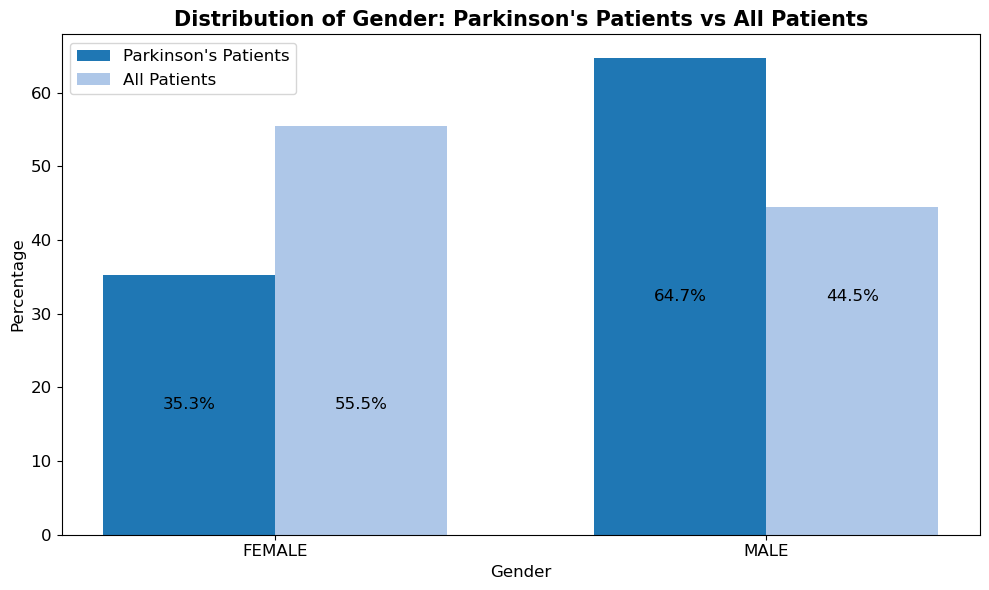

In [152]:
# Plotting the distribution of gender for PD patients vs. all patients
gender_counts = demographics['gender_source_value'].value_counts(normalize=True) * 100
gender_counts_all = demographics_all['gender_source_value'].value_counts(normalize=True)[:2] * 100 # Leaves out 'UNKNOWN' only 1 patient

# Combine percentages into a single DataFrame
combined_percentages = pd.DataFrame({
    "Parkinson's Patients": gender_counts,
    "All Patients": gender_counts_all
}).fillna(0)  # Fill NaN values with 0 in case some genders are missing in either group

# Plotting the percentage distribution of gender for both groups side by side
fig, ax = plt.subplots(figsize=(10, 6))

# Color map for the bar chart
colors = plt.cm.tab20.colors

# Calculate the width for each bar group
bar_width = 0.35

# Create the x positions for the bars
x = range(len(combined_percentages.index))

# Plot bars for Parkinson's patients
parkinsons_bars = ax.bar(x, combined_percentages["Parkinson's Patients"], width=bar_width, label="Parkinson's Patients", color=colors[0])

# Plot bars for all patients (shifted by bar_width)
all_patients_bars = ax.bar([i + bar_width for i in x], combined_percentages["All Patients"], width=bar_width, label="All Patients", color=colors[1])

# Set plot title and labels
ax.set_title("Distribution of Gender: Parkinson's Patients vs All Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Gender', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)
ax.legend(fontsize=12)

# Set the x-axis ticks to be at the center of the bars
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(combined_percentages.index, fontsize=12)

# Add the percentage values inside each bar
for bar1, bar2 in zip(parkinsons_bars, all_patients_bars):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    ax.text(bar1.get_x() + bar1.get_width() / 2, height1 / 2, f"{height1:.1f}%", ha='center', va='center', fontsize=12)
    ax.text(bar2.get_x() + bar2.get_width() / 2, height1 / 2, f"{height2:.1f}%", ha='center', va='center', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [153]:
demographics['gender_source_value'].value_counts(normalize=False) 

MALE      185
FEMALE    101
Name: gender_source_value, dtype: int64

In [154]:
demographics_all['gender_source_value'].value_counts(normalize=False) 

FEMALE     144929
MALE       116224
UNKNOWN         1
Name: gender_source_value, dtype: int64

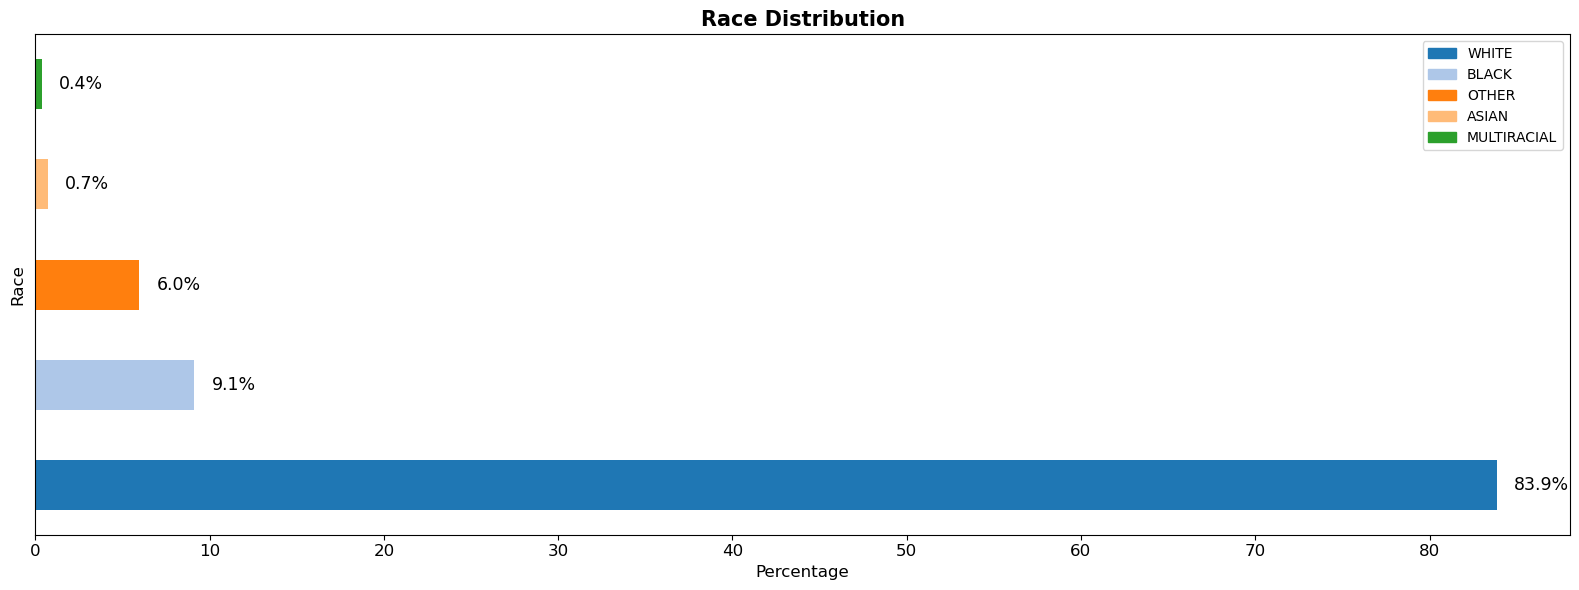

In [155]:
# Sample data (replace this with your actual data from the DataFrame)
race_counts = demographics['race_source_value'].value_counts(normalize=True) * 100

# Create a DataFrame from the data
race_df = pd.DataFrame({'Percentage': race_counts})

# Sort the DataFrame by percentage in descending order
race_df = race_df.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = race_df['Percentage'].plot(kind='barh', figsize=(16, 6), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title('Race Distribution', fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12)
plt.ylabel('Race', fontsize=12)

# Add labels to the right of each bar
for i, v in enumerate(race_df['Percentage']):
    plt.text(v + 1, i, f"{v:.1f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels
plt.yticks([])
plt.xticks(fontsize=12)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, race_counts.index)]

# Show the custom legend
plt.legend(handles=legend_patches, loc='best')

plt.tight_layout()
plt.show()

In [156]:
demographics['ethnicity_source_value'].value_counts()

NOT HISPANIC    272
HISPANIC         14
Name: ethnicity_source_value, dtype: int64

In [157]:
race_counts

WHITE          83.859649
BLACK           9.122807
OTHER           5.964912
ASIAN           0.701754
MULTIRACIAL     0.350877
Name: race_source_value, dtype: float64

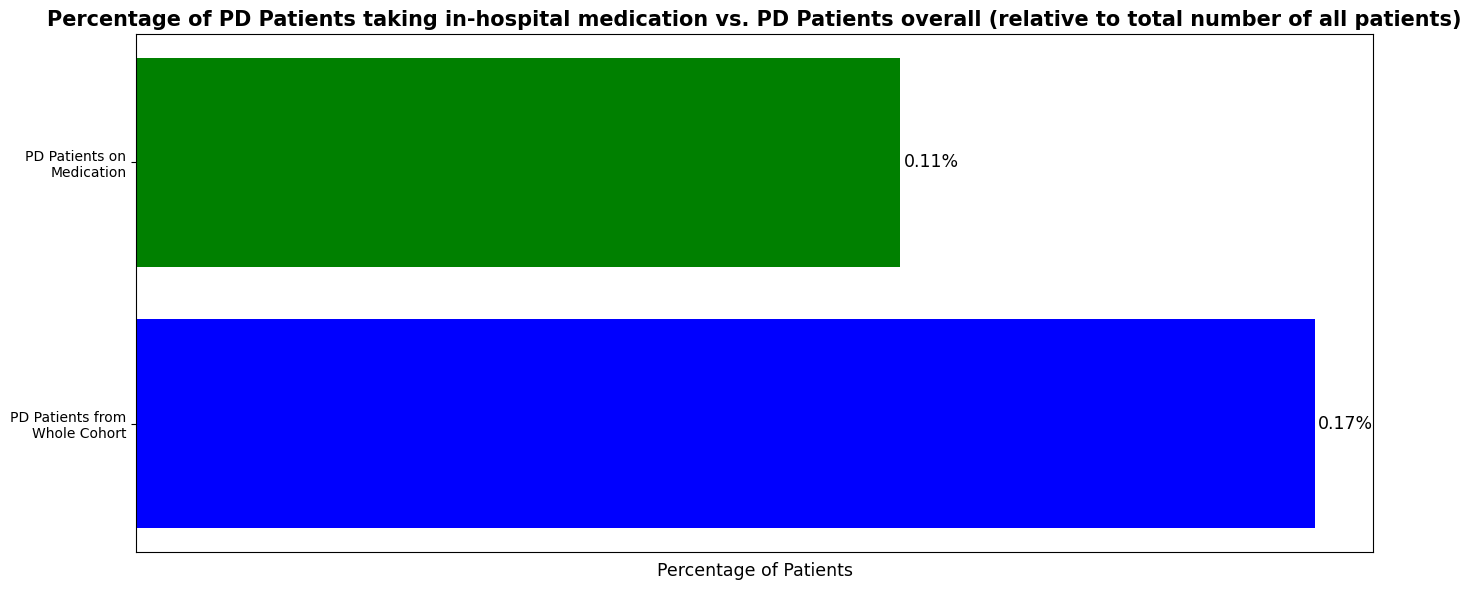

In [158]:
# Calculate the total number of patients in each dataset
total_patients_df = len(df['person_id'].unique())
total_patients_df_pd = len(df_pd['person_id'].unique())
total_patients_demographics_all = len(demographics_all['person_id'].unique())

# Calculate the percentage of PD patients from the whole cohort and PD patients on medication
percentage_pd_patients_df = (total_patients_df / total_patients_demographics_all) * 100
percentage_pd_patients = (total_patients_df_pd / total_patients_demographics_all) * 100

# Create the data for the horizontal bar plot
categories = ['PD Patients from\nWhole Cohort', 'PD Patients on\nMedication']
values = [percentage_pd_patients_df, percentage_pd_patients]

# Set the figure size for the horizontal bar plot
plt.figure(figsize=(14, 6))

# Plot the horizontal bar plot
plt.barh(categories, values, color=['blue', 'green'])
plt.xlabel('Percentage of Patients', fontsize=12.5)
plt.title('Percentage of PD Patients taking in-hospital medication vs. PD Patients overall (relative to total number of all patients)', fontsize=15, fontweight='bold')
plt.ylabel('')
plt.xticks([])

# Display the percentage values inside the bars
for i, v in enumerate(values):
    plt.text(v + 0.0005, i, f"{v:.2f}%", ha='left', va='center', fontsize=12.5)

# Display the plot
plt.tight_layout()
plt.show()

In [159]:
percentage_pd_patients_df

0.1688658799022799

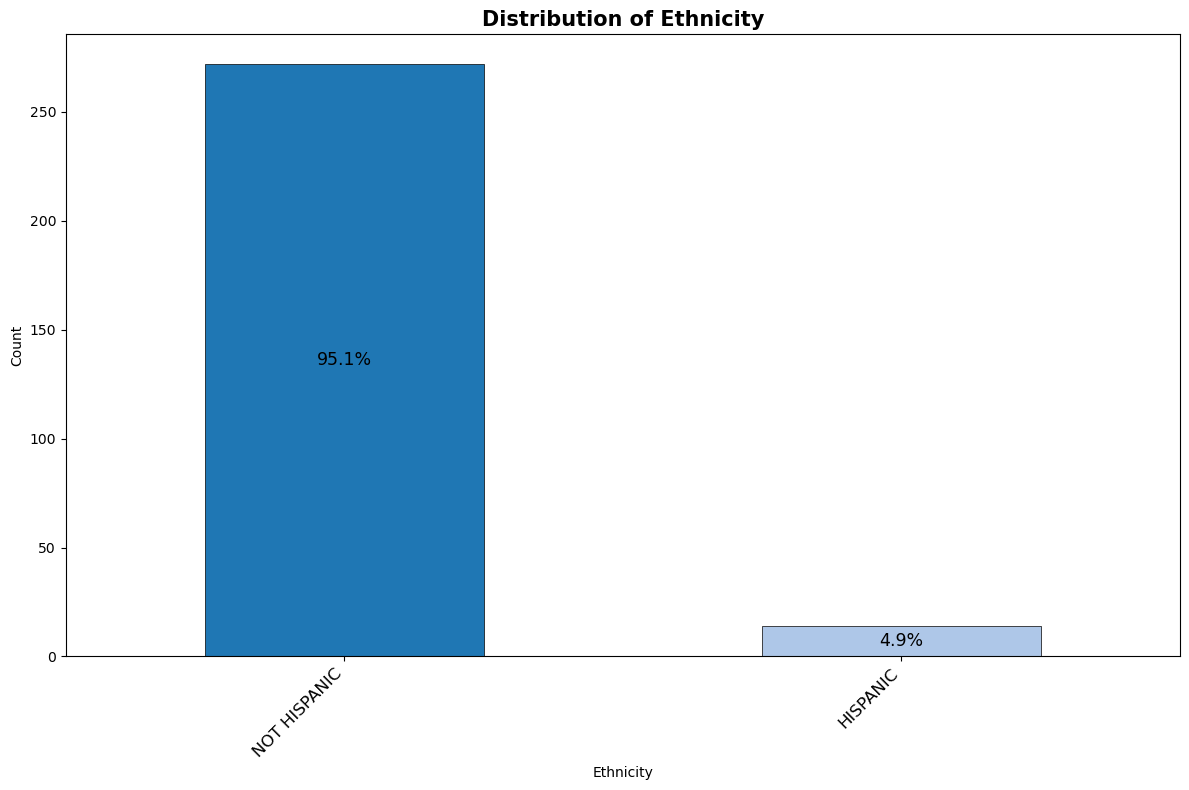

In [160]:
# Plotting value counts of race with percentages
ethnicity = demographics['ethnicity_source_value'].value_counts()
plt.figure(figsize=(12, 8))  # Adjust the values as per your desired size
labels = ethnicity.index
colors = plt.cm.tab20(np.arange(len(labels))) 
ax = ethnicity.plot(kind='bar', color=colors, edgecolor='black', linewidth=0.5)

# Calculate the percentages
total_count = ethnicity.sum()
percentages = [(count / total_count) * 100 for count in ethnicity]

# Display the percentages inside the bars
ax.bar_label(ax.containers[0], labels=[f"{percentage:.1f}%" for percentage in percentages], label_type='center', fontsize=12.5)

plt.title('Distribution of Ethnicity', fontsize=15, fontweight='bold')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.xticks(range(len(labels)), labels, rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

Actual actual way to deal with this lol

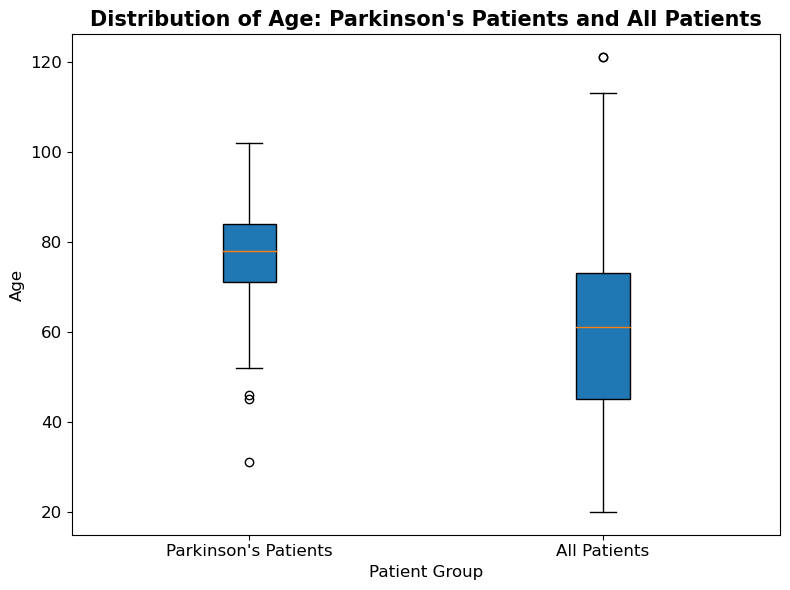

In [161]:
# Plotting the distribution of age for both groups using a box plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the box plot
ax.boxplot([demographics['age'], demographics_all['age']], labels=["Parkinson's Patients", "All Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Parkinson's Patients and All Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

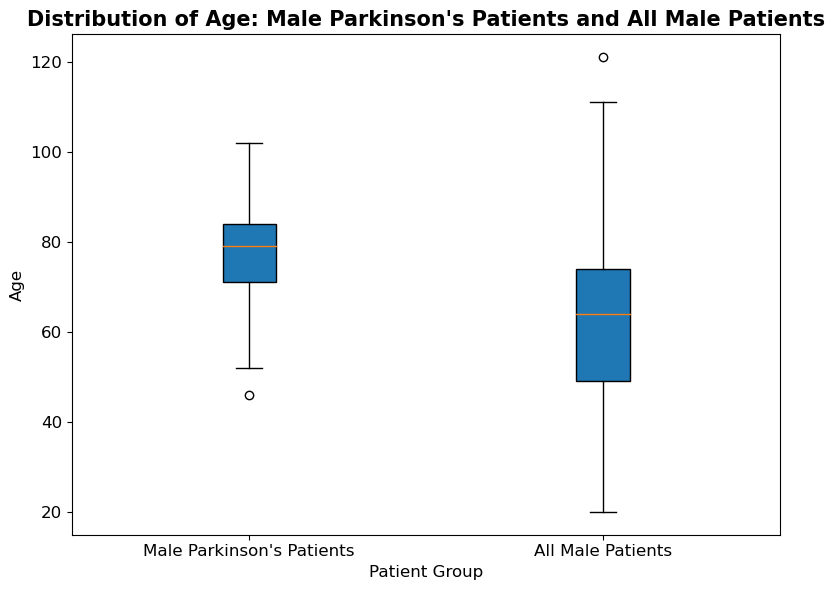

In [162]:
male_pd_patients_by_age = demographics[demographics['gender_source_value'] == 'MALE']['age']
male_pd_patients_by_age_all = demographics_all[demographics_all['gender_source_value'] == 'MALE']['age']# Plotting the distribution of age for both groups using a box plot

fig, ax = plt.subplots(figsize=(8, 6))
# Plot the box plot
ax.boxplot([male_pd_patients_by_age, male_pd_patients_by_age_all], labels=["Male Parkinson's Patients", "All Male Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Male Parkinson's Patients and All Male Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

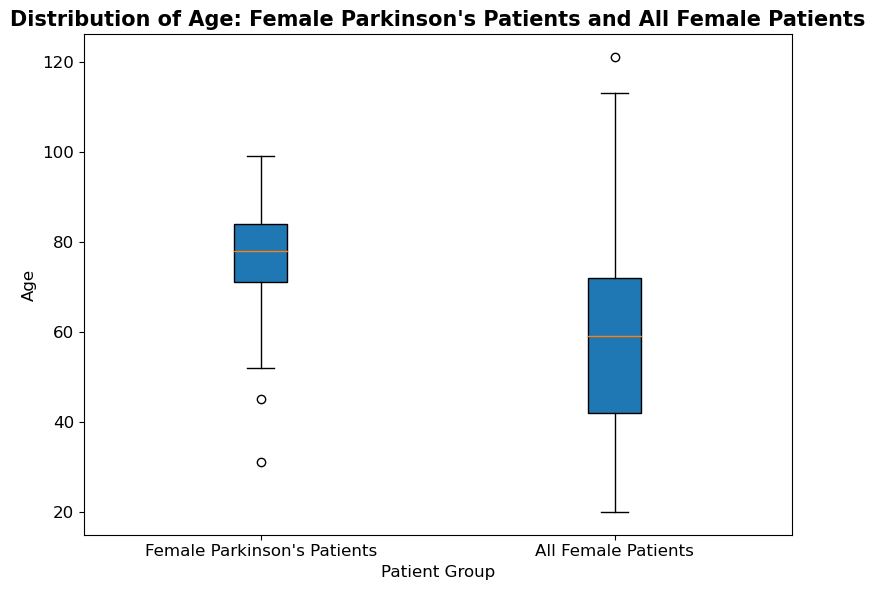

In [163]:
female_pd_patients_by_age = demographics[demographics['gender_source_value'] == 'FEMALE']['age']
female_pd_patients_by_age_all = demographics_all[demographics_all['gender_source_value'] == 'FEMALE']['age']

fig, ax = plt.subplots(figsize=(8, 6))
# Plot the box plot
ax.boxplot([female_pd_patients_by_age, female_pd_patients_by_age_all], labels=["Female Parkinson's Patients", "All Female Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Female Parkinson's Patients and All Female Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

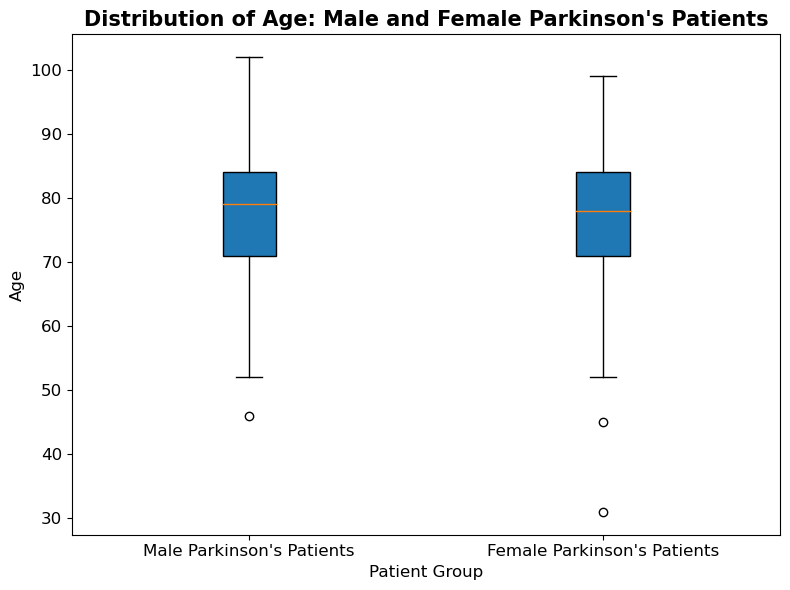

In [164]:
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the box plot
ax.boxplot([male_pd_patients_by_age, female_pd_patients_by_age], labels=["Male Parkinson's Patients", "Female Parkinson's Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Male and Female Parkinson's Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

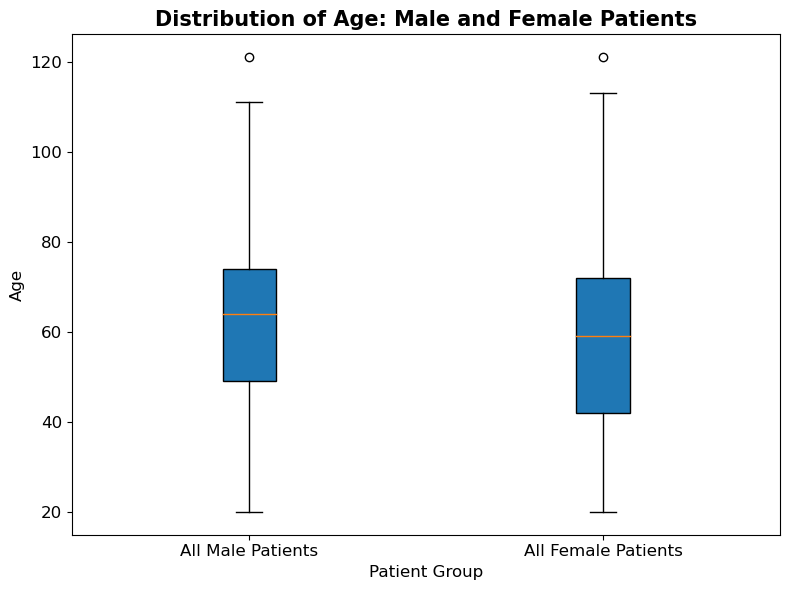

In [165]:
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the box plot
ax.boxplot([male_pd_patients_by_age_all, female_pd_patients_by_age_all], labels=["All Male Patients", "All Female Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Male and Female Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [166]:
pd_data.value_counts(normalize=True)

generic_name                           brand_name  dosage         
carbidopa-levodopa                     sinemet     25-100 mg          0.461783
                                       sinemet cr  25-100 mg          0.065150
benztropine                            cogentin    1 mg               0.064713
amantadine                             symmetrel   100 mg             0.059850
carbidopa-levodopa                     sinemet     25-250 mg          0.050000
pramipexole                            mirapex     0.25 mg            0.044701
benztropine                            cogentin    0.5 mg             0.035287
carbidopa-levodopa                     sinemet     10-100 mg          0.034040
                                                   12.5-50 mg         0.030985
                                       sinemet cr  50-200 mg          0.030050
benztropine                            cogentin    2 mg               0.014651
entacapone                             comtan      200 mg       

In [167]:
pd_data['brand_name'].value_counts(normalize=True)

sinemet       0.584601
cogentin      0.120324
sinemet cr    0.095200
symmetrel     0.074751
mirapex       0.069327
comtan        0.014963
artane        0.009726
azilect       0.007107
eldepryl      0.004302
duopa         0.003491
stalevo       0.003117
parlodel      0.003055
neupro        0.002681
gocovri       0.001995
parcopa       0.001372
rytary        0.001372
requip        0.000873
lodosyn       0.000686
tasmar        0.000623
dostinex      0.000249
apokyn        0.000187
Name: brand_name, dtype: float64

## Distribution of drugs

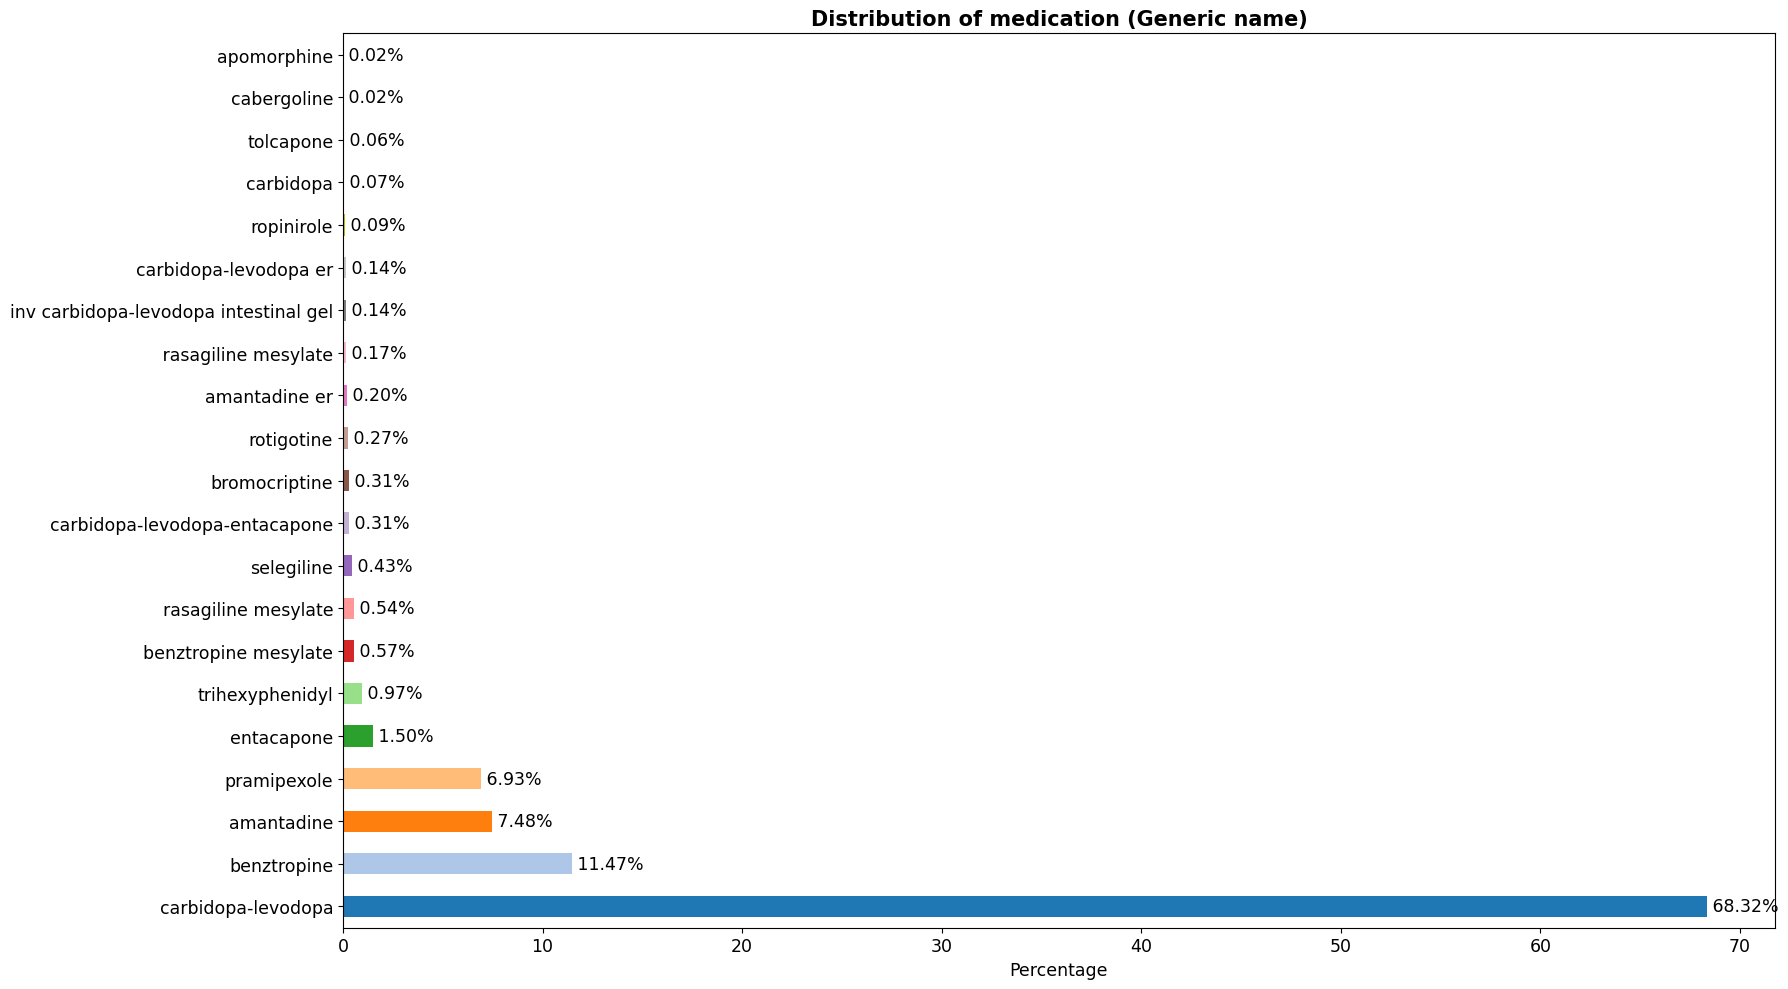

In [168]:
drug_distribution_count = df_pd['generic_name'].value_counts(normalize=True) * 100
drug_distribution = pd.DataFrame({'Percentage': drug_distribution_count})

# Sort the DataFrame by percentage in descending order
drug_distribution = drug_distribution.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = drug_distribution['Percentage'].plot(kind='barh', figsize=(18, 10), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title("Distribution of medication (Generic name)", fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12.5)
plt.ylabel('')

# Add labels to the right of each bar
for i, v in enumerate(drug_distribution['Percentage']):
    plt.text(v + 0.0005, i, ' ' + f"{v:.2f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels and set drug names in their original order
plt.yticks(range(len(drug_distribution)), drug_distribution.index, fontsize=12.5)

plt.xticks(fontsize=12.5)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, drug_distribution.index)]

# Show the custom legend
# plt.legend(handles=legend_patches, loc='best', fontsize=12.5)

plt.tight_layout()
plt.show()

In [169]:
len(pd_data) == len(df_pd)

True

In [170]:
df_pd.iloc[5187]

person_id                                                            250766
age                                                                      85
gender_source_value                                                  FEMALE
race_source_value                                                     WHITE
ethnicity_source_value                                         NOT HISPANIC
drug_source_value         {"med_display_name": "**carbidopa-levodopa 4.6...
drug_info                                                               NaN
generic_name                                             carbidopa-levodopa
brand_name                                                            duopa
dosage                                                        4.63-20 mg/ml
quantity                                                              100.0
sig                                                                   DAILY
route_source_value                                               PER J TUBE
dose_source_

In [171]:
pd_data.iloc[5187]

generic_name    carbidopa-levodopa
brand_name                   duopa
dosage               4.63-20 mg/ml
Name: 5187, dtype: object

In [172]:
len(pd_data[pd_data['brand_name'] == 'duopa']) == len(df_pd[df_pd['brand_name'] == 'duopa'])

True

<AxesSubplot: >

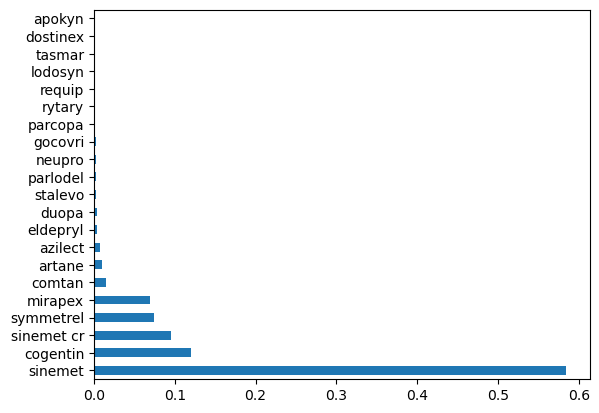

In [173]:
# vlalue_counts: Number of times each unique elements appears
medication_data = pd_data['brand_name'].value_counts(normalize=True)
medication_data.plot(kind='barh')

In [174]:
df_pd.groupby('brand_name')['person_id'].nunique()

brand_name
apokyn          1
artane          7
azilect        12
cogentin       22
comtan          8
dostinex        1
duopa           2
eldepryl        5
gocovri         1
lodosyn         4
mirapex        29
neupro          8
parcopa         2
parlodel        2
requip          3
rytary          2
sinemet       244
sinemet cr     82
stalevo         4
symmetrel      33
tasmar          1
Name: person_id, dtype: int64

In [175]:
df_pd['brand_name'].nunique()

21

In [176]:
df_pd.columns

Index(['person_id', 'age', 'gender_source_value', 'race_source_value',
       'ethnicity_source_value', 'drug_source_value', 'drug_info',
       'generic_name', 'brand_name', 'dosage', 'quantity', 'sig',
       'route_source_value', 'dose_source_value', 'dose_unit_source_value',
       'note_text'],
      dtype='object')

In [177]:
# Drug usage per patient
drug_percentage = df_pd.groupby('race_source_value')['person_id'].nunique()/ df_pd['person_id'].nunique()
drug_percentage.sort_values(ascending=False)
# drug_percentage

race_source_value
WHITE          0.835664
BLACK          0.090909
OTHER          0.059441
ASIAN          0.006993
MULTIRACIAL    0.003497
Name: person_id, dtype: float64

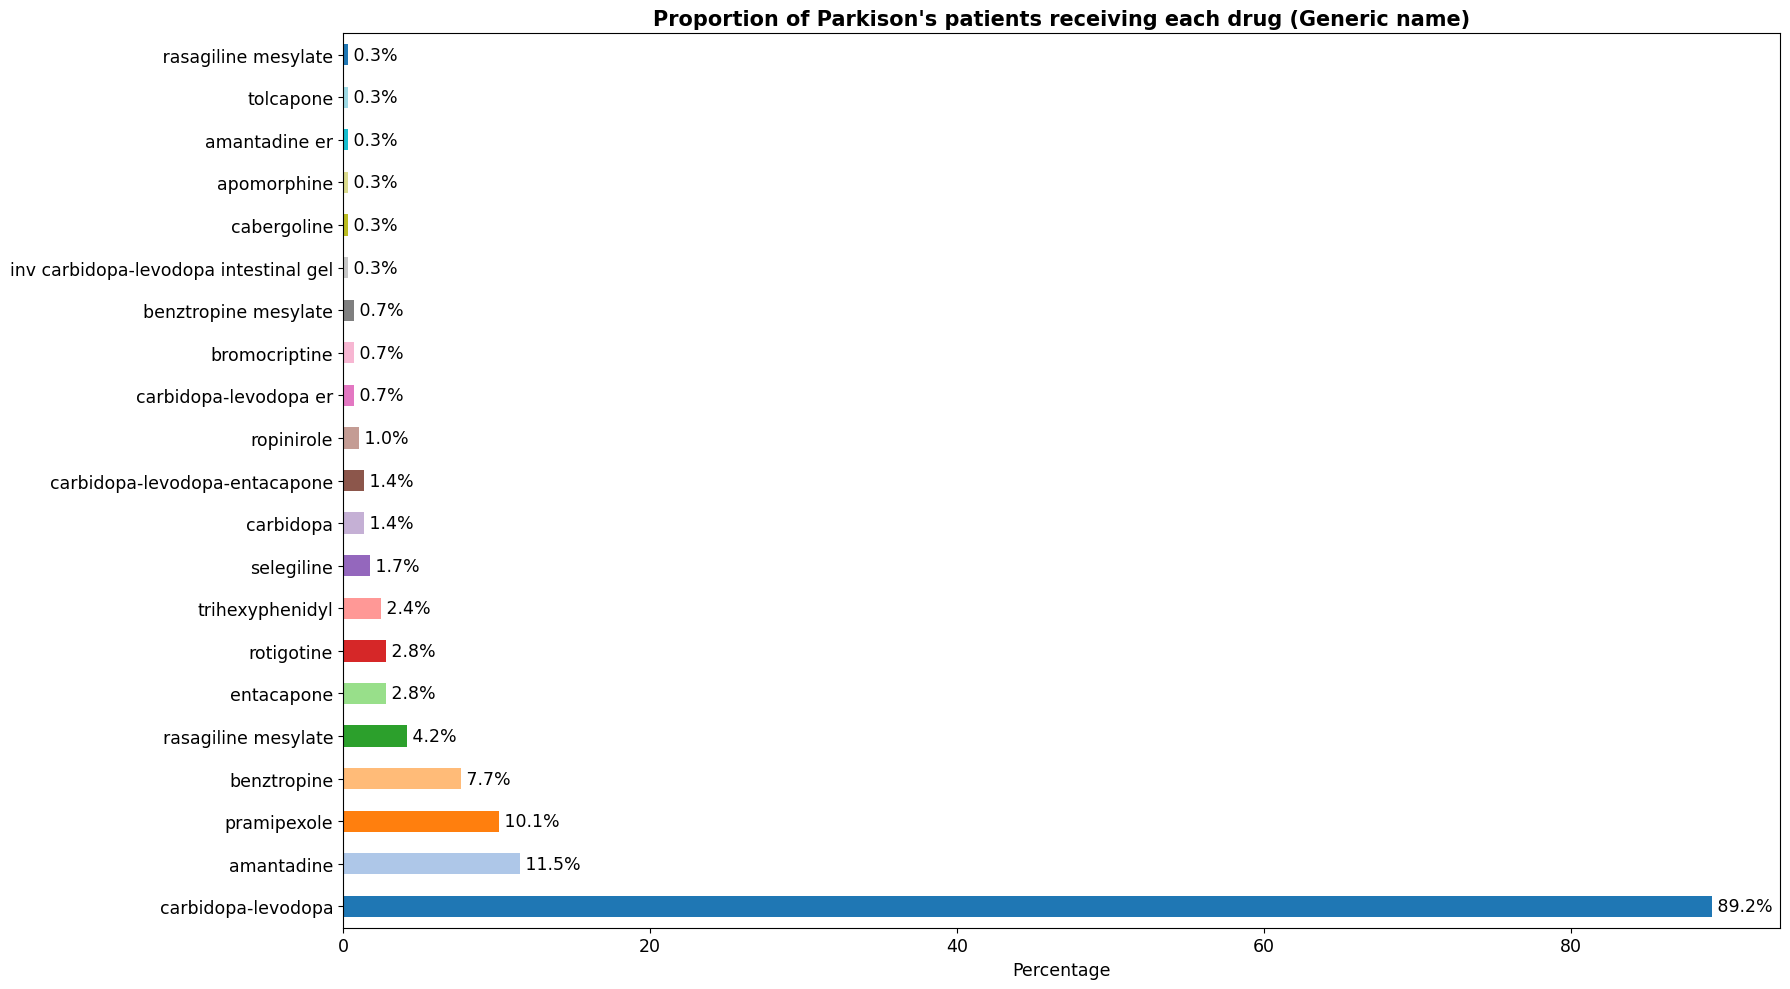

In [178]:
drug_percentage = df_pd.groupby('generic_name')['person_id'].nunique()/ df_pd['person_id'].nunique()
drug_popularity_count = drug_percentage * 100
drug_popularity = pd.DataFrame({'Percentage': drug_popularity_count})

# Sort the DataFrame by percentage in descending order
drug_popularity = drug_popularity.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = drug_popularity['Percentage'].plot(kind='barh', figsize=(18, 10), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title("Proportion of Parkison's patients receiving each drug (Generic name)", fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12.5)
plt.ylabel('')

# Add labels to the right of each bar
for i, v in enumerate(drug_popularity['Percentage']):
    plt.text(v + 0.0005, i, ' ' + f"{v:.1f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels and set drug names in their original order
plt.yticks(range(len(drug_popularity)), drug_popularity.index, fontsize=12.5)

plt.xticks(fontsize=12.5)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, drug_popularity.index)]

# Show the custom legend
# plt.legend(handles=legend_patches, loc='best', fontsize=12.5)

plt.tight_layout()
plt.show()


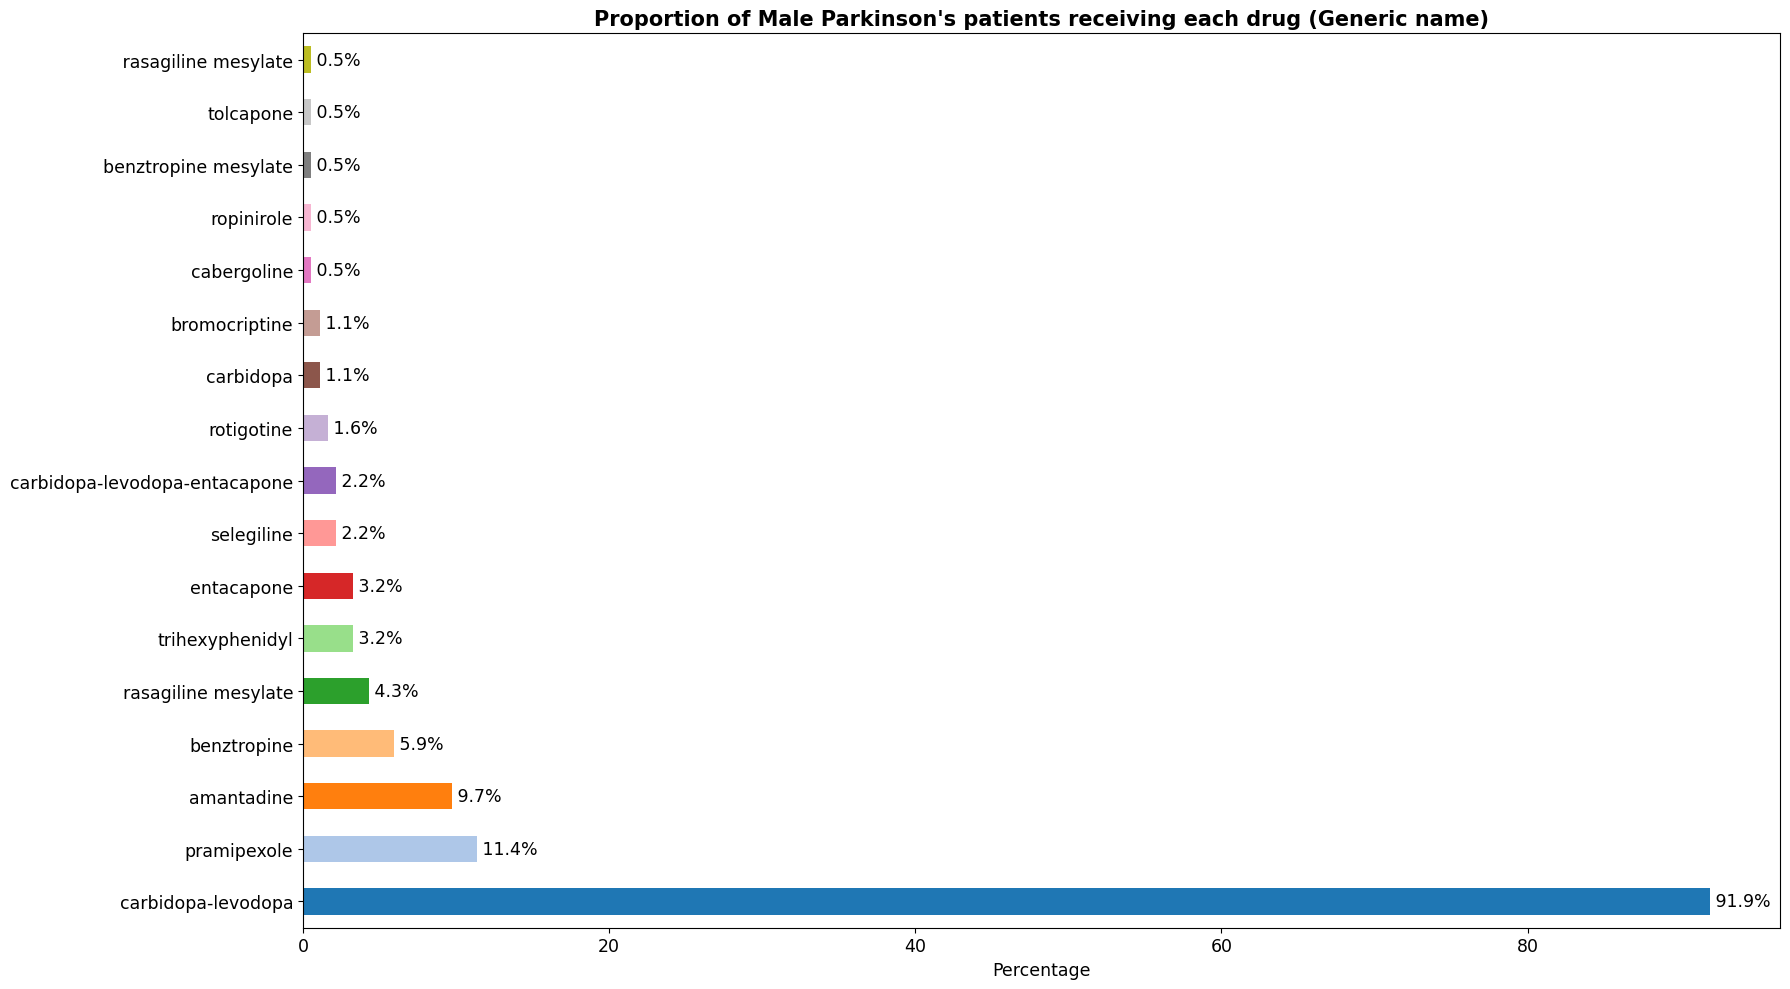

In [179]:
# Assuming df_pd is a DataFrame containing drug data and 'gender_source_value' is a column representing gender

# Filter the DataFrame for 'gender_source_value' == 'MALE'
male_pd = df_pd[df_pd['gender_source_value'] == 'MALE']

# Calculate the drug percentage for males
male_drug_percentage = male_pd.groupby('generic_name')['person_id'].nunique() / male_pd['person_id'].nunique()

# Calculate the percentage popularity of each drug for males
male_drug_popularity_count = male_drug_percentage * 100
male_drug_popularity = pd.DataFrame({'Percentage': male_drug_popularity_count})

# Sort the DataFrame by percentage in descending order
male_drug_popularity = male_drug_popularity.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = male_drug_popularity['Percentage'].plot(kind='barh', figsize=(18, 10), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title("Proportion of Male Parkinson's patients receiving each drug (Generic name)", fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12.5)
plt.ylabel('')

# Add labels to the right of each bar
for i, v in enumerate(male_drug_popularity['Percentage']):
    plt.text(v + 0.0005, i, ' ' + f"{v:.1f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels and set drug names in their original order
plt.yticks(range(len(male_drug_popularity)), male_drug_popularity.index, fontsize=12.5)

plt.xticks(fontsize=12.5)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, male_drug_popularity.index)]

# Show the custom legend
# plt.legend(handles=legend_patches, loc='best', fontsize=12.5)

plt.tight_layout()
plt.show()


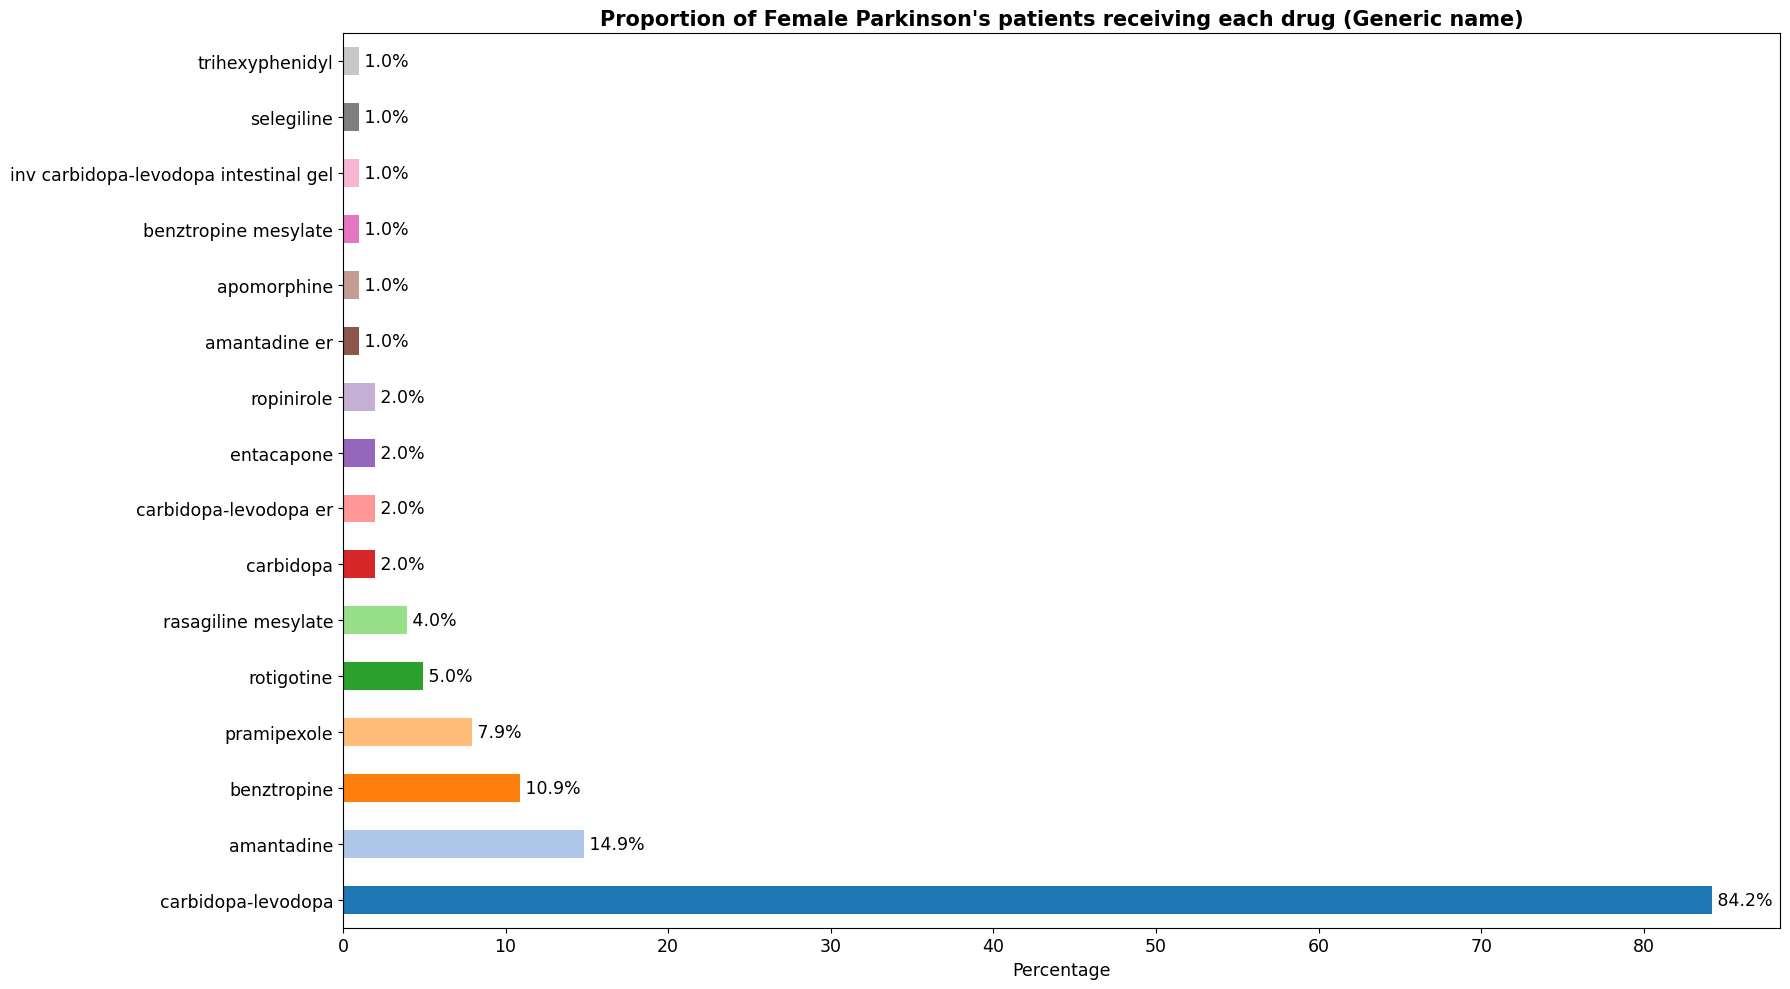

In [180]:
# Assuming df_pd is a DataFrame containing drug data and 'gender_source_value' is a column representing gender

# Filter the DataFrame for 'gender_source_value' == 'MALE'
female_pd = df_pd[df_pd['gender_source_value'] == 'FEMALE']

# Calculate the drug percentage for males
female_drug_percentage = female_pd.groupby('generic_name')['person_id'].nunique() / female_pd['person_id'].nunique()

# Calculate the percentage popularity of each drug for males
female_drug_popularity_count = female_drug_percentage * 100
female_drug_popularity = pd.DataFrame({'Percentage': female_drug_popularity_count})

# Sort the DataFrame by percentage in descending order
female_drug_popularity = female_drug_popularity.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = female_drug_popularity['Percentage'].plot(kind='barh', figsize=(18, 10), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title("Proportion of Female Parkinson's patients receiving each drug (Generic name)", fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12.5)
plt.ylabel('')

# Add labels to the right of each bar
for i, v in enumerate(female_drug_popularity['Percentage']):
    plt.text(v + 0.0005, i, ' ' + f"{v:.1f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels and set drug names in their original order
plt.yticks(range(len(female_drug_popularity)), female_drug_popularity.index, fontsize=12.5)

plt.xticks(fontsize=12.5)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, female_drug_popularity.index)]

# Show the custom legend
# plt.legend(handles=legend_patches, loc='best', fontsize=12.5)

plt.tight_layout()
plt.show()

In [181]:
female_drug_popularity['Percentage']

generic_name
carbidopa-levodopa                       84.158416
amantadine                               14.851485
benztropine                              10.891089
pramipexole                               7.920792
rotigotine                                4.950495
rasagiline mesylate                       3.960396
carbidopa                                 1.980198
carbidopa-levodopa er                     1.980198
entacapone                                1.980198
ropinirole                                1.980198
amantadine er                             0.990099
apomorphine                               0.990099
benztropine mesylate                      0.990099
inv carbidopa-levodopa intestinal gel     0.990099
selegiline                                0.990099
trihexyphenidyl                           0.990099
Name: Percentage, dtype: float64

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


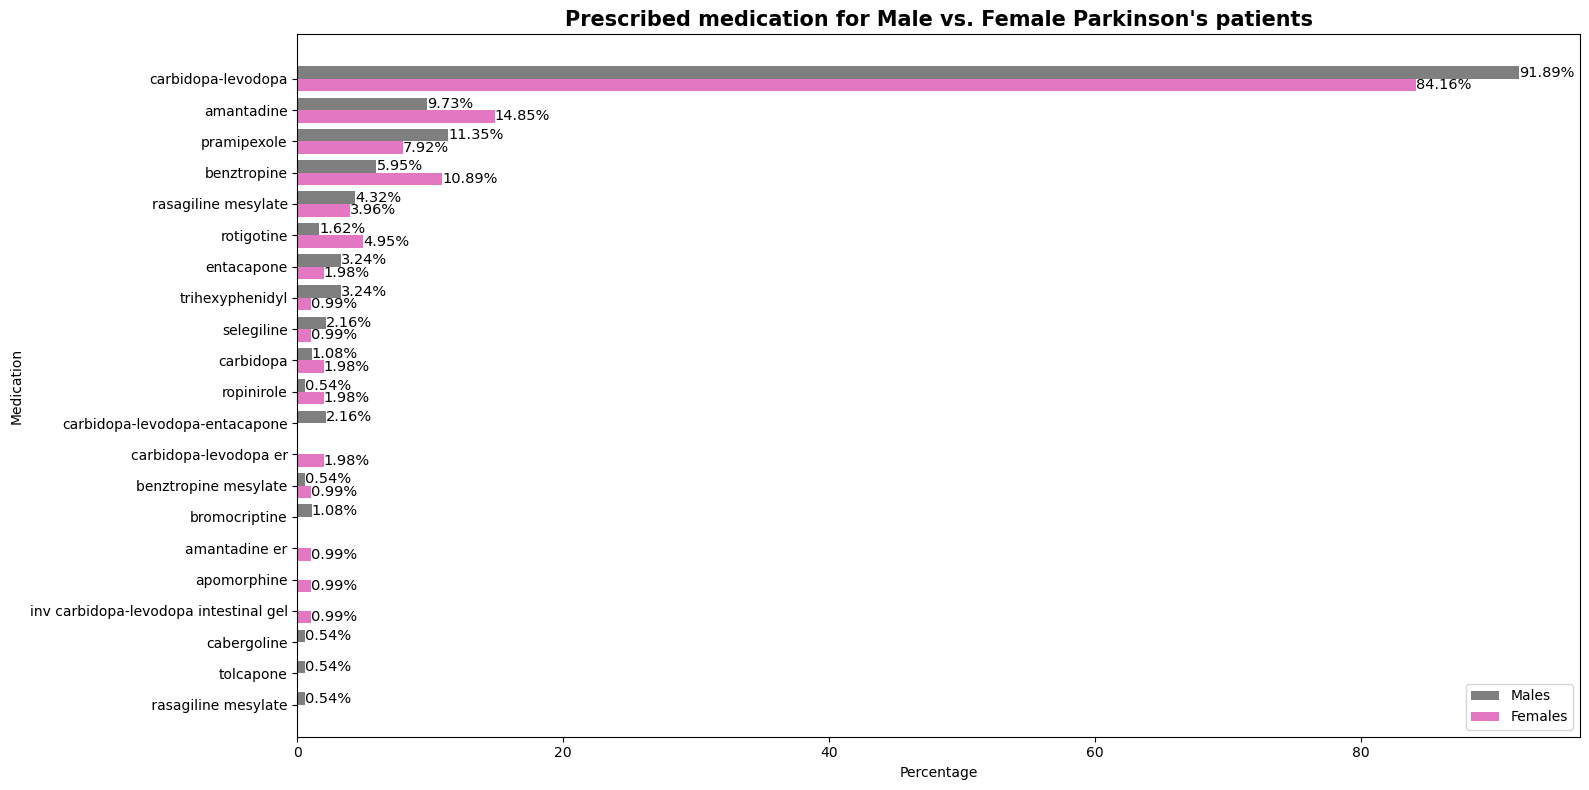

In [182]:
# Assuming you already have these variables as pandas Series
# male_drug_popularity and female_drug_popularity with 'Percentage' as the data and medication names as the index.

# Combine both male and female data for sorting
combined_data = pd.concat([male_drug_popularity, female_drug_popularity], axis=1)
combined_data.columns = ['Males', 'Females']

# Sort the medications based on the sum of percentages (sorting from higher to lower)
sorted_combined = combined_data.sum(axis=1).sort_values(ascending=False)

# Plotting the data as a horizontal bar plot
plt.figure(figsize=(16, 8))  # Adjust the figure size as needed

# Increase the width of the bars and adjust figure size for better spacing
width = 0.4

# Bar plot for males
ind_male = range(len(sorted_combined))
bars_male = plt.barh(ind_male, combined_data.loc[sorted_combined.index, 'Males'], height=width, label='Males', color='tab:gray')

# Bar plot for females
ind_female = [i + width for i in ind_male]
bars_female = plt.barh(ind_female, combined_data.loc[sorted_combined.index, 'Females'], height=width, label='Females', color='tab:pink')

# Adding percentages to the side of the bars
for i, val in enumerate(combined_data.loc[sorted_combined.index, 'Males']):
    plt.text(val, i, f'{val:.2f}%', va='center', fontsize=10.5, color='black')

for i, val in enumerate(combined_data.loc[sorted_combined.index, 'Females']):
    plt.text(val, i + width, f'{val:.2f}%', va='center', fontsize=10.5, color='black')

# Adding labels, titles, and customizing the plot
plt.xlabel('Percentage')
plt.ylabel('Medication')
plt.title('Prescribed medication for Male vs. Female Parkinson\'s patients', fontsize=15, fontweight='bold')
plt.yticks([i + width / 2 for i in ind_male], sorted_combined.index, fontsize=10)
plt.gca().invert_yaxis()
plt.legend(loc='lower right')  # Move the legend to upper right for better spacing
plt.tight_layout()
plt.show()


In [183]:
df_pd['generic_name'].value_counts(normalize=True) * 100

carbidopa-levodopa                       68.322943
benztropine                              11.465087
amantadine                                7.475062
pramipexole                               6.932668
entacapone                                1.496259
trihexyphenidyl                           0.972569
benztropine mesylate                      0.567332
rasagiline mesylate                       0.536160
selegiline                                0.430175
carbidopa-levodopa-entacapone             0.311721
bromocriptine                             0.305486
rotigotine                                0.268080
amantadine er                             0.199501
 rasagiline mesylate                      0.174564
inv carbidopa-levodopa intestinal gel     0.143392
carbidopa-levodopa er                     0.137157
ropinirole                                0.087282
carbidopa                                 0.068579
tolcapone                                 0.062344
cabergoline                    

In [184]:
drug_percentage

generic_name
 rasagiline mesylate                     0.003497
amantadine                               0.115385
amantadine er                            0.003497
apomorphine                              0.003497
benztropine                              0.076923
benztropine mesylate                     0.006993
bromocriptine                            0.006993
cabergoline                              0.003497
carbidopa                                0.013986
carbidopa-levodopa                       0.891608
carbidopa-levodopa er                    0.006993
carbidopa-levodopa-entacapone            0.013986
entacapone                               0.027972
inv carbidopa-levodopa intestinal gel    0.003497
pramipexole                              0.101399
rasagiline mesylate                      0.041958
ropinirole                               0.010490
rotigotine                               0.027972
selegiline                               0.017483
tolcapone                            

## Calculating LED (Levodopa Dose Equivalent) for Parkinson's patients

In [185]:
# sig stablished how the medication should be taken by the patient
formatted_series = df_pd['dose_source_value'].unique()
format_func = np.vectorize(lambda x: '{:.4}'.format(x))
bla = np.sort(format_func(formatted_series))
bla

array(['0.0', '0.125', '0.25', '0.5', '0.75', '1.0', '1.25', '1.5',
       '100.0', '137.0', '2.0', '2.5', '20.0', '200.0', '25.0', '3.0',
       '32.0', '4.0', '40.0', '5.0', '50.0', '8.0', 'nan'], dtype='<U5')

In [186]:
drug_exposure

person_id drug_exposure_start_datetime  \
0         261006          2021-04-11 10:53:00   
1         261006          2021-04-11 14:58:00   
2         261006          2021-04-11 17:32:00   
3         261006          2021-04-11 21:31:00   
4         261006          2021-04-12 02:52:00   
...          ...                          ...   
26941     175605          2017-09-20 13:51:00   
26942     175605          2017-09-20 21:09:00   
26943     175605          2017-09-21 08:50:00   
26944     175605          2017-09-19 10:08:00   
26945     175605          2017-09-20 08:17:00   

                                       drug_source_value  dose_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
1      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
2      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
3      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
4      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
...                                                  ...                ...   
26941  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
26942  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
26943  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
26944  {"med_display_name": "carbidopa-levodopa (SINE...                0.0   
26945  {"med_display_name": "carbidopa-levodopa (SINE...                0.0   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
0                     tablet               ORAL             40422623   
1                     tablet               ORAL             40422623   
2                     tablet               ORAL             40422623   
3                     tablet               ORAL             40422623   
4                     tablet               ORAL             40422623   
...                      ...                ...                  ...   
26941                 tablet               ORAL             27807633   
26942                 tablet               ORAL             27807633   
26943                 tablet               ORAL             27807633   
26944                 tablet               ORAL             27807633   
26945                 tablet               ORAL             27807633   

       visit_detail_id  
0            9880783.0  
1            9880783.0  
2            9880783.0  
3            9880783.0  
4            9880783.0  
...                ...  
26941        6375345.0  
26942        6375345.0  
26943        6375345.0  
26944        6375345.0  
26945        6375345.0  

[26946 rows x 8 columns]

In [187]:
rasagiline_index = pd_data_drug_exposure[pd_data_drug_exposure['dosage'] == '1mg'].index
pd_data_drug_exposure.loc[rasagiline_index, 'dosage'] = '1 mg'
pd_data_drug_exposure.iloc[rasagiline_index]['dosage']

10477    1 mg
10478    1 mg
Name: dosage, dtype: object

In [188]:
entacapone_index = pd_data_drug_exposure[pd_data_drug_exposure['dosage'] == '200mg'].index
pd_data_drug_exposure.loc[entacapone_index, 'dosage'] = '200 mg'
pd_data_drug_exposure.iloc[entacapone_index]['dosage']

13141    200 mg
13142    200 mg
13143    200 mg
13144    200 mg
13145    200 mg
13146    200 mg
13147    200 mg
13148    200 mg
13149    200 mg
13150    200 mg
13151    200 mg
13152    200 mg
13153    200 mg
13154    200 mg
13155    200 mg
13156    200 mg
13157    200 mg
13158    200 mg
13159    200 mg
13160    200 mg
13161    200 mg
13162    200 mg
13163    200 mg
13164    200 mg
13165    200 mg
13166    200 mg
13167    200 mg
13168    200 mg
13169    200 mg
13170    200 mg
Name: dosage, dtype: object

In [189]:
pd_data_drug_exposure['dosage'].unique()

array(['25-100 mg', '100 mg', '0.5 mg', '50-200 mg', '25-250 mg', '1 mg',
       '8 mg', '2 mg', '1.5 mg', '5 mg', '12.5-50 mg', '37.5-150-200 mg',
       '200 mg', '0.25 mg', '25 mg', '3 mg', '12.5-125 mg',
       '36.25-145 mg', '48.75-195 mg', '23.75-95 mg', '4 mg', '10-100 mg',
       '1 ml', '137 mg', '4.63-20 mg/ml', '12 mg', '0.125 mg', '50 mg',
       '5-20 mg/ml', '6 mg', '18.75-75-200 mg', '25-100-200 mg',
       '2.25 mg', '1.25-5 mg/ml', '2.5 mg', '0.75 mg', '50-200-200 mg',
       '1.25 mg'], dtype=object)

In [190]:
pd_data_drug_exposure['dosage'].unique()[0].split('-')[1].split()[0]

'100'

In [191]:
led_dose = []
for index, item in enumerate(pd_data_drug_exposure['dosage']):
    if '-' in item:
        dosage = item.split('-')[1].split()[0]
    else:
        dosage = item.split()[0]
    led_dose.append(dosage)

In [192]:
len(pd_data_drug_exposure)

26946

In [193]:
set(sorted(led_dose))

{'0.125',
 '0.25',
 '0.5',
 '0.75',
 '1',
 '1.25',
 '1.5',
 '100',
 '12',
 '125',
 '137',
 '145',
 '150',
 '195',
 '2',
 '2.25',
 '2.5',
 '20',
 '200',
 '25',
 '250',
 '3',
 '4',
 '5',
 '50',
 '6',
 '75',
 '8',
 '95'}

In [194]:
for index, item in enumerate(pd_data_drug_exposure['generic_name']):
    if 'levodopa-carbidopa' in item:
        print(item)

In [195]:
pd_data_drug_exposure['generic_name'].unique()

array(['carbidopa-levodopa', 'amantadine', 'benztropine', 'pramipexole',
       'ropinirole', 'benztropine mesylate', 'selegiline',
       'carbidopa-levodopa-entacapone', 'entacapone', 'trihexyphenidyl',
       'carbidopa', 'carbidopa-levodopa er', 'rasagiline mesylate',
       'rotigotine', 'apomorphine', 'amantadine er',
       ' rasagiline mesylate', 'inv carbidopa-levodopa intestinal gel',
       'inv carbidopa-levodopa intestinal gel pump', 'cabergoline',
       'pramipexole er', 'rasagiline', 'bromocriptine', 'tolcapone'],
      dtype=object)

In [196]:
pd_data_drug_exposure

generic_name brand_name     dosage
0      carbidopa-levodopa    sinemet  25-100 mg
1      carbidopa-levodopa    sinemet  25-100 mg
2      carbidopa-levodopa    sinemet  25-100 mg
3      carbidopa-levodopa    sinemet  25-100 mg
4      carbidopa-levodopa    sinemet  25-100 mg
...                   ...        ...        ...
26941  carbidopa-levodopa    sinemet  25-100 mg
26942  carbidopa-levodopa    sinemet  25-100 mg
26943  carbidopa-levodopa    sinemet  25-100 mg
26944  carbidopa-levodopa    sinemet  25-100 mg
26945  carbidopa-levodopa    sinemet  25-100 mg

[26946 rows x 3 columns]

In [197]:
drug_exposure

person_id drug_exposure_start_datetime  \
0         261006          2021-04-11 10:53:00   
1         261006          2021-04-11 14:58:00   
2         261006          2021-04-11 17:32:00   
3         261006          2021-04-11 21:31:00   
4         261006          2021-04-12 02:52:00   
...          ...                          ...   
26941     175605          2017-09-20 13:51:00   
26942     175605          2017-09-20 21:09:00   
26943     175605          2017-09-21 08:50:00   
26944     175605          2017-09-19 10:08:00   
26945     175605          2017-09-20 08:17:00   

                                       drug_source_value  dose_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
1      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
2      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
3      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
4      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
...                                                  ...                ...   
26941  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
26942  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
26943  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
26944  {"med_display_name": "carbidopa-levodopa (SINE...                0.0   
26945  {"med_display_name": "carbidopa-levodopa (SINE...                0.0   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
0                     tablet               ORAL             40422623   
1                     tablet               ORAL             40422623   
2                     tablet               ORAL             40422623   
3                     tablet               ORAL             40422623   
4                     tablet               ORAL             40422623   
...                      ...                ...                  ...   
26941                 tablet               ORAL             27807633   
26942                 tablet               ORAL             27807633   
26943                 tablet               ORAL             27807633   
26944                 tablet               ORAL             27807633   
26945                 tablet               ORAL             27807633   

       visit_detail_id  
0            9880783.0  
1            9880783.0  
2            9880783.0  
3            9880783.0  
4            9880783.0  
...                ...  
26941        6375345.0  
26942        6375345.0  
26943        6375345.0  
26944        6375345.0  
26945        6375345.0  

[26946 rows x 8 columns]

In [198]:
led_df = pd.concat([drug_exposure.iloc[:, 0:3], pd_data_drug_exposure, drug_exposure.iloc[:, 3:]], axis=1)

In [199]:
led_df.insert(loc=6, column="led_dose", value=led_dose)
led_df.insert(loc=3, column="drug_info", value=drug_info_drug_source_value)
# Properly handling the led_dose and drug_exposure_start_datetime colums
led_df['led_dose'] = pd.to_numeric(led_df['led_dose'], errors='coerce') # Coverting this column to a float type and handling uncommon values
led_df['drug_exposure_start_datetime'] = pd.to_datetime(led_df['drug_exposure_start_datetime'])

In [200]:
len(drug_exposure)

26946

In [201]:
len(pd_data_drug_exposure)

26946

In [202]:
drug_exposure

person_id drug_exposure_start_datetime  \
0         261006          2021-04-11 10:53:00   
1         261006          2021-04-11 14:58:00   
2         261006          2021-04-11 17:32:00   
3         261006          2021-04-11 21:31:00   
4         261006          2021-04-12 02:52:00   
...          ...                          ...   
26941     175605          2017-09-20 13:51:00   
26942     175605          2017-09-20 21:09:00   
26943     175605          2017-09-21 08:50:00   
26944     175605          2017-09-19 10:08:00   
26945     175605          2017-09-20 08:17:00   

                                       drug_source_value  dose_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
1      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
2      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
3      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
4      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
...                                                  ...                ...   
26941  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
26942  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
26943  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
26944  {"med_display_name": "carbidopa-levodopa (SINE...                0.0   
26945  {"med_display_name": "carbidopa-levodopa (SINE...                0.0   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
0                     tablet               ORAL             40422623   
1                     tablet               ORAL             40422623   
2                     tablet               ORAL             40422623   
3                     tablet               ORAL             40422623   
4                     tablet               ORAL             40422623   
...                      ...                ...                  ...   
26941                 tablet               ORAL             27807633   
26942                 tablet               ORAL             27807633   
26943                 tablet               ORAL             27807633   
26944                 tablet               ORAL             27807633   
26945                 tablet               ORAL             27807633   

       visit_detail_id  
0            9880783.0  
1            9880783.0  
2            9880783.0  
3            9880783.0  
4            9880783.0  
...                ...  
26941        6375345.0  
26942        6375345.0  
26943        6375345.0  
26944        6375345.0  
26945        6375345.0  

[26946 rows x 8 columns]

In [203]:
led_df

person_id drug_exposure_start_datetime  \
0         261006          2021-04-11 10:53:00   
1         261006          2021-04-11 14:58:00   
2         261006          2021-04-11 17:32:00   
3         261006          2021-04-11 21:31:00   
4         261006          2021-04-12 02:52:00   
...          ...                          ...   
26941     175605          2017-09-20 13:51:00   
26942     175605          2017-09-20 21:09:00   
26943     175605          2017-09-21 08:50:00   
26944     175605          2017-09-19 10:08:00   
26945     175605          2017-09-20 08:17:00   

                                       drug_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...   
1      {"med_display_name": "carbidopa-levodopa (SINE...   
2      {"med_display_name": "carbidopa-levodopa (SINE...   
3      {"med_display_name": "carbidopa-levodopa (SINE...   
4      {"med_display_name": "carbidopa-levodopa (SINE...   
...                                                  ...   
26941  {"med_display_name": "carbidopa-levodopa (SINE...   
26942  {"med_display_name": "carbidopa-levodopa (SINE...   
26943  {"med_display_name": "carbidopa-levodopa (SINE...   
26944  {"med_display_name": "carbidopa-levodopa (SINE...   
26945  {"med_display_name": "carbidopa-levodopa (SINE...   

                                               drug_info        generic_name  \
0      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
1      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
2      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
3      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
4      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
...                                                  ...                 ...   
26941  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
26942  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
26943  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
26944  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
26945  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   

      brand_name     dosage  led_dose  dose_source_value  \
0        sinemet  25-100 mg     100.0                2.0   
1        sinemet  25-100 mg     100.0                2.0   
2        sinemet  25-100 mg     100.0                2.0   
3        sinemet  25-100 mg     100.0                2.0   
4        sinemet  25-100 mg     100.0                2.0   
...          ...        ...       ...                ...   
26941    sinemet  25-100 mg     100.0                1.0   
26942    sinemet  25-100 mg     100.0                1.0   
26943    sinemet  25-100 mg     100.0                1.0   
26944    sinemet  25-100 mg     100.0                0.0   
26945    sinemet  25-100 mg     100.0                0.0   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
0                     tablet               ORAL             40422623   
1                     tablet               ORAL             40422623   
2                     tablet               ORAL             40422623   
3                     tablet               ORAL             40422623   
4                     tablet               ORAL             40422623   
...                      ...                ...                  ...   
26941                 tablet               ORAL             27807633   
26942                 tablet               ORAL             27807633   
26943                 tablet               ORAL             27807633   
26944                 tablet               ORAL             27807633   
26945                 tablet               ORAL             27807633   

       visit_detail_id  
0            9880783.0  
1            9880783.0  
2            9880783.0  
3            9880783.0  
4            9880783.0  


Esta bieeeeeeeeeeeeeeeeeeen y funciona

In [204]:
dl = [json.loads(x) for x in led_df[led_df['dose_source_value'] == 0.0]['drug_source_value']]
for index, tem in enumerate(dl):
    print(index, led_df['person_id'].iloc[index], dl[index]['mar_action'], led_df['drug_source_value'].iloc[index])
len(dl)

0 261006 HELD {"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
1 261006 HELD {"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
2 261006 HELD {"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
3 261006 HELD {"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
4 261006 HELD {"med_display_name": "

953

In [205]:
type(led_df[led_df['dose_source_value'] == 0.0]['drug_source_value'])

pandas.core.series.Series

In [206]:
type(led_df.loc[led_df['dose_source_value'] == 0.0, ['drug_source_value']])

pandas.core.frame.DataFrame

In [207]:
bla = [json.loads(x) for x in led_df[led_df['dose_source_value'] == 0.0]['drug_source_value']]
for index, item in enumerate(bla):
    print(bla[index]['mar_action'])

HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD


We lose 18.9% percent of patients because their medication was held

In [208]:
print(len(dl)*100/len(df_pd))

5.94139650872818


In [209]:
led_df['dosage'].unique()

array(['25-100 mg', '100 mg', '0.5 mg', '50-200 mg', '25-250 mg', '1 mg',
       '8 mg', '2 mg', '1.5 mg', '5 mg', '12.5-50 mg', '37.5-150-200 mg',
       '200 mg', '0.25 mg', '25 mg', '3 mg', '12.5-125 mg',
       '36.25-145 mg', '48.75-195 mg', '23.75-95 mg', '4 mg', '10-100 mg',
       '1 ml', '137 mg', '4.63-20 mg/ml', '12 mg', '0.125 mg', '50 mg',
       '5-20 mg/ml', '6 mg', '18.75-75-200 mg', '25-100-200 mg',
       '2.25 mg', '1.25-5 mg/ml', '2.5 mg', '0.75 mg', '50-200-200 mg',
       '1.25 mg'], dtype=object)

In [210]:
pd_data_drug_exposure[pd_data_drug_exposure['dosage'] == '0.5 mg']

generic_name brand_name  dosage
88     benztropine   cogentin  0.5 mg
89     benztropine   cogentin  0.5 mg
90     benztropine   cogentin  0.5 mg
91     benztropine   cogentin  0.5 mg
92     benztropine   cogentin  0.5 mg
...            ...        ...     ...
24965   ropinirole     requip  0.5 mg
24966   ropinirole     requip  0.5 mg
24967   ropinirole     requip  0.5 mg
24968   ropinirole     requip  0.5 mg
24969   ropinirole     requip  0.5 mg

[743 rows x 3 columns]

In [211]:
pd_data_drug_exposure['dosage'].unique()

array(['25-100 mg', '100 mg', '0.5 mg', '50-200 mg', '25-250 mg', '1 mg',
       '8 mg', '2 mg', '1.5 mg', '5 mg', '12.5-50 mg', '37.5-150-200 mg',
       '200 mg', '0.25 mg', '25 mg', '3 mg', '12.5-125 mg',
       '36.25-145 mg', '48.75-195 mg', '23.75-95 mg', '4 mg', '10-100 mg',
       '1 ml', '137 mg', '4.63-20 mg/ml', '12 mg', '0.125 mg', '50 mg',
       '5-20 mg/ml', '6 mg', '18.75-75-200 mg', '25-100-200 mg',
       '2.25 mg', '1.25-5 mg/ml', '2.5 mg', '0.75 mg', '50-200-200 mg',
       '1.25 mg'], dtype=object)

In [212]:
led_df['dosage'].unique()

array(['25-100 mg', '100 mg', '0.5 mg', '50-200 mg', '25-250 mg', '1 mg',
       '8 mg', '2 mg', '1.5 mg', '5 mg', '12.5-50 mg', '37.5-150-200 mg',
       '200 mg', '0.25 mg', '25 mg', '3 mg', '12.5-125 mg',
       '36.25-145 mg', '48.75-195 mg', '23.75-95 mg', '4 mg', '10-100 mg',
       '1 ml', '137 mg', '4.63-20 mg/ml', '12 mg', '0.125 mg', '50 mg',
       '5-20 mg/ml', '6 mg', '18.75-75-200 mg', '25-100-200 mg',
       '2.25 mg', '1.25-5 mg/ml', '2.5 mg', '0.75 mg', '50-200-200 mg',
       '1.25 mg'], dtype=object)

In [213]:
set(led_dose)

{'0.125',
 '0.25',
 '0.5',
 '0.75',
 '1',
 '1.25',
 '1.5',
 '100',
 '12',
 '125',
 '137',
 '145',
 '150',
 '195',
 '2',
 '2.25',
 '2.5',
 '20',
 '200',
 '25',
 '250',
 '3',
 '4',
 '5',
 '50',
 '6',
 '75',
 '8',
 '95'}

In [214]:
led_df['generic_name'].unique()

array(['carbidopa-levodopa', 'amantadine', 'benztropine', 'pramipexole',
       'ropinirole', 'benztropine mesylate', 'selegiline',
       'carbidopa-levodopa-entacapone', 'entacapone', 'trihexyphenidyl',
       'carbidopa', 'carbidopa-levodopa er', 'rasagiline mesylate',
       'rotigotine', 'apomorphine', 'amantadine er',
       ' rasagiline mesylate', 'inv carbidopa-levodopa intestinal gel',
       'inv carbidopa-levodopa intestinal gel pump', 'cabergoline',
       'pramipexole er', 'rasagiline', 'bromocriptine', 'tolcapone'],
      dtype=object)

In [215]:
led_df[(led_df['brand_name'] == 'rytary') & (led_df['generic_name'] == 'carbidopa-levodopa')]

person_id drug_exposure_start_datetime  \
3633     256628          2017-01-24 01:00:00   
3634     256628          2017-01-31 21:33:00   

                                      drug_source_value  \
3633  {"med_display_name": "carbidopa-levodopa (SINE...   
3634  {"med_display_name": "carbidopa-levodopa (SINE...   

                                              drug_info        generic_name  \
3633  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
3634  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   

     brand_name     dosage  led_dose  dose_source_value  \
3633     rytary  25-100 mg     100.0                1.0   
3634     rytary  25-100 mg     100.0                1.0   

     dose_unit_source_value route_source_value  visit_occurrence_id  \
3633                 tablet               ORAL             39519189   
3634                 tablet               ORAL             39519190   

      visit_detail_id  
3633        9635043.0  
3634        9635045.0

In [216]:
led_df[led_df['dose_unit_source_value'] == 'tablet']['dose_source_value']

0        2.0
1        2.0
2        2.0
3        2.0
4        2.0
        ... 
26941    1.0
26942    1.0
26943    1.0
26944    0.0
26945    0.0
Name: dose_source_value, Length: 20044, dtype: float64

In [217]:
led_df[led_df['dose_unit_source_value'] == 'each']#['dose_source_value'].unique()

person_id drug_exposure_start_datetime  \
8143     245457          2013-03-15 23:27:00   
8144     245457          2013-03-16 23:39:00   
8145     245457          2013-03-17 23:15:00   
8146     245457          2013-03-18 23:00:00   
8147     245457          2013-03-19 23:26:00   
8148     245457          2013-03-21 00:00:00   
8149     245457          2013-03-21 23:14:00   

                                      drug_source_value  \
8143  {"med_display_name": "Inv levodopa-carbidopa i...   
8144  {"med_display_name": "Inv levodopa-carbidopa i...   
8145  {"med_display_name": "Inv levodopa-carbidopa i...   
8146  {"med_display_name": "Inv levodopa-carbidopa i...   
8147  {"med_display_name": "Inv levodopa-carbidopa i...   
8148  {"med_display_name": "Inv levodopa-carbidopa i...   
8149  {"med_display_name": "Inv levodopa-carbidopa i...   

                                            drug_info  \
8143  Inv levodopa-carbidopa intestinal gel pump stop   
8144  Inv levodopa-carbidopa intestinal gel pump stop   
8145  Inv levodopa-carbidopa intestinal gel pump stop   
8146  Inv levodopa-carbidopa intestinal gel pump stop   
8147  Inv levodopa-carbidopa intestinal gel pump stop   
8148  Inv levodopa-carbidopa intestinal gel pump stop   
8149  Inv levodopa-carbidopa intestinal gel pump stop   

                                    generic_name brand_name      dosage  \
8143  inv carbidopa-levodopa intestinal gel pump      duopa  5-20 mg/ml   
8144  inv carbidopa-levodopa intestinal gel pump      duopa  5-20 mg/ml   
8145  inv carbidopa-levodopa intestinal gel pump      duopa  5-20 mg/ml   
8146  inv carbidopa-levodopa intestinal gel pump      duopa  5-20 mg/ml   
8147  inv carbidopa-levodopa intestinal gel pump      duopa  5-20 mg/ml   
8148  inv carbidopa-levodopa intestinal gel pump      duopa  5-20 mg/ml   
8149  inv carbidopa-levodopa intestinal gel pump      duopa  5-20 mg/ml   

      led_dose  dose_source_value dose_unit_source_value route_source_value  \
8143      20.0                NaN                   each         PEG-J TUBE   
8144      20.0                NaN                   each         PEG-J TUBE   
8145      20.0                NaN                   each         PEG-J TUBE   
8146      20.0                NaN                   each         PEG-J TUBE   
8147      20.0                NaN                   each         PEG-J TUBE   
8148      20.0                0.0                   each         PEG-J TUBE   
8149      20.0                0.0                   each         PEG-J TUBE   

      visit_occurrence_id  visit_detail_id  
8143             37041564        8941399.0  
8144             37041564        8941399.0  
8145             37041564        8941399.0  
8146             37041564        8941399.0  
8147             37041564        8941399.0  
8148             37041564        8941399.0  
8149             37041564        8941399.0

In [218]:
led_df[led_df['dose_unit_source_value'] != 'tablet'].sample(20)

person_id drug_exposure_start_datetime  \
13917     216583          2014-09-03 12:35:00   
22489     201023          2017-09-16 20:37:00   
2162      258045          2020-05-16 20:09:00   
18035     208220          2017-07-21 20:33:00   
21253     201787          2018-03-03 08:42:00   
25118     186327          2017-12-21 08:15:00   
94        260996          2013-02-18 20:10:00   
19989     203021          2020-08-03 19:02:00   
90        260996          2013-02-16 20:09:00   
2483      257075          2018-05-11 09:06:00   
23808     194868          2014-10-11 08:18:00   
21778     201787          2018-03-08 20:46:00   
19076     205200          2016-10-04 21:07:00   
14098     216583          2017-09-05 13:07:00   
4611      253781          2013-10-01 20:28:00   
18163     206828          2017-11-02 08:07:00   
18587     205200          2017-03-28 20:47:00   
11587     220195          2019-12-19 21:26:00   
9556      229161          2015-04-29 14:00:00   
19029     205200          2016-09-14 20:51:00   

                                       drug_source_value  \
13917  {"med_display_name": "pramipexole (MIRAPEX) ta...   
22489  {"med_display_name": "entacapone (COMTAN) tabl...   
2162   {"med_display_name": "rOPINIRole (REQUIP) tabl...   
18035  {"med_display_name": "pramipexole (MIRAPEX) ta...   
21253  {"med_display_name": "amantadine (SYMMETREL) s...   
25118  {"med_display_name": "rotigotine (NEUPRO) 2 MG...   
94     {"med_display_name": "benztropine (COGENTIN) t...   
19989  {"med_display_name": "carbidopa-levodopa (SINE...   
90     {"med_display_name": "benztropine (COGENTIN) t...   
2483   {"med_display_name": "amantadine (SYMMETREL) c...   
23808  {"med_display_name": "amantadine (SYMMETREL) c...   
21778  {"med_display_name": "entacapone (COMTAN) tabl...   
19076  {"med_display_name": "rOPINIRole (REQUIP) tabl...   
14098  {"med_display_name": "pramipexole (MIRAPEX) ta...   
4611   {"med_display_name": "benztropine (COGENTIN) t...   
18163  {"med_display_name": "benztropine (COGENTIN) t...   
18587  {"med_display_name": "amantadine (SYMMETREL) c...   
11587  {"med_display_name": "entacapone (COMTAN) tabl...   
9556   {"med_display_name": "amantadine (SYMMETREL) s...   
19029  {"med_display_name": "rOPINIRole (REQUIP) tabl...   

                                               drug_info        generic_name  \
13917              pramipexole (MIRAPEX) tablet 0.125 mg         pramipexole   
22489                  entacapone (COMTAN) tablet 200 mg          entacapone   
2162                  rOPINIRole (REQUIP) tablet 0.25 mg          ropinirole   
18035                  pramipexole (MIRAPEX) tablet 1 mg         pramipexole   
21253             amantadine (SYMMETREL) solution 100 mg          amantadine   
25118        rotigotine (NEUPRO) 2 MG/24HR patch 1 patch          rotigotine   
94                  benztropine (COGENTIN) tablet 0.5 mg         benztropine   
19989  carbidopa-levodopa (SINEMET) 1.25-5 mg/mL oral...  carbidopa-levodopa   
90                  benztropine (COGENTIN) tablet 0.5 mg         benztropine   
2483               amantadine (SYMMETREL) capsule 100 mg          amantadine   
23808              amantadine (SYMMETREL) capsule 100 mg          amantadine   
21778                  entacapone (COMTAN) tablet 200 mg          entacapone   
19076                 rOPINIRole (REQUIP) tablet 0.25 mg          ropinirole   
14098              pramipexole (MIRAPEX) tablet 0.125 mg         pramipexole   
4611                  benztropine (COGENTIN) tablet 1 mg         benztropine   
18163               benztropine (COGENTIN) tablet 0.5 mg         benztropine   
18587              amantadine (SYMMETREL) capsule 100 mg          amantadine   
11587                  entacapone (COMTAN) tablet 200 mg          entacapone   
9556              amantadine (SYMMETREL) solution 100 mg          amantadine   
19029                 rOPINIRole (REQUIP) tablet 0.25 mg          ropinirole   

      brand_name        dosage  led

Difference betwen ryrary and duopa??
Rytary is carbidopa-levodopa extended release and suopa is carbidopa-levodopa enteral suspension

In [219]:
sorted(led_df['generic_name'].unique())

[' rasagiline mesylate',
 'amantadine',
 'amantadine er',
 'apomorphine',
 'benztropine',
 'benztropine mesylate',
 'bromocriptine',
 'cabergoline',
 'carbidopa',
 'carbidopa-levodopa',
 'carbidopa-levodopa er',
 'carbidopa-levodopa-entacapone',
 'entacapone',
 'inv carbidopa-levodopa intestinal gel',
 'inv carbidopa-levodopa intestinal gel pump',
 'pramipexole',
 'pramipexole er',
 'rasagiline',
 'rasagiline mesylate',
 'ropinirole',
 'rotigotine',
 'selegiline',
 'tolcapone',
 'trihexyphenidyl']

Setting conversion factors for Parkinson's drugs and calculating LED

In [220]:
# Conversion factors from: https://movementdisorders.onlinelibrary.wiley.com/doi/full/10.1002/mds.29410
conversion_factors = {
    'amantadine': 1.0,
    'amantadine er': 1.25, 
    'apomorphine': 10.0,
    # trihexyphenidyl and benztropine aren't as unified but the paper proposes a conversion factor of 1
    'benztropine': 1.0,
    'benztropine mesylate': 1.0,
    'bromocriptine': 10.0,
    'cabergoline': 66.7,
    'carbidopa-levodopa': 1.0,
    'inv carbidopa-levodopa intestinal gel': 1.0,
    'inv carbidopa-levodopa intestinal gel pump': 1.0,
    'carbidopa': 0.1,
    'carbidopa-levodopa er': 0.5,
    'carbidopa-levodopa-entacapone': 1.33,
    'entacapone': 1.33, # Double-check this
    'pramipexole': 100.0,
    'pramipexole er': 100.0,
    'trihexyphenidyl': 1.0,
    'rasagiline': 100.0,
    ' rasagiline mesylate': 100.0,
    'ropinirole': 20.0,
    'rotigotine': 30.0, 
    'selegiline': 10.0, # All the rows relating to selegiline are oral
    'tolcapone': 1.5,
    'ropinirole': 0.5,
}

# Convert 'drug_exposure_start_datetime' to datetime format
def calculate_led(row):
    """ The logic goes as follows: We will map the conversion factors to the generic_name found in the led_df dataframe. All of the generic_names are contained into the dictionary.
    We check the led_dose calculated. If it's equal to the dose_source_value it means that the medication is probably carbidopa-levodopa, so we will skip it and we do that by setting dose_source_value to 1.
    That way when we multiply it will be as if nothing happened.

    Then we check if dose_source_value is zero. If that happends, then that drug was not administered but held (look at mar_action in the drug_source column). If it's zero we put the equivalent to np.nan into that row

    If everything goes well and the dose_source_value is actually something we can work with, then the led will be the multiplication of the dose_sourve_value, the led_dose and the conversion factor

    If the dose_source_value is something we can't work with, the led will exclude that info from the multiplication.

    At the end we apply the function into a new column called led. 
    """
    dose_source_value = row['dose_source_value']
    led_dose = row['led_dose']
    conversion_factor = conversion_factors.get(row['generic_name'], 0)
    if led_dose == dose_source_value:
        dose_source_value = 1.0
    if dose_source_value == 0.0:
        return None
    if pd.notna(dose_source_value):
        return dose_source_value * row['led_dose'] * conversion_factor
    else:
        return row['led_dose'] * conversion_factor

led_df['led'] = led_df.apply(calculate_led, axis=1)

Adding diagnosis date

In [221]:
diagnosis_date = pd.read_csv('data/DIAGNOSIS_DATE.csv')
diagnosis_date["diagnosis_date"] = pd.to_datetime(diagnosis_date["diagnosis_date"], format='%Y-%m-%d')

led_df = led_df.merge(diagnosis_date, on='person_id', how='inner')
led_df = led_df[['person_id', 'drug_exposure_start_datetime', 'diagnosis_date', 'drug_source_value', 'drug_info', 'generic_name', 'brand_name', 'dosage', 'led_dose', 'dose_source_value', 'dose_unit_source_value', 'route_source_value','visit_occurrence_id', 'visit_detail_id', 'led']]

Mean LED by person

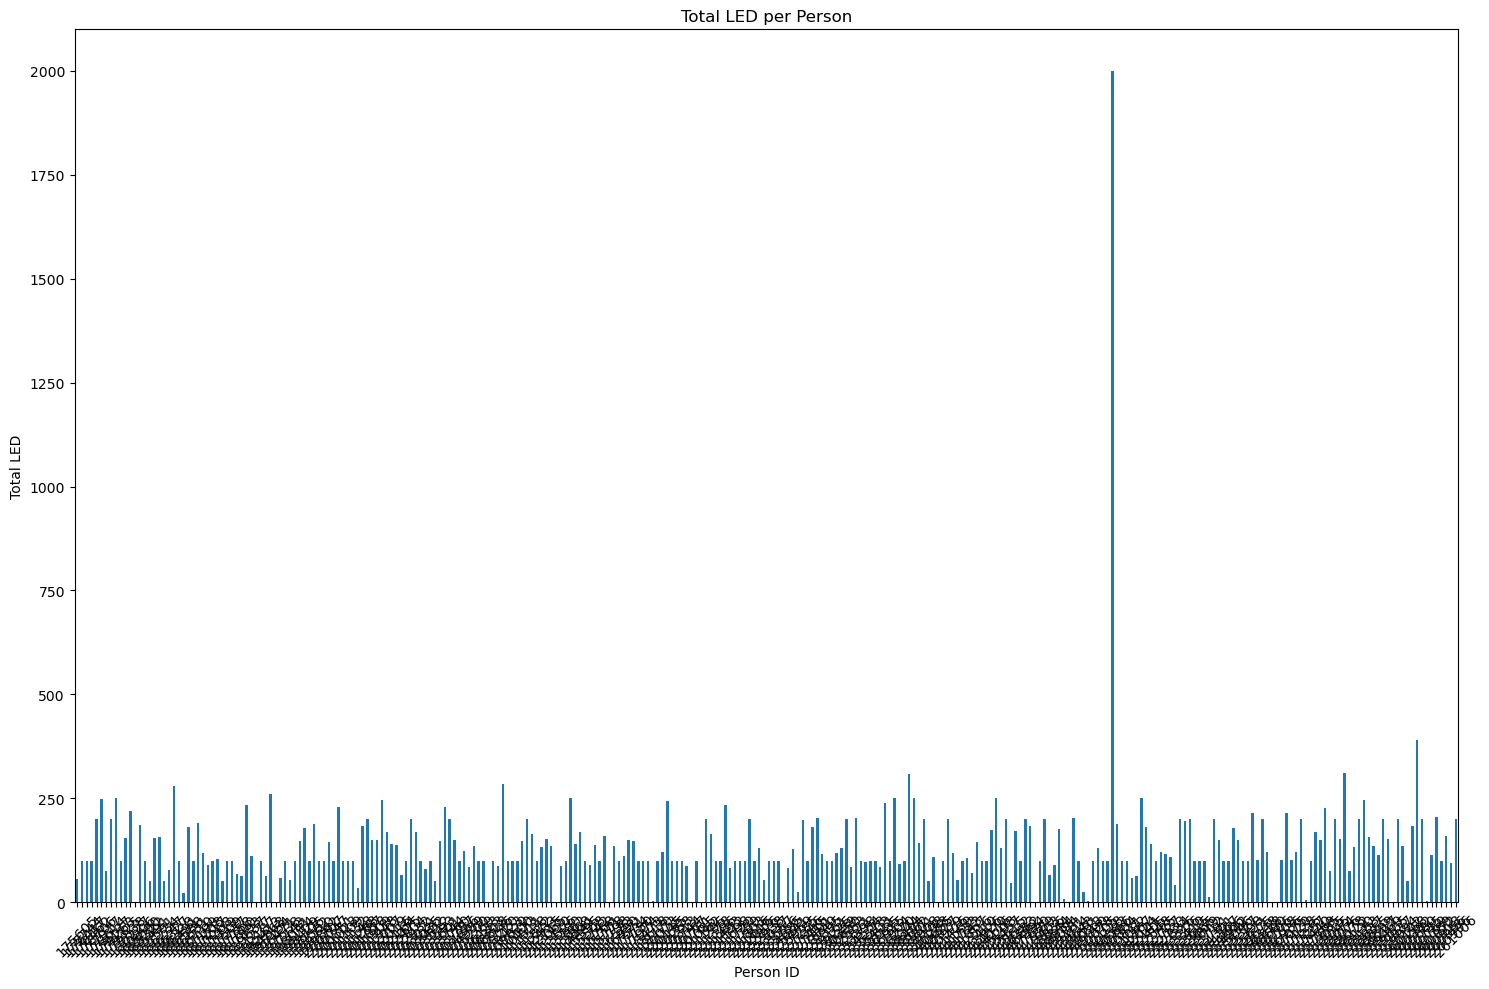

In [222]:
led_by_person = led_df.groupby('person_id')['led'].mean()
# Plot the data
plt.figure(figsize=(15, 10))
led_by_person.plot(kind='bar')
plt.xlabel('Person ID')
plt.ylabel('Total LED')
plt.title('Total LED per Person')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [223]:
# We use the aggreagte function to find the min and max date of drugs being administered
patient_stay = led_df.groupby('person_id')['drug_exposure_start_datetime'].agg(['min', 'max']).reset_index()
# Compute the mean LED per patiient
mean_led_per_patient = led_df.groupby('person_id')['led'].mean().reset_index() # Mean LED per patient
mean_led_per_administration_date= led_df.groupby(['person_id', led_df['drug_exposure_start_datetime'].dt.date])['led'].mean().reset_index()
mean_led_per_drug = led_df.groupby(['person_id', led_df['generic_name']])['led'].mean().reset_index()
mean_led_per_visit = led_df.groupby(['person_id', led_df['visit_occurrence_id']])['led'].mean().reset_index()
# Assing the mean LED to the DataFrame
patient_stay['mean_led_per_patient'] = mean_led_per_patient['led']
patient_stay['mean_led_per_administration_date'] = mean_led_per_administration_date['led']
patient_stay['mean_led_per_drug'] = mean_led_per_drug['led']
patient_stay['mean_led_per_visit'] = mean_led_per_visit['led']
# Compute and add the patient stay in format days and hours, and patient stay in years
patient_stay['stay'] = patient_stay['max'] - patient_stay['min']
patient_stay['stay_in_years'] = (patient_stay['max'] - patient_stay['min']) / np.timedelta64(1, 'Y')
# Sort values by patient stay
patient_stay = patient_stay[['person_id', 'stay', 'stay_in_years', 'mean_led_per_patient', 'mean_led_per_administration_date', 'mean_led_per_drug', 'mean_led_per_visit' ]].sort_values(by=['stay_in_years'], ascending=False)

In [224]:
mean_led_per_patient

person_id         led
0       175605   56.687898
1       175744  100.000000
2       176417  100.000000
3       176462  100.000000
4       176706  200.000000
..         ...         ...
281     260872  203.846154
282     260918  100.000000
283     260956  159.375000
284     260996   95.336883
285     261006  200.000000

[286 rows x 2 columns]

In [225]:
mean_led_per_administration_date

person_id drug_exposure_start_datetime    led
0        175605                   2017-05-31  100.0
1        175605                   2017-06-01  100.0
2        175605                   2017-06-02  100.0
3        175605                   2017-06-06   50.0
4        175605                   2017-06-07   50.0
...         ...                          ...    ...
6547     260996                   2013-05-28  100.0
6548     260996                   2013-05-29  100.0
6549     260996                   2013-05-30  100.0
6550     261006                   2021-04-11  200.0
6551     261006                   2021-04-12  200.0

[6552 rows x 3 columns]

In [226]:
mean_led_per_drug

person_id        generic_name         led
0       175605  carbidopa-levodopa   56.687898
1       175744  carbidopa-levodopa  100.000000
2       176417  carbidopa-levodopa  100.000000
3       176462         pramipexole  100.000000
4       176706  carbidopa-levodopa  200.000000
..         ...                 ...         ...
431     260956  carbidopa-levodopa  159.375000
432     260996          amantadine  100.000000
433     260996         benztropine    0.500000
434     260996  carbidopa-levodopa  105.335157
435     261006  carbidopa-levodopa  200.000000

[436 rows x 3 columns]

In [227]:
mean_led_per_visit

person_id  visit_occurrence_id         led
0       175605             27807630   62.121212
1       175605             27807631   50.000000
2       175605             27807633   60.416667
3       175744             27928378  100.000000
4       176417             28045048  100.000000
..         ...                  ...         ...
844     260956             40422289  150.000000
845     260996             40422545  110.714286
846     260996             40422547   84.040594
847     260996             40422548  107.594937
848     261006             40422623  200.000000

[849 rows x 3 columns]

In [228]:
patient_stay

person_id               stay  stay_in_years  mean_led_per_patient  \
111     216583 3348 days 19:06:00       9.168692            136.266748   
229     253410 3308 days 21:15:00       9.059421            195.942408   
98      213120 3169 days 17:29:00       8.678422            135.135135   
104     215395 2974 days 14:46:00       8.144220            168.950820   
142     222938 2901 days 22:36:00       7.945246             54.424569   
..         ...                ...            ...                   ...   
3       176462    0 days 03:23:00       0.000386            100.000000   
72      203402    0 days 02:23:00       0.000272             80.000000   
213     250583    0 days 00:00:00       0.000000            100.000000   
125     220744    0 days 00:00:00       0.000000            100.000000   
129     221162    0 days 00:00:00       0.000000                   NaN   

     mean_led_per_administration_date  mean_led_per_drug  mean_led_per_visit  
111                             100.0         200.000000          200.000000  
229                             212.5          99.206349            0.500000  
98                              250.0         107.692308           55.681818  
104                             250.0         100.000000          137.500000  
142                             250.0         135.135135          182.436264  
..                                ...                ...                 ...  
3                                50.0         100.000000          100.000000  
72                              100.0           0.500000          100.000000  
213                             250.0           0.500000          112.954545  
125                             250.0         100.000000          200.000000  
129                             250.0         100.000000          231.333333  

[286 rows x 7 columns]

In [361]:
years_of_stay = patient_stay[patient_stay['stay_in_years'] >= 5]
years_of_stay_person_id = years_of_stay['person_id'].tolist()

In [339]:
len(years_of_stay)

101

In [231]:
mean_led_per_administration_date

person_id drug_exposure_start_datetime    led
0        175605                   2017-05-31  100.0
1        175605                   2017-06-01  100.0
2        175605                   2017-06-02  100.0
3        175605                   2017-06-06   50.0
4        175605                   2017-06-07   50.0
...         ...                          ...    ...
6547     260996                   2013-05-28  100.0
6548     260996                   2013-05-29  100.0
6549     260996                   2013-05-30  100.0
6550     261006                   2021-04-11  200.0
6551     261006                   2021-04-12  200.0

[6552 rows x 3 columns]

In [362]:
len(years_of_stay_person_id)

21

Mean LED per administration date

In [233]:
mean_led_per_administration_date

person_id drug_exposure_start_datetime    led
0        175605                   2017-05-31  100.0
1        175605                   2017-06-01  100.0
2        175605                   2017-06-02  100.0
3        175605                   2017-06-06   50.0
4        175605                   2017-06-07   50.0
...         ...                          ...    ...
6547     260996                   2013-05-28  100.0
6548     260996                   2013-05-29  100.0
6549     260996                   2013-05-30  100.0
6550     261006                   2021-04-11  200.0
6551     261006                   2021-04-12  200.0

[6552 rows x 3 columns]

In [234]:
diagnosis_date

person_id diagnosis_date condition_poa
0       261006     2019-06-06           NaN
1       261006     2019-06-26          True
2       260996     2015-10-21           NaN
3       260996     2016-03-22          True
4       260956     2015-10-07           NaN
..         ...            ...           ...
521     176417     2017-06-29          True
522     175744     2017-07-21           NaN
523     175744     2017-12-14          True
524     175605     2016-12-28           NaN
525     175605     2016-12-28          True

[526 rows x 3 columns]

In [235]:
led_df['diagnosis_date']

0       2019-06-06
1       2019-06-26
2       2019-06-06
3       2019-06-26
4       2019-06-06
           ...    
52112   2016-12-28
52113   2016-12-28
52114   2016-12-28
52115   2016-12-28
52116   2016-12-28
Name: diagnosis_date, Length: 52117, dtype: datetime64[ns]

In [236]:
for x,y in diagnosis_date[diagnosis_date['person_id'] == 253410][['diagnosis_date', 'condition_poa']].values:
    print(x,y)

2016-03-31 00:00:00 nan
2016-03-14 00:00:00 True


In [237]:
diagnosis_date[diagnosis_date['person_id'] == 212715]

person_id diagnosis_date condition_poa
349     212715     2018-10-24           NaN
350     212715     2018-10-24          True

In [239]:
led_df[led_df['person_id'] == years_of_stay_person_id[0]].sort_values(by='drug_exposure_start_datetime')

person_id drug_exposure_start_datetime diagnosis_date  \
23487     216583          2011-05-31 17:00:00     2015-10-14   
23488     216583          2011-05-31 17:00:00     2017-08-24   
23490     216583          2011-05-31 21:00:00     2017-08-24   
23489     216583          2011-05-31 21:00:00     2015-10-14   
23491     216583          2011-06-01 08:20:00     2015-10-14   
...          ...                          ...            ...   
24512     216583          2020-07-31 12:06:00     2017-08-24   
26245     216583          2020-07-31 12:06:00     2015-10-14   
26246     216583          2020-07-31 12:06:00     2017-08-24   
27420     216583          2020-07-31 12:06:00     2017-08-24   
24511     216583          2020-07-31 12:06:00     2015-10-14   

                                       drug_source_value  \
23487  {"med_display_name": "carbidopa-levodopa (SINE...   
23488  {"med_display_name": "carbidopa-levodopa (SINE...   
23490  {"med_display_name": "carbidopa-levodopa (SINE...   
23489  {"med_display_name": "carbidopa-levodopa (SINE...   
23491  {"med_display_name": "carbidopa-levodopa (SINE...   
...                                                  ...   
24512  {"med_display_name": "carbidopa-levodopa (SINE...   
26245  {"med_display_name": "entacapone (COMTAN) tabl...   
26246  {"med_display_name": "entacapone (COMTAN) tabl...   
27420  {"med_display_name": "pramipexole (MIRAPEX) ta...   
24511  {"med_display_name": "carbidopa-levodopa (SINE...   

                                               drug_info        generic_name  \
23487  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
23488  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
23490  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
23489  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
23491  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
...                                                  ...                 ...   
24512  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
26245                  entacapone (COMTAN) tablet 200 mg          entacapone   
26246                  entacapone (COMTAN) tablet 200 mg          entacapone   
27420              pramipexole (MIRAPEX) tablet 0.125 mg         pramipexole   
24511  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   

      brand_name     dosage  led_dose  dose_source_value  \
23487    sinemet  25-100 mg   100.000              1.000   
23488    sinemet  25-100 mg   100.000              1.000   
23490    sinemet  25-100 mg   100.000              1.000   
23489    sinemet  25-100 mg   100.000              1.000   
23491    sinemet  25-100 mg   100.000              1.000   
...          ...        ...       ...                ...   
24512    sinemet  25-100 mg   100.000              1.000   
26245     comtan     200 mg   200.000            200.000   
26246     comtan     200 mg   200.000            200.000   
27420    mirapex   0.125 mg     0.125              0.125   
24511    sinemet  25-100 mg   100.000              1.000   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
23487                 tablet               ORAL             33394388   
23488                 tablet               ORAL             33394388   
23490                 tablet               ORAL             33394388   
23489                 tablet               ORAL             33394388   
23491                 tablet               ORAL             33394388   
...                      ...                ...                  ...   
24512                 tablet               ORAL             33418398   
26245                     mg               ORAL             33418398   
26246                     mg               ORAL             33418398   
27420                     mg               ORAL             33418398   
24511                 tablet               

In [240]:
led_df

person_id drug_exposure_start_datetime diagnosis_date  \
0         261006          2021-04-11 10:53:00     2019-06-06   
1         261006          2021-04-11 10:53:00     2019-06-26   
2         261006          2021-04-11 14:58:00     2019-06-06   
3         261006          2021-04-11 14:58:00     2019-06-26   
4         261006          2021-04-11 17:32:00     2019-06-06   
...          ...                          ...            ...   
52112     175605          2017-09-21 08:50:00     2016-12-28   
52113     175605          2017-09-19 10:08:00     2016-12-28   
52114     175605          2017-09-19 10:08:00     2016-12-28   
52115     175605          2017-09-20 08:17:00     2016-12-28   
52116     175605          2017-09-20 08:17:00     2016-12-28   

                                       drug_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...   
1      {"med_display_name": "carbidopa-levodopa (SINE...   
2      {"med_display_name": "carbidopa-levodopa (SINE...   
3      {"med_display_name": "carbidopa-levodopa (SINE...   
4      {"med_display_name": "carbidopa-levodopa (SINE...   
...                                                  ...   
52112  {"med_display_name": "carbidopa-levodopa (SINE...   
52113  {"med_display_name": "carbidopa-levodopa (SINE...   
52114  {"med_display_name": "carbidopa-levodopa (SINE...   
52115  {"med_display_name": "carbidopa-levodopa (SINE...   
52116  {"med_display_name": "carbidopa-levodopa (SINE...   

                                               drug_info        generic_name  \
0      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
1      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
2      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
3      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
4      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
...                                                  ...                 ...   
52112  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
52113  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
52114  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
52115  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
52116  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   

      brand_name     dosage  led_dose  dose_source_value  \
0        sinemet  25-100 mg     100.0                2.0   
1        sinemet  25-100 mg     100.0                2.0   
2        sinemet  25-100 mg     100.0                2.0   
3        sinemet  25-100 mg     100.0                2.0   
4        sinemet  25-100 mg     100.0                2.0   
...          ...        ...       ...                ...   
52112    sinemet  25-100 mg     100.0                1.0   
52113    sinemet  25-100 mg     100.0                0.0   
52114    sinemet  25-100 mg     100.0                0.0   
52115    sinemet  25-100 mg     100.0                0.0   
52116    sinemet  25-100 mg     100.0                0.0   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
0                     tablet               ORAL             40422623   
1                     tablet               ORAL             40422623   
2                     tablet               ORAL             40422623   
3                     tablet               ORAL             40422623   
4                     tablet               ORAL             40422623   
...                      ...                ...                  ...   
52112                 tablet               ORAL             27807633   
52113                 tablet               ORAL             27807633   
52114                 tablet               ORAL             27807633   
52115                 tablet               ORAL             27807633   
52116                 tablet               

In [241]:
mean_led_per_administration_date[mean_led_per_administration_date['person_id'] == years_of_stay_person_id[0]].sort_values(by='drug_exposure_start_datetime')

person_id drug_exposure_start_datetime         led
2812     216583                   2011-05-31  100.000000
2813     216583                   2011-06-01  100.000000
2814     216583                   2011-06-02  100.000000
2815     216583                   2011-06-03  100.000000
2816     216583                   2011-06-04  100.000000
...         ...                          ...         ...
3050     216583                   2020-07-27  145.590909
3051     216583                   2020-07-28  145.590909
3052     216583                   2020-07-29  145.590909
3053     216583                   2020-07-30  145.590909
3054     216583                   2020-07-31  134.500000

[243 rows x 3 columns]

In [242]:
diagnosis_date[diagnosis_date['person_id'].isin(years_of_stay_person_id)]

person_id diagnosis_date condition_poa
12      260769     2016-02-19           NaN
25      259937     2017-01-19           NaN
26      259937     2017-01-19          True
31      259217     2015-12-01           NaN
32      259217     2015-12-03          True
..         ...            ...           ...
446     197743     2016-02-13          True
449     196471     2019-05-29          True
458     191277     2017-01-23           NaN
465     187758     2015-10-12           NaN
466     187758     2015-10-20          True

[102 rows x 3 columns]

In [243]:
# pd.options.display.max_rows = 100

In [262]:
diagnosis_date

person_id diagnosis_date condition_poa
0       261006     2019-06-06           NaN
1       261006     2019-06-26          True
2       260996     2015-10-21           NaN
3       260996     2016-03-22          True
4       260956     2015-10-07           NaN
..         ...            ...           ...
521     176417     2017-06-29          True
522     175744     2017-07-21           NaN
523     175744     2017-12-14          True
524     175605     2016-12-28           NaN
525     175605     2016-12-28          True

[526 rows x 3 columns]

In [304]:
led_df.loc[led_df['person_id'] == 209423, ['generic_name', 'drug_exposure_start_datetime', 'dosage']].head(20)

generic_name drug_exposure_start_datetime     dosage
34598  carbidopa-levodopa          2014-03-27 21:21:00  50-200 mg
34599  carbidopa-levodopa          2014-03-27 21:21:00  50-200 mg
34601  carbidopa-levodopa          2014-03-28 09:01:00  50-200 mg
34600  carbidopa-levodopa          2014-03-28 09:01:00  50-200 mg
34610  carbidopa-levodopa          2019-10-03 13:45:00  25-100 mg
34611  carbidopa-levodopa          2019-10-03 13:45:00  25-100 mg
34613  carbidopa-levodopa          2019-10-03 19:02:00  25-100 mg
34612  carbidopa-levodopa          2019-10-03 19:02:00  25-100 mg
34615  carbidopa-levodopa          2019-10-04 09:02:00  25-100 mg
34614  carbidopa-levodopa          2019-10-04 09:02:00  25-100 mg
34617  carbidopa-levodopa          2019-10-04 14:50:00  25-100 mg
34616  carbidopa-levodopa          2019-10-04 14:50:00  25-100 mg
34618  carbidopa-levodopa          2019-10-04 18:07:00  25-100 mg
34619  carbidopa-levodopa          2019-10-04 18:07:00  25-100 mg
34621  carbidopa-levodopa          2019-10-05 07:43:00  25-100 mg
34620  carbidopa-levodopa          2019-10-05 07:43:00  25-100 mg
34623  carbidopa-levodopa          2019-10-05 14:06:00  25-100 mg
34622  carbidopa-levodopa          2019-10-05 14:06:00  25-100 mg
34624  carbidopa-levodopa          2019-10-05 17:07:00  25-100 mg
34625  carbidopa-levodopa          2019-10-05 17:07:00  25-100 mg

In [353]:
visit_occurrence = pd.read_csv('data/CROSSOVER.csv')
visit_occurrence["visit_start_datetime"] = pd.to_datetime(visit_occurrence["visit_start_datetime"], format='%Y-%m-%d')

# visit_occurrence_inpatient = pd.read_csv('data/VISIT_OCCURRENCE_INPATIENT_HOSPITAL.csv')
# visit_occurrence_inpatient["visit_start_date"] = pd.to_datetime(visit_occurrence["visit_start_date"], format='%Y-%m-%d')

# visit_occurrence_outpatient = pd.read_csv('data/VISIT_OCCURRENCE_OUTPATIENT_VISIT.csv')
# visit_occurrence_outpatient["visit_start_date"] = pd.to_datetime(visit_occurrence["visit_start_date"], format='%Y-%m-%d')

In [354]:
visit_occurrence

person_id drug_exposure_start_datetime  visit_occurrence_id  \
0          261006          2011-09-06 17:50:00             40382465   
1          261006          2011-09-06 18:10:00             40382465   
2          261006          2011-09-06 19:21:00             40382465   
3          261006          2011-09-06 21:33:00             40382465   
4          261006          2011-09-06 21:45:00             40382465   
...           ...                          ...                  ...   
191689     175605          2017-09-26 23:04:00             27807633   
191690     175605          2017-09-27 05:49:00             27807633   
191691     175605          2017-09-27 10:14:00             27807633   
191692     175605          2017-09-27 10:15:00             27807633   
191693     175605          2017-09-27 13:45:00             27807633   

        visit_concept_id visit_start_datetime  
0                   8717  2011-09-06 10:48:00  
1                   8717  2011-09-06 10:48:00  
2                   8717  2011-09-06 10:48:00  
3                   8717  2011-09-06 10:48:00  
4                   8717  2011-09-06 10:48:00  
...                  ...                  ...  
191689              8717  2017-09-18 15:31:00  
191690              8717  2017-09-18 15:31:00  
191691              8717  2017-09-18 15:31:00  
191692              8717  2017-09-18 15:31:00  
191693              8717  2017-09-18 15:31:00  

[191694 rows x 5 columns]

/tmp/ipykernel_3741/819633374.py:53: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


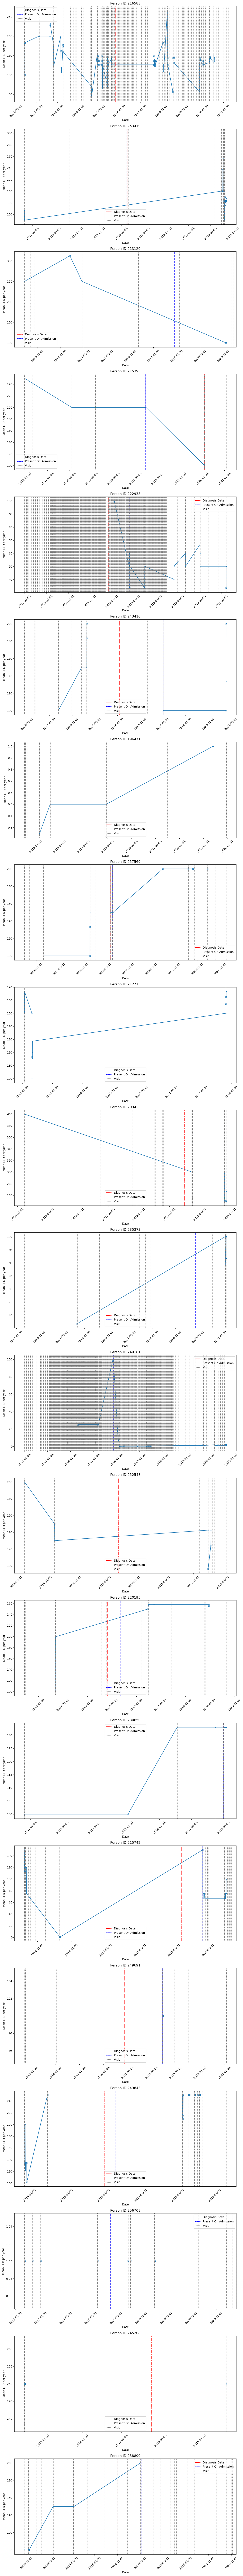

In [456]:
import matplotlib.lines as mlines
# Create individual subplots for each patient
fig, axes = plt.subplots(len(years_of_stay_person_id), 1, figsize=(12, 6 * len(years_of_stay_person_id)))

for i, person_id in enumerate(years_of_stay_person_id):
    person_data = mean_led_per_administration_date[mean_led_per_administration_date['person_id'] == person_id]
    
    # Smooth out the LED values using a moving average
    window_size = 5  # Adjust this value to control the smoothing level
    smoothed_led = person_data['led'].rolling(window=window_size, min_periods=1).mean()
    
    ax = axes[i]
    
    # Plot the data points with dots
    ax.plot(person_data['drug_exposure_start_datetime'], person_data['led'], marker='x', markersize=4, label='Data Points') #-> Normal
    # ax.plot(person_data['drug_exposure_start_datetime'], smoothed_led, marker='x', markersize=4, label='Data Points')
    ax.set_title(f'Person ID {person_id}')
    
    # Set X-axis tick frequency and formatting
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    
    for date, condition_poa in diagnosis_date[diagnosis_date['person_id'] == person_id][['diagnosis_date', 'condition_poa']].values:
        if condition_poa == True:
            ax.axvline(x=date, color='blue', linestyle='--', alpha=0.7, linewidth=2)  # Customize color, linestyle, and alpha as needed
        # The times where there's only one dotted blue line is becasue the earliest date is the POA date
        else:
            ax.axvline(x=date, color='red', linestyle='-.', alpha=0.7, linewidth=2)  # Dash-dot line

    for another_date in visit_occurrence[visit_occurrence['person_id'] == person_id]['visit_start_datetime'].values:
        ax.axvline(x=another_date, color='gray', linestyle=':', alpha=0.7, linewidth=1)

    # Get the generic name for the current person_id
    # generic_name = led_df[led_df['person_id'] == person_id]['generic_name'].values[0]
    
    # Add the generic name to the legend
    # ax.legend([f'LED ({generic_name})'], loc='upper left')
    
    # Create custom legend elements with specified colors
    poa_legend = mlines.Line2D([], [], color='blue', linestyle='--', label='Present On Admission')
    diagnosis_legend = mlines.Line2D([], [], color='red', linestyle='-.', label='Diagnosis Date')
    visit_legend = mlines.Line2D([], [], color='gray', linestyle=':', label='Visit')


    # Add the custom legend elements to the legend
    ax.legend(handles=[diagnosis_legend, poa_legend, visit_legend])

    ax.set_xlabel('Date')
    ax.set_ylabel('Mean LED per year')
    ax.grid(False)
    ax.tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.show()

In [453]:
visit_occurrence[visit_occurrence['person_id'] == 249161].head(30)

person_id drug_exposure_start_datetime  visit_occurrence_id  \
46499     249161          2012-01-21 16:56:00             37665177   
46500     249161          2012-01-21 17:00:00             37665177   
46501     249161          2012-01-24 17:45:00             37665177   
46502     249161          2012-01-24 17:48:00             37665177   
46503     249161          2012-01-24 17:50:00             37665177   
46504     249161          2012-01-24 18:50:00             37665177   
46505     249161          2012-01-26 18:10:00             37665177   
46506     249161          2012-01-28 16:31:00             37665177   
46507     249161          2012-01-28 17:00:00             37665177   
46508     249161          2012-01-28 18:25:00             37665177   
46509     249161          2012-01-31 16:13:00             37665177   
46510     249161          2012-01-31 18:45:00             37665177   
46511     249161          2012-01-27 11:55:00             37665178   
46512     249161          2012-01-27 13:43:00             37665178   
46513     249161          2012-02-02 16:37:00             37665179   
46514     249161          2012-02-02 19:10:00             37665179   
46515     249161          2012-02-04 16:40:00             37665179   
46516     249161          2012-02-04 18:40:00             37665179   
46517     249161          2012-02-07 16:36:00             37665179   
46518     249161          2012-02-07 16:37:00             37665179   
46519     249161          2012-02-07 18:50:00             37665179   
46520     249161          2012-02-09 16:50:00             37665179   
46521     249161          2012-02-09 19:15:00             37665179   
46522     249161          2012-02-11 16:09:00             37665179   
46523     249161          2012-02-11 18:25:00             37665179   
46524     249161          2012-02-14 15:36:00             37665179   
46525     249161          2012-02-14 18:30:00             37665179   
46526     249161          2012-02-16 16:15:00             37665179   
46527     249161          2012-02-16 17:45:00             37665179   
46528     249161          2012-02-16 18:05:00             37665179   

       visit_concept_id visit_start_datetime  
46499              8756  2012-01-01 00:01:00  
46500              8756  2012-01-01 00:01:00  
46501              8756  2012-01-01 00:01:00  
46502              8756  2012-01-01 00:01:00  
46503              8756  2012-01-01 00:01:00  
46504              8756  2012-01-01 00:01:00  
46505              8756  2012-01-01 00:01:00  
46506              8756  2012-01-01 00:01:00  
46507              8756  2012-01-01 00:01:00  
46508              8756  2012-01-01 00:01:00  
46509              8756  2012-01-01 00:01:00  
46510              8756  2012-01-01 00:01:00  
46511           4004517  2012-01-27 08:02:00  
46512           4004517  2012-01-27 08:02:00  
46513              8756  2012-02-01 00:01:00  
46514              8756  2012-02-01 00:01:00  
46515              8756  2012-02-01 00:01:00  
46516              8756  2012-02-01 00:01:00  
46517              8756  2012-02-01 00:01:00  
46518              8756  2012-02-01 00:01:00  
46519              8756  2012-02-01 00:01:00  
46520              8756  2012-02-01 00:01:00  
46521              8756  2012-02-01 00:01:00  
46522              8756  2012-02-01 00:01:00  
46523              8756  2012-02-01 00:01:00  
46524              8756  2012-02-01 00:01:00  
46525              8756  2012-02-01 00:01:00  
46526              8756  2012-02-01 00:01:00  
46527              8756  2012-02-01 00:01:00  
46528              8756  2012-02-01 00:01:00

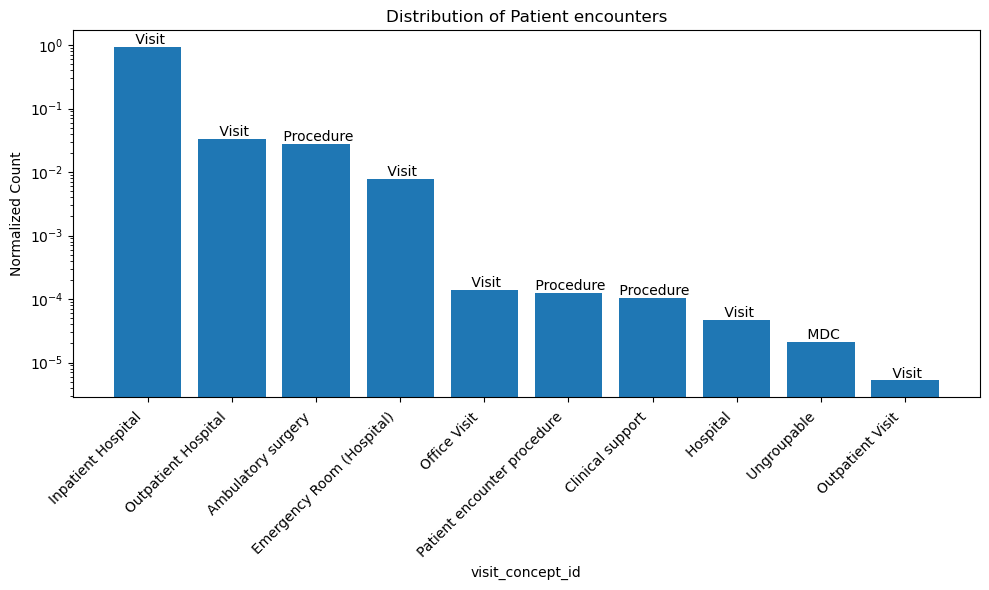

In [441]:
unique_visits = visit_occurrence['visit_concept_id'].unique()
label = {
    8717: 'Inpatient Hospital - Visit',
    8756: 'Outpatient Hospital - Visit',
    4004517: 'Ambulatory surgery - Procedure',
    8870: 'Emergency Room (Hospital) - Visit',
    581477: 'Office Visit - Visit',
    4203722: 'Patient encounter procedure - Procedure',
    44791812: 'Clinical support - Procedure',
    38004515: 'Hospital - Visit',
    0: 'Ungroupable - MDC',
    9202: 'Outpatient Visit - Visit'
}
visit_label = [word.split('-')[0] for word in list(label.values())] 
visit_type = [word.split('-')[1] for word in list(label.values())] 
value_counts = visit_occurrence['visit_concept_id'].value_counts(normalize=True)

# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
bars = plt.bar(visit_label, value_counts)

# Adding labels and title
plt.xlabel('visit_concept_id')
plt.ylabel('Normalized Count')
plt.title('Distribution of Patient encounters')
plt.yscale('log')

for bar, v_type in zip(bars, visit_type):
    x_pos = bar.get_x() + bar.get_width() / 2 # Adjusted x-coordinate
    y_pos = bar.get_height() / 0.9
    plt.text(x_pos, y_pos, v_type, ha='center')

# Show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [355]:
visit_occurrence.groupby('person_id')['visit_start_datetime'].nunique().describe()

count    286.000000
mean      16.895105
std       67.609219
min        1.000000
25%        3.000000
50%        8.000000
75%       13.000000
max      837.000000
Name: visit_start_datetime, dtype: float64

In [356]:
visit_occurrence.loc[visit_occurrence['person_id'] == 175605, ['visit_start_datetime', 'visit_occurrence_id']].head(15)

visit_start_datetime  visit_occurrence_id
190977  2016-02-03 10:23:00             27807625
190978  2016-02-03 10:23:00             27807625
190979  2016-02-03 10:23:00             27807625
190980  2016-05-12 11:00:00             27800762
190981  2016-11-10 09:04:00             27807626
190982  2016-11-10 09:04:00             27807626
190983  2016-11-10 09:04:00             27807626
190984  2016-11-10 09:04:00             27807626
190985  2016-11-10 09:04:00             27807626
190986  2016-11-10 09:04:00             27807626
190987  2016-11-10 09:04:00             27807626
190988  2016-11-10 09:04:00             27807626
190989  2016-11-10 09:04:00             27807626
190990  2016-11-10 09:04:00             27807626
190991  2016-11-10 09:04:00             27807626

In [359]:
len(years_of_stay_person_id)

55

In [245]:
led_df = led_df.sort_values(by=['drug_exposure_start_datetime'], ascending=True)

In [246]:
# This person probably had restless leg syndrome or Parkinsonism
led_df.loc[led_df['person_id'] == 258899, ['diagnosis_date', 'drug_exposure_start_datetime', 'generic_name']]

diagnosis_date drug_exposure_start_datetime        generic_name
3156     2017-01-26          2011-12-05 06:25:00         pramipexole
3155     2015-12-28          2011-12-05 06:25:00         pramipexole
3158     2017-01-26          2012-02-06 22:15:00         pramipexole
3157     2015-12-28          2012-02-06 22:15:00         pramipexole
3160     2017-01-26          2012-02-09 11:00:00         pramipexole
...             ...                          ...                 ...
3149     2015-12-28          2017-01-07 17:17:00  carbidopa-levodopa
3152     2017-01-26          2017-01-07 23:41:00  carbidopa-levodopa
3151     2015-12-28          2017-01-07 23:41:00  carbidopa-levodopa
3153     2015-12-28          2017-01-08 08:00:00  carbidopa-levodopa
3154     2017-01-26          2017-01-08 08:00:00  carbidopa-levodopa

[162 rows x 3 columns]

In [247]:
mean_led_per_administration_date

person_id drug_exposure_start_datetime    led
0        175605                   2017-05-31  100.0
1        175605                   2017-06-01  100.0
2        175605                   2017-06-02  100.0
3        175605                   2017-06-06   50.0
4        175605                   2017-06-07   50.0
...         ...                          ...    ...
6547     260996                   2013-05-28  100.0
6548     260996                   2013-05-29  100.0
6549     260996                   2013-05-30  100.0
6550     261006                   2021-04-11  200.0
6551     261006                   2021-04-12  200.0

[6552 rows x 3 columns]

In [249]:
mean_led_per_administration_date.describe()

person_id          led
count    6552.000000  6472.000000
mean   223954.316392   128.108792
std     25323.473222   113.635482
min    175605.000000     0.000000
25%    203512.000000   100.000000
50%    220109.000000   100.000000
75%    249890.000000   183.333333
max    261006.000000  2412.812500

In [251]:
led_df.groupby('person_id')['visit_occurrence_id'].nunique().sort_values(ascending=False)

person_id
249161    25
256936    24
216583    21
256706    14
208220    12
          ..
235403     1
203512     1
203744     1
203757     1
261006     1
Name: visit_occurrence_id, Length: 286, dtype: int64